# Intra-chain side-chain H-bonds

In [110]:
import isambard_dev
%matplotlib notebook

import matplotlib
import numpy
import json
import matplotlib.pyplot as plt

Find all side-chain H-bonds per chain file and save data in dictionary 

In [2]:
# Read H-bonds data from JSON file
with open('refined1_sc_hbonds.json') as fp:
    hb_all = json.load(fp)

Distirbution of number of H-bonds for all unclassified docked models 

In [3]:
nhbs = [len(hb_all['model_'+format(n+1,'04d')]) for n in range(1000)]

<IPython.core.display.Javascript object>


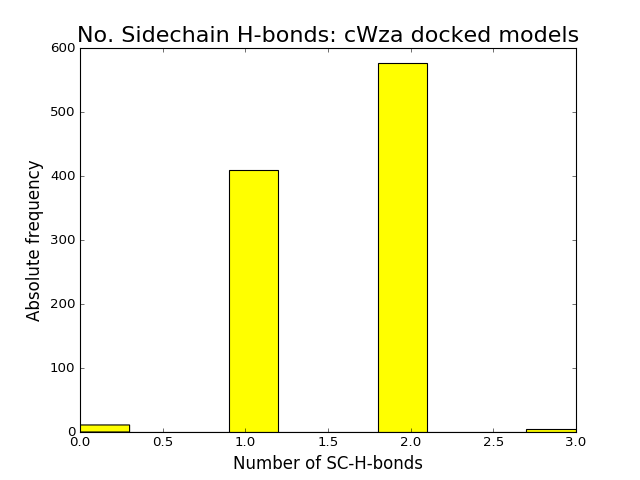

In [4]:
fig = plt.figure()

plt.title('No. Sidechain H-bonds: cWza docked models', fontsize=20)
plt.xlabel("Number of SC-H-bonds", fontsize=15)
plt.ylabel("Absolute frequency", fontsize=15)
plt.hist(nhbs,color='yellow')

plt.show()

Get identity of all found H-bonds regardless of the peptide chain

In [ ]:
hb_states = list(map(set, hb_all.values()))

In [ ]:
set.union(*hb_states)

In total, there are **6 different types of H-bonds** present for all models. In principle, the set of all possible combinations is $2^6$ which equals **64 different possible combinations of H-bonds** that might be present in all structures. However, from the above histogram, we know that most models will present either 1 or 2 H-bonds at the most. Plus, very few will have none or 3 H-bonds at the most. 

Get all combinations of H-bonds found in all docked structures

In [ ]:
hb_combinations = list(set(list(map(str, [set(hb_all['model_'+format(n+1,'04d')]) for n in range(1000)]))))

In [ ]:
for hbs in hb_combinations:
    print(hbs)

In [ ]:
len(hb_combinations)

From this, we see that only **11  H-bond combinations** are found out of 64 possible ones, which represents $<20\%$ .

Calssify identified H-bond combinations by number of H-bonds

In [ ]:
models_by_hbsn = {0:[],1:[],2:[],3:[]}

for n in range(1000):
    L = len(hb_all['model_'+format(n+1,'04d')])
    if L == 0:
        models_by_hbsn[0].append(['model_'+format(n+1,'04d'),hb_all['model_'+format(n+1,'04d')]])
    elif L == 1:
        models_by_hbsn[1].append(['model_'+format(n+1,'04d'), hb_all['model_'+format(n+1,'04d')]])
    elif L == 2:
        models_by_hbsn[2].append(['model_'+format(n+1,'04d'), hb_all['model_'+format(n+1,'04d')]])
    elif L == 3:
        models_by_hbsn[3].append(['model_'+format(n+1,'04d'), hb_all['model_'+format(n+1,'04d')]])
        

We can see that only **11 models** will have **zero sidechain H-bonds**, whereas only **4 models** will have **3 H-bonds** the most.

In [ ]:
print(len(models_by_hbsn[0]),len(models_by_hbsn[3]))

In [ ]:
set.union(*[ set(models_by_hbsn[1][n][1]) for n in range(len(models_by_hbsn[1])) ])

**4 different types of single-H-bond structures**

Which single bond type is the most representative?

In [ ]:
S1 = {'<Hydrogen Bond between (21A) HIS-HE2 ||||| OE2-GLU (25A)>' :"s11" ,
      '<Hydrogen Bond between (28A) ARG-HH11 ||||| OE2-GLU (25A)>':"s12" ,
      '<Hydrogen Bond between (28A) ARG-HH12 ||||| OG1-THR (32A)>':"s13" ,
      '<Hydrogen Bond between (29A) TYR-HH ||||| OE2-GLU (25A)>'  :"s14"
     }

In [ ]:
data_S1 = [ S1[models_by_hbsn[1][n][1][0]] for n in range(len(models_by_hbsn[1])) ]

In [ ]:
import pandas
from collections import Counter
letter_counts = Counter(data_S1)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar',color='green')

hello

In [ ]:
set([ str(set(models_by_hbsn[2][n][1])) for n in range(len(models_by_hbsn[2])) ])

**4 different types of dual-H-bond structures**

Which dual bond type is the most representative?

In [ ]:
S2 = {
 "{'<Hydrogen Bond between (21A) HIS-HD1 ||||| OD1-ASP (22A)>', '<Hydrogen Bond between (28A) ARG-HH11 ||||| OE1-GLU (25A)>'}":"s21",
 "{'<Hydrogen Bond between (21A) HIS-HD1 ||||| OD1-ASP (22A)>', '<Hydrogen Bond between (29A) TYR-HH ||||| OE2-GLU (25A)>'}":"s22",
 "{'<Hydrogen Bond between (28A) ARG-HH12 ||||| OG1-THR (32A)>', '<Hydrogen Bond between (29A) TYR-HH ||||| OE2-GLU (25A)>'}":"s23",
 "{'<Hydrogen Bond between (29A) TYR-HH ||||| OE2-GLU (25A)>', '<Hydrogen Bond between (28A) ARG-HH11 ||||| OE1-GLU (25A)>'}":"s24"
     }

In [ ]:
data_S2 = [ S2[str(set(models_by_hbsn[2][n][1]))] for n in range(len(models_by_hbsn[2])) ]

In [ ]:
import pandas
from collections import Counter
letter_counts = Counter(data_S2)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')

# Relationship with coductive states

In [51]:
def rm_none(data):
    return [x for x in data if x!='None']

In [52]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from setup_db import Json, Pdb, SuperHelix_Parameters, Conformation, BUDE_Energies \
,RosettaMP_Energies, Interhelix_Interactions, HOLE_Output, SASA_Estimates, Base

In [53]:
dbfile = 'refined1.db' # DB file
engine = create_engine('sqlite:///'+dbfile)
Base.metadata.bind = engine
DBSession = sessionmaker()
DBSession.bind = engine
session = DBSession()

In [54]:
model_ids = []
model_number = []
for n in range(1000):
    mid = session.query(Pdb.id).filter_by(
        pdb_name='input/refined1_0001_INPUT_'+str(format(n+1,'04d'))+'_ignorechain.pdb' ).first()
    model_ids.append(mid[0])

Gpred_Rmin_all = []
for id in model_ids:
    try:
        model_Gpred_Rmin = session.query(HOLE_Output.Gpred_Rmin).filter_by(id = id).one()
        Gpred_Rmin_all.append(model_Gpred_Rmin[0])
    except:
        Gpred_Rmin_all.append("None")


In [ ]:
X = []
for n in range(len(models_by_hbsn[1])):
    num = models_by_hbsn[1][n][0].split("_")[1]
    X.append(Gpred_Rmin_all[ int(num)-1 ])

In [ ]:
plt.hist(rm_none(X),bins=40)
plt.plot()

In [ ]:
Y = []
for n in range(len(models_by_hbsn[2])):
    num = models_by_hbsn[2][n][0].split("_")[1]
    Y.append(Gpred_Rmin_all[ int(num)-1 ])

In [ ]:
plt.hist(rm_none(Y),bins=40,color='red')
plt.plot()

This only indicates that inter-SC-H bonds for atoms in the same chain is not enough to explain the difference in conductance 

# Intra-chain main-chain H-bonds 

In [ ]:
mc_hb_all = {}

for n in range(1000):
    # Load chain PDB and convert to AMPAL object
    file = "Achains/ChainA_refined1_0001_INPUT_"+format(n+1,'04d')+"_ignorechain.pdb"
    p = isambard_dev.ampal.convert_pdb_to_ampal(file)
    # Add Hydrogens to structure, if not present
    p_wh = isambard_dev.external_programs.assembly_plus_protons(p.pdb, path=False)
    # Find all H-bonds and select those between sidechain atoms
    hbonds = isambard_dev.interactions.find_hydrogen_bonds(p_wh)
    mc_hbonds = [str(hb) for hb in hbonds if hb.is_mainchain == True]
    mc_hb_all['model_'+format(n+1,'04d')] = list(mc_hbonds)

In [ ]:
# Save H-bonds data in JSON file
with open('refined1_mc_hbonds.json', 'w') as fp:
    json.dump(mc_hb_all, fp)

In [ ]:
nhbs_mc = [len(mc_hb_all['model_'+format(n+1,'04d')]) for n in range(1000)]

In [ ]:
fig_mc = plt.figure()

plt.title('No. Mainchain H-bonds: cWza docked models', fontsize=20)
plt.xlabel("Number of MC H-bonds", fontsize=15)
plt.ylabel("Absolute frequency", fontsize=15)
plt.hist(nhbs_mc,color='orange')

plt.show()

In [ ]:
mc_hb_states = list(map(set, mc_hb_all.values()))

In [ ]:
set.union(*mc_hb_states)

In [ ]:
len(set.union(*mc_hb_states))

**Conclusion**: The identity and the number of intra-chain main-chain H-bonds is identical for all models.

In [ ]:
X_mean = []

for n in range(200):
    X = []
    # Load chain PDB and convert to AMPAL object
    file = "Achains/ChainA_refined1_0001_INPUT_"+format(n+1,'04d')+"_ignorechain.pdb"
    p = isambard_dev.ampal.convert_pdb_to_ampal(file)
    # Add Hydrogens to structure, if not present
    p_wh = isambard_dev.external_programs.assembly_plus_protons(p.pdb, path=False)
    # Find all H-bonds and select those between sidechain atoms
    hbonds = isambard_dev.interactions.find_hydrogen_bonds(p_wh)
    sc_hbonds = [hb for hb in hbonds if hb.is_mainchain == True]
    for k in range(len(sc_hbonds)):
        x = sc_hbonds[k]
        X.append(x.dist)
    X_mean.append(numpy.mean(X))

In [ ]:
Y = []
Z = []
for n in range(200):
    if Gpred_Rmin_all[n] != "None":
        Y.append(Gpred_Rmin_all[n])
        Z.append(X_mean[n])

In [ ]:
plt.scatter(Z,Y)
plt.plot()

# Inter-chain H-bonds 

In [5]:
# Read H-bonds data from JSON file
with open('refined1_sc_hbonds_AB.json') as fp:
    hb_AB_all = json.load(fp)

In [6]:
nhbs_AB = [len(hb_AB_all['model_'+format(n+1,'04d')]) for n in range(1000)]

<IPython.core.display.Javascript object>


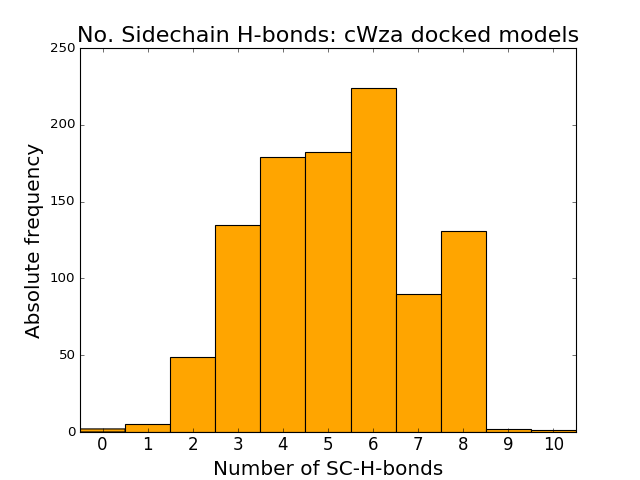

In [38]:
fig_AB = plt.figure()

plt.title('No. Sidechain H-bonds: cWza docked models', fontsize=20)
plt.xlabel("Number of SC-H-bonds",fontsize=18)
plt.xticks(numpy.arange(12)+0.5, numpy.arange(12),fontsize=15)
plt.ylabel("Absolute frequency",fontsize=18)
plt.hist(nhbs_AB,range(12),color='orange')
plt.show()

In [39]:
hbs_interchn = {}
for n in range(1000):
    hbs_interchn['model_'+format(n+1,'04d')] = []
    for hb in hb_AB_all['model_'+format(n+1,'04d')]:
        x = hb.split("(")
        ch1,ch2 = x[1].split(")")[0][-1], x[-1].split(")")[0][-1]
        if ch1 != ch2:
            hbs_interchn['model_'+format(n+1,'04d')].append([ch1,ch2,hb])

In [40]:
nhbs_AB_interchn = [len(hbs_interchn['model_'+format(n+1,'04d')]) for n in range(1000)]

<IPython.core.display.Javascript object>


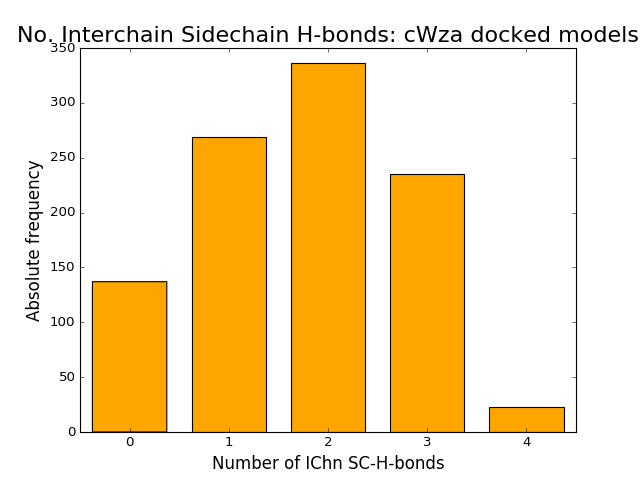

In [41]:
fig_AB_interchn = plt.figure()

plt.title('No. Interchain Sidechain H-bonds: cWza docked models', fontsize=20)
plt.xlabel("Number of IChn SC-H-bonds", fontsize=15)
plt.ylabel("Absolute frequency", fontsize=15)
plt.hist(nhbs_AB_interchn,color='orange', bins=numpy.arange(-1,5)+0.5,rwidth=0.75)
plt.xlim(-0.5,4.5)
plt.show()

Hydrogen bonds have directionality

<IPython.core.display.Javascript object>


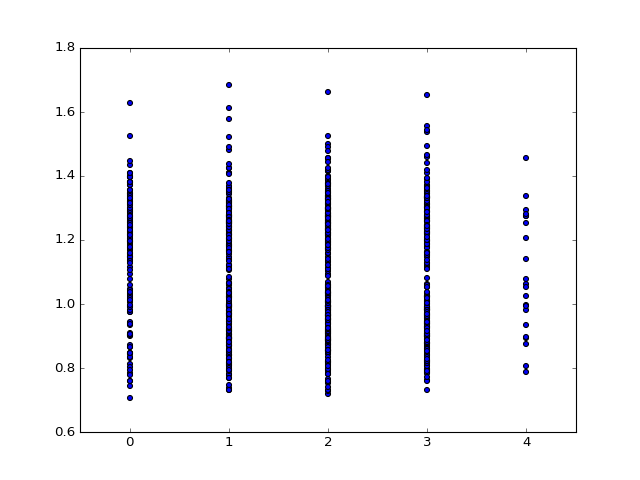

In [56]:
X = []; Y = []
for n in range(1000):
    if Gpred_Rmin_all[n] != "None":
        X.append(nhbs_AB_interchn[n])
        Y.append(Gpred_Rmin_all[n])

fig_scatter = plt.figure()
plt.scatter(X,Y)
plt.xlim(-0.5,4.5)
plt.show()

In [48]:
models_by_interchn_hbsn = {0:[],1:[],2:[],3:[],4:[]}

for n in range(1000):
    L = len(hbs_interchn['model_'+format(n+1,'04d')])
    if L == 0:
        models_by_interchn_hbsn[0].append(['model_'+format(n+1,'04d'), hbs_interchn['model_'+format(n+1,'04d')]])
    elif L == 1:
        models_by_interchn_hbsn[1].append(['model_'+format(n+1,'04d'), hbs_interchn['model_'+format(n+1,'04d')]])
    elif L == 2:
        models_by_interchn_hbsn[2].append(['model_'+format(n+1,'04d'), hbs_interchn['model_'+format(n+1,'04d')]])
    elif L == 3:
        models_by_interchn_hbsn[3].append(['model_'+format(n+1,'04d'), hbs_interchn['model_'+format(n+1,'04d')]])
    elif L == 4:
        models_by_interchn_hbsn[4].append(['model_'+format(n+1,'04d'), hbs_interchn['model_'+format(n+1,'04d')]])

<IPython.core.display.Javascript object>


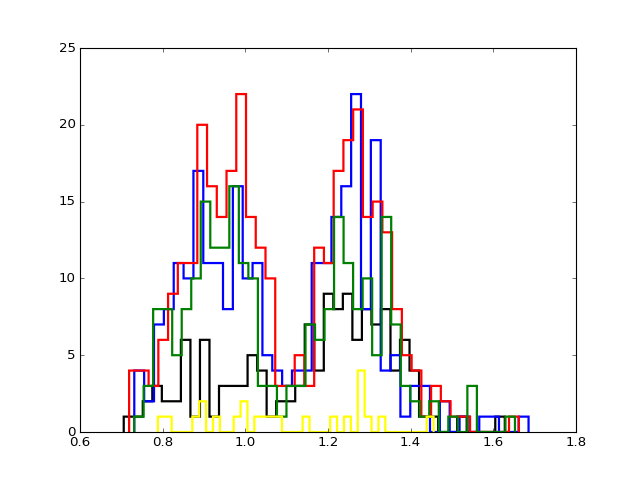

[]

In [58]:
colors = {0:'black',1:'blue',2:'red',3:'green',4:'yellow'}

fig_interchn_hbs_hist = plt.figure()

for n in range(5):
    X = []
    for k in range(len(models_by_interchn_hbsn[n])):
        num = models_by_interchn_hbsn[n][k][0].split("_")[1]
        X.append(Gpred_Rmin_all[ int(num)-1 ])
    plt.hist(rm_none(X),bins=40,color=colors[n],histtype='step',linewidth=2)

plt.plot()

### Models with identical inter-chain single H-bond type

In [74]:
S = list(set([x[1][0][2] for x in models_by_interchn_hbsn[1]]))

This are all the different types of H-bonds shown by models that posses 1 single inter-chain bond.

In [94]:
S

['<Hydrogen Bond between (7A) ASN-HD21 ||||| OG1-THR (16B)>',
 '<Hydrogen Bond between (16B) THR-HG1 ||||| OD1-ASN (7A)>',
 '<Hydrogen Bond between (21A) HIS-HD1 ||||| OG1-THR (26B)>',
 '<Hydrogen Bond between (31A) LYS-HZ1 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (18A) THR-HG1 ||||| OD2-ASP (22B)>',
 '<Hydrogen Bond between (12B) GLN-HE21 ||||| OD1-ASN (7A)>',
 '<Hydrogen Bond between (28A) ARG-HH11 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (7A) ASN-HD22 ||||| OG1-THR (16B)>',
 '<Hydrogen Bond between (7A) ASN-HD21 ||||| OE1-GLN (12B)>',
 '<Hydrogen Bond between (21A) HIS-HE2 ||||| OE1-GLU (25B)>',
 '<Hydrogen Bond between (7A) ASN-HD22 ||||| OE1-GLN (12B)>',
 '<Hydrogen Bond between (31A) LYS-HZ2 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (26B) THR-HG1 ||||| ND1-HIS (21A)>',
 '<Hydrogen Bond between (28A) ARG-HE ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (28A) ARG-HH21 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (12B) GLN-HE22 ||||| OD1-ASN (7A)>']

In [105]:
S_base = {}
for k in range(len(S)):
    S_base[S[k]] = 's'+str(k)

In [106]:
S_base

{'<Hydrogen Bond between (12B) GLN-HE21 ||||| OD1-ASN (7A)>': 's5',
 '<Hydrogen Bond between (12B) GLN-HE22 ||||| OD1-ASN (7A)>': 's15',
 '<Hydrogen Bond between (16B) THR-HG1 ||||| OD1-ASN (7A)>': 's1',
 '<Hydrogen Bond between (18A) THR-HG1 ||||| OD2-ASP (22B)>': 's4',
 '<Hydrogen Bond between (21A) HIS-HD1 ||||| OG1-THR (26B)>': 's2',
 '<Hydrogen Bond between (21A) HIS-HE2 ||||| OE1-GLU (25B)>': 's9',
 '<Hydrogen Bond between (26B) THR-HG1 ||||| ND1-HIS (21A)>': 's12',
 '<Hydrogen Bond between (28A) ARG-HE ||||| OXT-THR (32B)>': 's13',
 '<Hydrogen Bond between (28A) ARG-HH11 ||||| OXT-THR (32B)>': 's6',
 '<Hydrogen Bond between (28A) ARG-HH21 ||||| OXT-THR (32B)>': 's14',
 '<Hydrogen Bond between (31A) LYS-HZ1 ||||| OXT-THR (32B)>': 's3',
 '<Hydrogen Bond between (31A) LYS-HZ2 ||||| OXT-THR (32B)>': 's11',
 '<Hydrogen Bond between (7A) ASN-HD21 ||||| OE1-GLN (12B)>': 's8',
 '<Hydrogen Bond between (7A) ASN-HD21 ||||| OG1-THR (16B)>': 's0',
 '<Hydrogen Bond between (7A) ASN-HD22 ||||

In [96]:
models_1hb = [x[0] for x in models_by_interchn_hbsn[1]]

This are all the models that have 1 inter-chain H-bond

In [97]:
models_1hb

['model_0008',
 'model_0010',
 'model_0012',
 'model_0015',
 'model_0017',
 'model_0038',
 'model_0041',
 'model_0048',
 'model_0053',
 'model_0066',
 'model_0067',
 'model_0069',
 'model_0092',
 'model_0093',
 'model_0097',
 'model_0104',
 'model_0109',
 'model_0110',
 'model_0112',
 'model_0117',
 'model_0119',
 'model_0120',
 'model_0123',
 'model_0125',
 'model_0126',
 'model_0127',
 'model_0129',
 'model_0130',
 'model_0134',
 'model_0139',
 'model_0141',
 'model_0142',
 'model_0143',
 'model_0148',
 'model_0150',
 'model_0151',
 'model_0153',
 'model_0158',
 'model_0163',
 'model_0169',
 'model_0171',
 'model_0173',
 'model_0174',
 'model_0177',
 'model_0184',
 'model_0185',
 'model_0187',
 'model_0197',
 'model_0200',
 'model_0205',
 'model_0208',
 'model_0212',
 'model_0214',
 'model_0216',
 'model_0224',
 'model_0227',
 'model_0228',
 'model_0233',
 'model_0234',
 'model_0238',
 'model_0242',
 'model_0243',
 'model_0245',
 'model_0247',
 'model_0248',
 'model_0250',
 'model_02

In [108]:
models_per_1hb_type = {}
for s in S:
    models_per_1hb_type[S_base[s]] = []
    for x in models_by_interchn_hbsn[1]:
        if x[1][0][2] == s:
            models_per_1hb_type[S_base[s]].append(x[0])

In [109]:
models_per_1hb_type.keys()

dict_keys(['s4', 's7', 's10', 's1', 's8', 's3', 's14', 's9', 's0', 's2', 's11', 's13', 's12', 's6', 's5', 's15'])

<IPython.core.display.Javascript object>


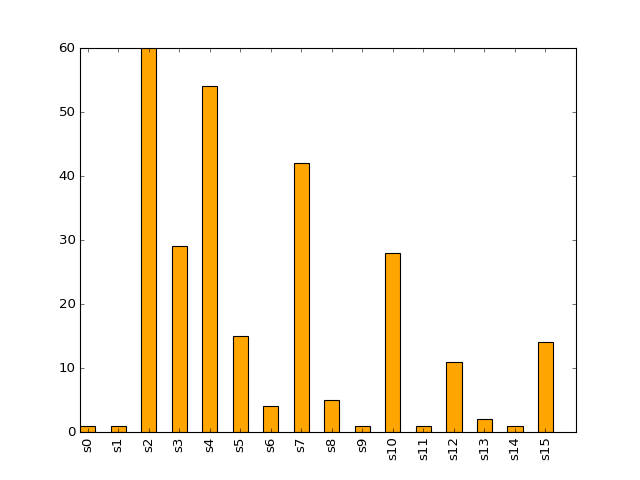

In [134]:
fig_bar = plt.figure()

N = len(models_per_1hb_type.keys())

plt.bar(list(numpy.arange(N)-0.25),[len(models_per_1hb_type['s'+str(k)]) for k in range(N)],width=0.5,color='orange')
plt.xticks(list(numpy.arange(N)), ['s'+str(k) for k in range(N)],rotation=90)
plt.xlim(-0.25,16)    
plt.show()

In [136]:
S_base

{'<Hydrogen Bond between (12B) GLN-HE21 ||||| OD1-ASN (7A)>': 's5',
 '<Hydrogen Bond between (12B) GLN-HE22 ||||| OD1-ASN (7A)>': 's15',
 '<Hydrogen Bond between (16B) THR-HG1 ||||| OD1-ASN (7A)>': 's1',
 '<Hydrogen Bond between (18A) THR-HG1 ||||| OD2-ASP (22B)>': 's4',
 '<Hydrogen Bond between (21A) HIS-HD1 ||||| OG1-THR (26B)>': 's2',
 '<Hydrogen Bond between (21A) HIS-HE2 ||||| OE1-GLU (25B)>': 's9',
 '<Hydrogen Bond between (26B) THR-HG1 ||||| ND1-HIS (21A)>': 's12',
 '<Hydrogen Bond between (28A) ARG-HE ||||| OXT-THR (32B)>': 's13',
 '<Hydrogen Bond between (28A) ARG-HH11 ||||| OXT-THR (32B)>': 's6',
 '<Hydrogen Bond between (28A) ARG-HH21 ||||| OXT-THR (32B)>': 's14',
 '<Hydrogen Bond between (31A) LYS-HZ1 ||||| OXT-THR (32B)>': 's3',
 '<Hydrogen Bond between (31A) LYS-HZ2 ||||| OXT-THR (32B)>': 's11',
 '<Hydrogen Bond between (7A) ASN-HD21 ||||| OE1-GLN (12B)>': 's8',
 '<Hydrogen Bond between (7A) ASN-HD21 ||||| OG1-THR (16B)>': 's0',
 '<Hydrogen Bond between (7A) ASN-HD22 ||||

In [176]:
data_com_low = []

for model in models_per_1hb_type['s4']:
    modeln = model.split("_")[1]
    G_model = Gpred_Rmin_all[int(modeln)-1]
    if 0.83 < G_model < 1.03:
        #print("Low", modeln, G_model)
        protein = isambard_dev.ampal.convert_pdb_to_ampal(
            "../cc-fitting/input/refined1_0001_INPUT_"+format(modeln)+"_ignorechain.pdb")
        chain_com = protein[0].backbone.centre_of_mass
        protein_com = protein.backbone.centre_of_mass
        d_com = numpy.linalg.norm(chain_com - protein_com)
        print(modeln, d_com, G_model)
        data_com_low.append(d_com)
    #elif 1.19 < G_model < 1.35:
    #    print("High", modeln, G_model)


0112 13.2371302073 0.84139936
0126 13.4422148819 0.9177999
0143 15.2790618152 0.89687972
0174 13.9520173137 1.00010981
0250 14.1441461635 0.84125954
0287 14.096899745 0.998055
0311 13.391450227 0.8500595
0312 14.1200065603 0.90302447
0346 14.1324277483 0.86955276
0371 14.9920121691 0.91727361
0424 15.0842332938 0.99315023
0472 14.1473887001 0.87269701
0654 14.9822583082 0.99656859
0727 13.1338136094 0.87266201
0761 15.0044741625 0.98184835
0962 15.1130012685 1.01448048
0970 13.5190911562 0.9538231899999999


In [177]:
data_com_high = []
for model in models_per_1hb_type['s4']:
    modeln = model.split("_")[1]
    G_model = Gpred_Rmin_all[int(modeln)-1]
    #if 0.83 < G_model < 1.03:
     #   print("Low", modeln, G_model)
    if 1.19 < G_model < 1.35:
        #print("High", modeln, G_model)
        protein = isambard_dev.ampal.convert_pdb_to_ampal(
            "../cc-fitting/input/refined1_0001_INPUT_"+format(modeln)+"_ignorechain.pdb")
        chain_com = protein[0].backbone.centre_of_mass
        protein_com = protein.backbone.centre_of_mass
        d_com = numpy.linalg.norm(chain_com - protein_com)
        print(modeln, d_com, G_model)
        data_com_high.append(d_com)

0053 15.2159860093 1.22147091
0123 15.076900323 1.3025811100000002
0139 14.9751281757 1.24231489
0148 14.8280410787 1.23717159
0224 13.8457327348 1.32451735
0234 14.9093562719 1.31471297
0342 15.0469592596 1.22912519
0452 14.3397701023 1.31247387
0546 13.6832206338 1.3138743199999998
0564 14.9863577499 1.34902837
0616 13.6567284915 1.2795651700000001
0664 14.8028316484 1.21882188
0665 14.6097452726 1.25311105
0666 13.2501668805 1.2327955
0683 14.6884339354 1.25273637
0740 13.6604362791 1.2518967500000002
0772 13.4217679179 1.2452819
0863 13.2891601078 1.30879657
0867 15.5305545692 1.32897917
0952 14.2515389227 1.2503784599999999
0995 14.0314317546 1.2587728


<IPython.core.display.Javascript object>


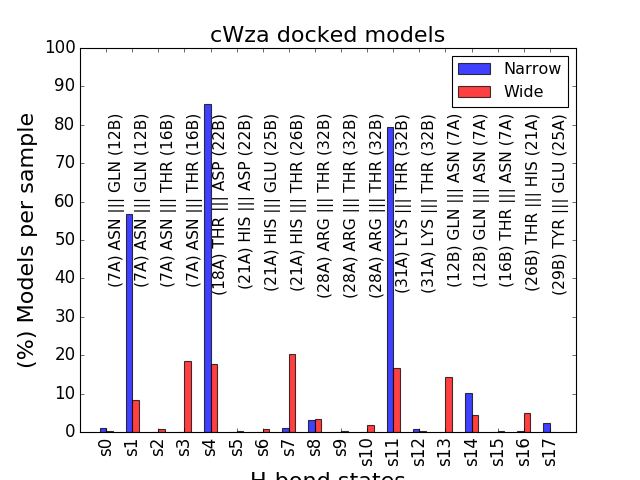

In [178]:
figg = plt.figure()
plt.plot(data_com_low,'bo')
plt.plot(data_com_high,'ro')
plt.show()

In [108]:
data_com = []

for n in range(1000):
        protein = isambard_dev.ampal.convert_pdb_to_ampal(
            "../cc-fitting/input/refined1_0001_INPUT_"+format(n+1,'04d')+"_ignorechain.pdb")
        chain_com = protein[0].backbone.centre_of_mass
        protein_com = protein.backbone.centre_of_mass
        d_com = numpy.linalg.norm(chain_com - protein_com)
        data_com.append(d_com)

<IPython.core.display.Javascript object>


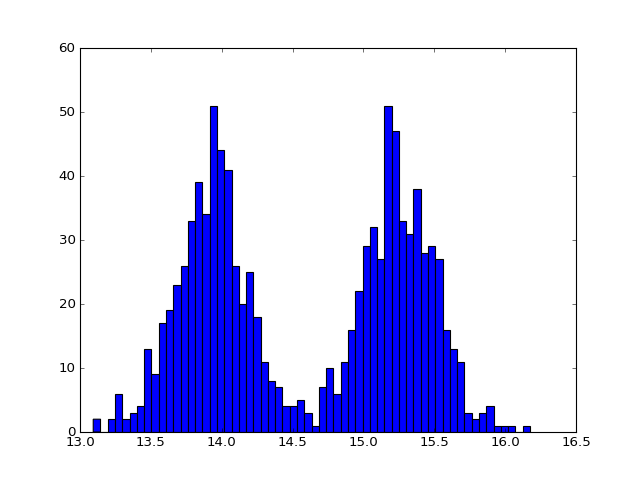

In [111]:
fig_com = plt.figure()

plt.hist(data_com,60)
plt.show()

In [112]:
models_narrow_bb = []
models_wide_bb = []

for n in range(1000):
    d = data_com[n]
    if (13.94-0.2) < d < (13.94+0.2):
        models_narrow_bb.append(format(n+1,'04d'))
    elif (15.23-0.2) < d < (15.23+0.2):
        models_wide_bb.append(format(n+1,'04d'))

In [113]:
for n in models_wide_bb:
    print(n)

0001
0007
0009
0011
0012
0017
0019
0025
0036
0038
0043
0046
0052
0053
0055
0058
0064
0065
0067
0068
0069
0071
0073
0080
0082
0085
0092
0097
0099
0107
0108
0115
0119
0123
0124
0130
0131
0134
0135
0141
0143
0144
0145
0147
0149
0151
0153
0156
0158
0159
0165
0171
0173
0176
0184
0188
0194
0196
0198
0200
0208
0209
0216
0219
0225
0228
0232
0235
0238
0239
0241
0242
0247
0248
0256
0257
0263
0264
0266
0271
0272
0273
0276
0277
0278
0286
0290
0291
0292
0294
0302
0305
0317
0318
0319
0322
0324
0331
0336
0337
0338
0340
0342
0347
0355
0356
0357
0358
0363
0367
0368
0372
0377
0378
0381
0382
0387
0393
0399
0403
0404
0408
0420
0423
0424
0426
0430
0434
0435
0438
0445
0446
0448
0454
0455
0457
0460
0463
0464
0465
0469
0470
0471
0475
0476
0484
0485
0486
0488
0489
0490
0497
0501
0503
0510
0516
0519
0523
0524
0527
0541
0543
0554
0555
0560
0563
0565
0566
0567
0572
0575
0578
0581
0584
0588
0589
0590
0591
0595
0598
0609
0614
0615
0618
0622
0624
0626
0628
0629
0633
0639
0641
0643
0649
0650
0653
0658
0659
0660
0661


In [194]:
all_hbs_narrow = []
for modeln in models_narrow_bb:
    hbs_per_model = hbs_interchn['model_'+str(modeln)]
    for hb in hbs_per_model:
        all_hbs_narrow.append(hb[2])

In [200]:
set(all_hbs_narrow)

{'<Hydrogen Bond between (12B) GLN-HE22 ||||| OD1-ASN (7A)>',
 '<Hydrogen Bond between (18A) THR-HG1 ||||| OD2-ASP (22B)>',
 '<Hydrogen Bond between (21A) HIS-HD1 ||||| OG1-THR (26B)>',
 '<Hydrogen Bond between (26B) THR-HG1 ||||| ND1-HIS (21A)>',
 '<Hydrogen Bond between (28A) ARG-HH11 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (29B) TYR-HH ||||| OE2-GLU (25A)>',
 '<Hydrogen Bond between (31A) LYS-HZ1 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (31A) LYS-HZ2 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (7A) ASN-HD21 ||||| OE1-GLN (12B)>',
 '<Hydrogen Bond between (7A) ASN-HD22 ||||| OE1-GLN (12B)>'}

In [444]:
ordered_hbonds

['<Hydrogen Bond between (7A) ASN-HD21 ||||| OE1-GLN (12B)>',
 '<Hydrogen Bond between (7A) ASN-HD22 ||||| OE1-GLN (12B)>',
 '<Hydrogen Bond between (7A) ASN-HD21 ||||| OG1-THR (16B)>',
 '<Hydrogen Bond between (7A) ASN-HD22 ||||| OG1-THR (16B)>',
 '<Hydrogen Bond between (18A) THR-HG1 ||||| OD2-ASP (22B)>',
 '<Hydrogen Bond between (21A) HIS-HD1 ||||| OD2-ASP (22B)>',
 '<Hydrogen Bond between (21A) HIS-HE2 ||||| OE2-GLU (25B)>',
 '<Hydrogen Bond between (21A) HIS-HD1 ||||| OG1-THR (26B)>',
 '<Hydrogen Bond between (28A) ARG-HH11 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (28A) ARG-HH21 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (28A) ARG-HE ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (31A) LYS-HZ1 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (31A) LYS-HZ2 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (12B) GLN-HE21 ||||| OD1-ASN (7A)>',
 '<Hydrogen Bond between (12B) GLN-HE22 ||||| OD1-ASN (7A)>',
 '<Hydrogen Bond between (16B) THR-HG1 ||||| OD1-ASN (7A)>',
 '<Hydro

In [486]:
hb1_narrow = '<Hydrogen Bond between (7A) ASN-HD22 ||||| OE1-GLN (12B)>'
hb2_narrow = '<Hydrogen Bond between (18A) THR-HG1 ||||| OD2-ASP (22B)>'
hb3_narrow = '<Hydrogen Bond between (31A) LYS-HZ1 ||||| OXT-THR (32B)>'
kih_narrow = "['B29', ['A21', 'A24', 'A25', 'A28']]"

for nmodel in models_narrow_bb:
    x = hbs_interchn['model_'+nmodel]
    y = kihs_all['model_'+nmodel]
    X = [xx[2] for xx in x]
    if (kih_narrow in y) and (hb1_narrow in X) and (hb2_narrow in X) and (hb3_narrow in X):
        print("../../cc-fitting/input_trimmed/refined1_0001_INPUT_"+nmodel+"_ignorechain.pdb")
        #print(nmodel,kih_narrow in y, hb1_narrow in X,hb2_narrow in X,hb3_narrow in X)

../../cc-fitting/input_trimmed/refined1_0001_INPUT_0002_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0004_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0027_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0031_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0057_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0079_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0081_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0111_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0114_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0137_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0138_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0166_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0190_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0213_ignorech

In [487]:
kih1_wide = "['A3', ['B9', 'B12', 'B13', 'B16']]"
kih2_wide = "['B16', ['A3', 'A6', 'A7', 'A10']]"
kih3_wide = "['B29', ['A21', 'A24', 'A25', 'A28']]"

for nmodel in models_wide_bb:
    y = kihs_all['model_'+nmodel]
    #print(kih1_wide in y, kih2_wide in y, kih3_wide not in y)
    if (kih1_wide in y) and (kih2_wide in y) and (kih3_wide not in y):
        print("../../cc-fitting/input_trimmed/refined1_0001_INPUT_"+nmodel+"_ignorechain.pdb")
#         print(nmodel)

../../cc-fitting/input_trimmed/refined1_0001_INPUT_0007_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0011_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0012_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0017_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0025_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0036_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0038_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0043_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0052_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0064_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0067_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0068_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0071_ignorechain.pdb
../../cc-fitting/input_trimmed/refined1_0001_INPUT_0073_ignorech

In [201]:
S_hbs_narrow = set(all_hbs_narrow)

In [196]:
all_hbs_wide = []
for modeln in models_wide_bb:
    hbs_per_model = hbs_interchn['model_'+str(modeln)]
    for hb in hbs_per_model:
        all_hbs_wide.append(hb[2])

In [197]:
set(all_hbs_wide)

{'<Hydrogen Bond between (12B) GLN-HE21 ||||| OD1-ASN (7A)>',
 '<Hydrogen Bond between (12B) GLN-HE22 ||||| OD1-ASN (7A)>',
 '<Hydrogen Bond between (16B) THR-HG1 ||||| OD1-ASN (7A)>',
 '<Hydrogen Bond between (18A) THR-HG1 ||||| OD2-ASP (22B)>',
 '<Hydrogen Bond between (21A) HIS-HD1 ||||| OD2-ASP (22B)>',
 '<Hydrogen Bond between (21A) HIS-HD1 ||||| OG1-THR (26B)>',
 '<Hydrogen Bond between (21A) HIS-HE2 ||||| OE2-GLU (25B)>',
 '<Hydrogen Bond between (26B) THR-HG1 ||||| ND1-HIS (21A)>',
 '<Hydrogen Bond between (28A) ARG-HE ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (28A) ARG-HH11 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (28A) ARG-HH21 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (31A) LYS-HZ1 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (31A) LYS-HZ2 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (7A) ASN-HD21 ||||| OE1-GLN (12B)>',
 '<Hydrogen Bond between (7A) ASN-HD21 ||||| OG1-THR (16B)>',
 '<Hydrogen Bond between (7A) ASN-HD22 ||||| OE1-GLN (12B)>',
 '<Hydro

In [202]:
S_hbs_wide = set(all_hbs_wide)

In [203]:
S_hbs_wide.difference(S_hbs_narrow)

{'<Hydrogen Bond between (12B) GLN-HE21 ||||| OD1-ASN (7A)>',
 '<Hydrogen Bond between (16B) THR-HG1 ||||| OD1-ASN (7A)>',
 '<Hydrogen Bond between (21A) HIS-HD1 ||||| OD2-ASP (22B)>',
 '<Hydrogen Bond between (21A) HIS-HE2 ||||| OE2-GLU (25B)>',
 '<Hydrogen Bond between (28A) ARG-HE ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (28A) ARG-HH21 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (7A) ASN-HD21 ||||| OG1-THR (16B)>',
 '<Hydrogen Bond between (7A) ASN-HD22 ||||| OG1-THR (16B)>'}

In [205]:
set(all_hbs_narrow)

{'<Hydrogen Bond between (12B) GLN-HE22 ||||| OD1-ASN (7A)>',
 '<Hydrogen Bond between (18A) THR-HG1 ||||| OD2-ASP (22B)>',
 '<Hydrogen Bond between (21A) HIS-HD1 ||||| OG1-THR (26B)>',
 '<Hydrogen Bond between (26B) THR-HG1 ||||| ND1-HIS (21A)>',
 '<Hydrogen Bond between (28A) ARG-HH11 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (29B) TYR-HH ||||| OE2-GLU (25A)>',
 '<Hydrogen Bond between (31A) LYS-HZ1 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (31A) LYS-HZ2 ||||| OXT-THR (32B)>',
 '<Hydrogen Bond between (7A) ASN-HD21 ||||| OE1-GLN (12B)>',
 '<Hydrogen Bond between (7A) ASN-HD22 ||||| OE1-GLN (12B)>'}

In [309]:
ordered_hbonds =  [
'<Hydrogen Bond between (7A) ASN-HD21 ||||| OE1-GLN (12B)>',
'<Hydrogen Bond between (7A) ASN-HD22 ||||| OE1-GLN (12B)>',
'<Hydrogen Bond between (7A) ASN-HD21 ||||| OG1-THR (16B)>',
'<Hydrogen Bond between (7A) ASN-HD22 ||||| OG1-THR (16B)>',
'<Hydrogen Bond between (18A) THR-HG1 ||||| OD2-ASP (22B)>',
'<Hydrogen Bond between (21A) HIS-HD1 ||||| OD2-ASP (22B)>',
'<Hydrogen Bond between (21A) HIS-HE2 ||||| OE2-GLU (25B)>',
'<Hydrogen Bond between (21A) HIS-HD1 ||||| OG1-THR (26B)>',
'<Hydrogen Bond between (28A) ARG-HH11 ||||| OXT-THR (32B)>',
'<Hydrogen Bond between (28A) ARG-HH21 ||||| OXT-THR (32B)>',
'<Hydrogen Bond between (28A) ARG-HE ||||| OXT-THR (32B)>',
'<Hydrogen Bond between (31A) LYS-HZ1 ||||| OXT-THR (32B)>',
'<Hydrogen Bond between (31A) LYS-HZ2 ||||| OXT-THR (32B)>',
'<Hydrogen Bond between (12B) GLN-HE21 ||||| OD1-ASN (7A)>',
'<Hydrogen Bond between (12B) GLN-HE22 ||||| OD1-ASN (7A)>',
'<Hydrogen Bond between (16B) THR-HG1 ||||| OD1-ASN (7A)>',
'<Hydrogen Bond between (26B) THR-HG1 ||||| ND1-HIS (21A)>',
'<Hydrogen Bond between (29B) TYR-HH ||||| OE2-GLU (25A)>'
]

In [310]:
S_hbonds_states_all = {}
for k in range(len(ordered_hbonds)):
    S_hbonds_states_all[ordered_hbonds[k]] = 's'+str(k)

In [311]:
S_hbonds_states_all

{'<Hydrogen Bond between (12B) GLN-HE21 ||||| OD1-ASN (7A)>': 's13',
 '<Hydrogen Bond between (12B) GLN-HE22 ||||| OD1-ASN (7A)>': 's14',
 '<Hydrogen Bond between (16B) THR-HG1 ||||| OD1-ASN (7A)>': 's15',
 '<Hydrogen Bond between (18A) THR-HG1 ||||| OD2-ASP (22B)>': 's4',
 '<Hydrogen Bond between (21A) HIS-HD1 ||||| OD2-ASP (22B)>': 's5',
 '<Hydrogen Bond between (21A) HIS-HD1 ||||| OG1-THR (26B)>': 's7',
 '<Hydrogen Bond between (21A) HIS-HE2 ||||| OE2-GLU (25B)>': 's6',
 '<Hydrogen Bond between (26B) THR-HG1 ||||| ND1-HIS (21A)>': 's16',
 '<Hydrogen Bond between (28A) ARG-HE ||||| OXT-THR (32B)>': 's10',
 '<Hydrogen Bond between (28A) ARG-HH11 ||||| OXT-THR (32B)>': 's8',
 '<Hydrogen Bond between (28A) ARG-HH21 ||||| OXT-THR (32B)>': 's9',
 '<Hydrogen Bond between (29B) TYR-HH ||||| OE2-GLU (25A)>': 's17',
 '<Hydrogen Bond between (31A) LYS-HZ1 ||||| OXT-THR (32B)>': 's11',
 '<Hydrogen Bond between (31A) LYS-HZ2 ||||| OXT-THR (32B)>': 's12',
 '<Hydrogen Bond between (7A) ASN-HD21 ||

In [312]:
nstates_narrow = []
for k in range(len(S_hbonds_states_all.keys())):
    counter = 0
    for x in all_hbs_narrow:
        if S_hbonds_states_all[x] == 's'+str(k):
            counter += 1
    nstates_narrow.append(counter)

In [313]:
nstates_wide = []
for k in range(len(S_hbonds_states_all.keys())):
    counter = 0
    for x in all_hbs_wide:
        if S_hbonds_states_all[x] == 's'+str(k):
            counter += 1
    nstates_wide.append(counter)

In [354]:
ordered_hbonds_label = []
for x in ordered_hbonds:
    a = x.split('-')
    ordered_hbonds_label.append(a[0][23:]+' ||| '+a[-1][:-1])

<IPython.core.display.Javascript object>


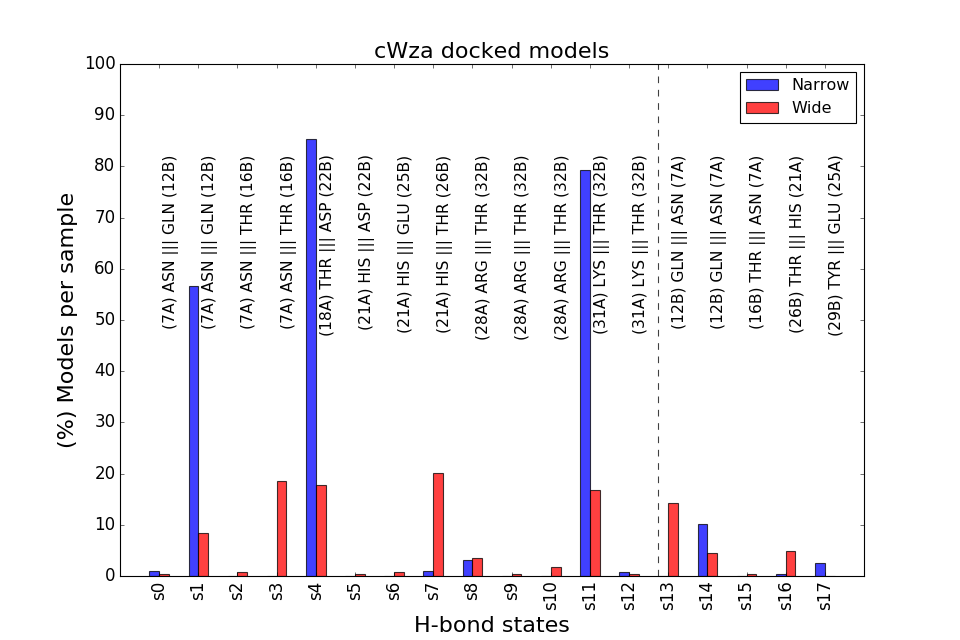

In [362]:
 figgg = plt.figure(figsize=(12,8))

plt.bar(numpy.arange(len(nstates_narrow))-0.25,numpy.array(nstates_narrow)/len(models_narrow_bb),
        width=0.25,facecolor='blue',label='Narrow',alpha=0.75)
plt.bar(numpy.arange(len(nstates_wide)),numpy.array(nstates_wide)/len(models_wide_bb),width=0.25,
        facecolor='red',label='Wide',alpha=0.75)

plt.title('cWza docked models',fontsize=20)
plt.xlabel("H-bond states",fontsize=20)
plt.ylabel("(%) Models per sample",fontsize=20)
plt.xticks(numpy.arange(len(nstates_narrow)),
           ['s'+str(k) for k in numpy.arange(len(nstates_narrow))],rotation=90,fontsize=15)
plt.yticks(numpy.arange(0,1.1,0.1),numpy.arange(0,110,10),fontsize=15)
plt.xlim(-1,18)
plt.ylim(0,1)

plt.legend()

for i in range(len(ordered_hbonds_label)):
    plt.text(i+0.1,0.8,ordered_hbonds_label[i],rotation=90,fontsize=14)

plt.plot((12.75,12.75),(0,100),linestyle='--',color='black',alpha=0.75)

plt.show()

## KIHs for narrow and wide backbone ring

In [364]:
# Read H-bonds data from JSON file
with open('refined1_kihs.json') as fp:
    kihs_all = json.load(fp)

In [373]:
all_kihs_narrow = []
for modeln in models_narrow_bb:
    kihs_per_model = kihs_all['model_'+str(modeln)]
    for kih in kihs_per_model:
        all_kihs_narrow.append(str(kih))

In [378]:
S_kihs_narrow = set(all_kihs_narrow)

In [375]:
set(all_kihs_narrow)

{"['A14', ['B15', 'B18', 'B19', 'B22']]",
 "['A17', ['B19', 'B22', 'B23', 'B26']]",
 "['A21', ['B22', 'B25', 'B26', 'B29']]",
 "['A3', ['B9', 'B12', 'B13', 'B16']]",
 "['B12', ['A1', 'A3', 'A4', 'A7']]",
 "['B15', ['A7', 'A10', 'A11', 'A14']]",
 "['B16', ['A3', 'A6', 'A7', 'A10']]",
 "['B19', ['A10', 'A13', 'A14', 'A17']]",
 "['B19', ['A10', 'A14', 'A17', 'A18']]",
 "['B22', ['A14', 'A17', 'A18', 'A21']]",
 "['B26', ['A17', 'A20', 'A21', 'A24']]",
 "['B29', ['A21', 'A24', 'A25', 'A28']]",
 "['B29', ['A21', 'A25', 'A28', 'A29']]"}

In [376]:
all_kihs_wide = []
for modeln in models_wide_bb:
    kihs_per_model = kihs_all['model_'+str(modeln)]
    for kih in kihs_per_model:
        all_kihs_wide.append(str(kih))

In [379]:
S_kihs_wide = set(all_kihs_wide)

In [377]:
set(all_kihs_wide)

{"['A17', ['B19', 'B22', 'B23', 'B26']]",
 "['A21', ['B19', 'B22', 'B23', 'B26']]",
 "['A21', ['B22', 'B25', 'B26', 'B29']]",
 "['A3', ['B9', 'B12', 'B13', 'B16']]",
 "['B12', ['A1', 'A3', 'A4', 'A7']]",
 "['B16', ['A3', 'A6', 'A7', 'A10']]",
 "['B19', ['A10', 'A13', 'A14', 'A17']]",
 "['B22', ['A14', 'A17', 'A18', 'A21']]",
 "['B26', ['A17', 'A20', 'A21', 'A24']]",
 "['B26', ['A20', 'A21', 'A24', 'A25']]",
 "['B29', ['A21', 'A24', 'A25', 'A28']]"}

In [381]:
print(len(S_kihs_narrow), len(S_kihs_wide))

13 11


In [382]:
S_kihs_narrow.difference(S_kihs_wide)

{"['A14', ['B15', 'B18', 'B19', 'B22']]",
 "['B15', ['A7', 'A10', 'A11', 'A14']]",
 "['B19', ['A10', 'A14', 'A17', 'A18']]",
 "['B29', ['A21', 'A25', 'A28', 'A29']]"}

In [383]:
S_kihs_narrow.union(S_kihs_wide)

{"['A14', ['B15', 'B18', 'B19', 'B22']]",
 "['A17', ['B19', 'B22', 'B23', 'B26']]",
 "['A21', ['B19', 'B22', 'B23', 'B26']]",
 "['A21', ['B22', 'B25', 'B26', 'B29']]",
 "['A3', ['B9', 'B12', 'B13', 'B16']]",
 "['B12', ['A1', 'A3', 'A4', 'A7']]",
 "['B15', ['A7', 'A10', 'A11', 'A14']]",
 "['B16', ['A3', 'A6', 'A7', 'A10']]",
 "['B19', ['A10', 'A13', 'A14', 'A17']]",
 "['B19', ['A10', 'A14', 'A17', 'A18']]",
 "['B22', ['A14', 'A17', 'A18', 'A21']]",
 "['B26', ['A17', 'A20', 'A21', 'A24']]",
 "['B26', ['A20', 'A21', 'A24', 'A25']]",
 "['B29', ['A21', 'A24', 'A25', 'A28']]",
 "['B29', ['A21', 'A25', 'A28', 'A29']]"}

In [384]:
ordered_kihs = [
"['A3', ['B9', 'B12', 'B13', 'B16']]",
"['A14', ['B15', 'B18', 'B19', 'B22']]",
"['A17', ['B19', 'B22', 'B23', 'B26']]",
"['A21', ['B19', 'B22', 'B23', 'B26']]",
"['A21', ['B22', 'B25', 'B26', 'B29']]",
"['B12', ['A1', 'A3', 'A4', 'A7']]",
"['B15', ['A7', 'A10', 'A11', 'A14']]",
"['B16', ['A3', 'A6', 'A7', 'A10']]",
"['B19', ['A10', 'A13', 'A14', 'A17']]",
"['B19', ['A10', 'A14', 'A17', 'A18']]",
"['B22', ['A14', 'A17', 'A18', 'A21']]",
"['B26', ['A17', 'A20', 'A21', 'A24']]",
"['B26', ['A20', 'A21', 'A24', 'A25']]",
"['B29', ['A21', 'A24', 'A25', 'A28']]",
"['B29', ['A21', 'A25', 'A28', 'A29']]"
]

In [385]:
S_kihs_states_all = {}
for k in range(len(ordered_kihs)):
    S_kihs_states_all[ordered_kihs[k]] = 's'+str(k)

In [386]:
S_kihs_states_all

{"['A14', ['B15', 'B18', 'B19', 'B22']]": 's1',
 "['A17', ['B19', 'B22', 'B23', 'B26']]": 's2',
 "['A21', ['B19', 'B22', 'B23', 'B26']]": 's3',
 "['A21', ['B22', 'B25', 'B26', 'B29']]": 's4',
 "['A3', ['B9', 'B12', 'B13', 'B16']]": 's0',
 "['B12', ['A1', 'A3', 'A4', 'A7']]": 's5',
 "['B15', ['A7', 'A10', 'A11', 'A14']]": 's6',
 "['B16', ['A3', 'A6', 'A7', 'A10']]": 's7',
 "['B19', ['A10', 'A13', 'A14', 'A17']]": 's8',
 "['B19', ['A10', 'A14', 'A17', 'A18']]": 's9',
 "['B22', ['A14', 'A17', 'A18', 'A21']]": 's10',
 "['B26', ['A17', 'A20', 'A21', 'A24']]": 's11',
 "['B26', ['A20', 'A21', 'A24', 'A25']]": 's12',
 "['B29', ['A21', 'A24', 'A25', 'A28']]": 's13',
 "['B29', ['A21', 'A25', 'A28', 'A29']]": 's14'}

In [387]:
nstates_kihs_narrow = []
for k in range(len(S_kihs_states_all.keys())):
    counter = 0
    for x in all_kihs_narrow:
        if S_kihs_states_all[x] == 's'+str(k):
            counter += 1
    nstates_kihs_narrow.append(counter)

In [388]:
nstates_kihs_narrow

[50, 75, 225, 0, 286, 198, 1, 6, 20, 39, 239, 225, 0, 167, 1]

In [389]:
nstates_kihs_wide = []
for k in range(len(S_kihs_states_all.keys())):
    counter = 0
    for x in all_kihs_wide:
        if S_kihs_states_all[x] == 's'+str(k):
            counter += 1
    nstates_kihs_wide.append(counter)

In [390]:
nstates_kihs_wide

[242, 0, 234, 2, 276, 244, 0, 189, 1, 0, 229, 245, 2, 55, 0]

In [421]:
ordered_kihs_label = []
for x in ordered_kihs:
    y = x.split(',')
    knob,h1,h2,h3,h4 = y[0][2:-1],y[1][3:-1],y[2][2:-1],y[3][2:-1],y[4][2:-3]
    ordered_kihs_label.append(knob+' => '+h1+'-'+h2+'-'+h3+'-'+h4)

<IPython.core.display.Javascript object>


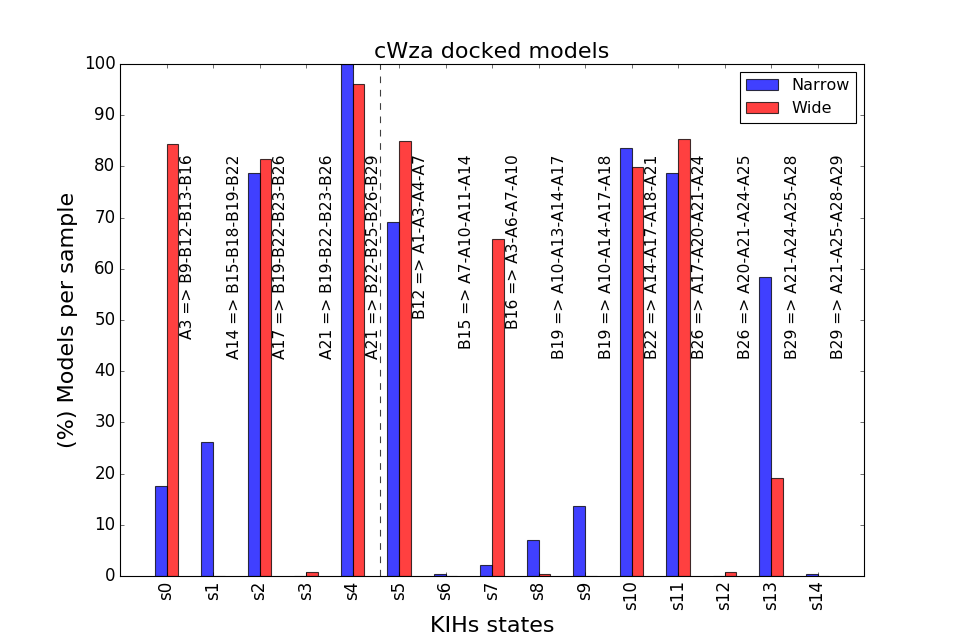

In [434]:
figgg_kihs = plt.figure(figsize=(12,8))

plt.bar(numpy.arange(len(nstates_kihs_narrow))-0.25,numpy.array(nstates_kihs_narrow)/len(models_narrow_bb),
        width=0.25,facecolor='blue',label='Narrow',alpha=0.75)
plt.bar(numpy.arange(len(nstates_kihs_wide)),numpy.array(nstates_kihs_wide)/len(models_wide_bb),width=0.25,
        facecolor='red',label='Wide',alpha=0.75)

plt.title('cWza docked models',fontsize=20)
plt.xlabel("KIHs states",fontsize=20)
plt.ylabel("(%) Models per sample",fontsize=20)
plt.xticks(numpy.arange(len(nstates_kihs_narrow)),
           ['s'+str(k) for k in numpy.arange(len(nstates_kihs_narrow))],rotation=90,fontsize=15)
plt.yticks(numpy.arange(0,1.1,0.1),numpy.arange(0,110,10),fontsize=15)
plt.xlim(-1,15)
#plt.ylim(0,1)

plt.legend()

for i in range(len(ordered_kihs_label)):
    plt.text(i+0.3,0.8,ordered_kihs_label[i],rotation=90,fontsize=14)

plt.plot((4.6,4.6),(0,1),linestyle='--',color='black',alpha=0.75)

plt.show()

## H-bonds MDEM structures

In [195]:
models_narrow_bb = [x.split("_INPUT_")[1][:4] for x in open('../md_relax/narrow/pdblist_narrow_original.txt').readlines()]

In [234]:
hbonds_em_narrow_bb = {}
for mn in models_narrow_bb:
    em_pdb = "../md_relax/narrow/output/refined1_0001_INPUT_"+mn+"_ignorechain/complex/em/em_20000stps.pdb"
    p = isambard_dev.ampal.convert_pdb_to_ampal(em_pdb)
    p_wh = isambard_dev.external_programs.assembly_plus_protons(p.pdb, path=False)
    hbonds = isambard_dev.interactions.find_hydrogen_bonds(p_wh)
    sc_hbonds = [str(hb) for hb in hbonds if hb.is_sidechain_sidechain == True]
    hbonds_em_narrow_bb['model_'+mn ] = sc_hbonds

In [207]:
models_wide_bb = [x.split("_INPUT_")[1][:4] for x in open('../md_relax/wide/pdblist_wide.txt').readlines()]

In [235]:
hbonds_em_wide_bb = {}
for mn in models_wide_bb:
    em_pdb = "../md_relax/wide/output/refined1_0001_INPUT_"+mn+"_ignorechain/complex/em/em_20000stps.pdb"
    try:
        p = isambard_dev.ampal.convert_pdb_to_ampal(em_pdb)
        p_wh = isambard_dev.external_programs.assembly_plus_protons(p.pdb, path=False)
        hbonds = isambard_dev.interactions.find_hydrogen_bonds(p_wh)
        sc_hbonds = [str(hb) for hb in hbonds if hb.is_sidechain_sidechain == True]
        hbonds_em_wide_bb['model_'+mn ] = sc_hbonds
    except:
        hbonds_em_wide_bb['model_'+mn ] = "NoFile"

Get Chain-COM-to-Complex-COM for all models after EM

In [187]:
com_em_all = {}
for mn in models_narrow_bb:
    com_em_all['model_'+mn] = []
    em_pdb = "../md_relax/narrow/output/refined1_0001_INPUT_"+mn+"_ignorechain/complex/em/em_20000stps_bb.pdb"
    try: 
        p = isambard_dev.ampal.convert_pdb_to_ampal(em_pdb)
        ccom = p.centre_of_mass
        for k in range(8):
            com_em_all['model_'+mn].append( numpy.linalg.norm(p[k].centre_of_mass - ccom) )
    except:
        com_em_all['model_'+mn] = "NoFile"

In [963]:
p = isambard_dev.ampal.convert_pdb_to_ampal(file)

In [965]:
len(p.sequences)

8

In [188]:
for mn in models_wide_bb:
    com_em_all['model_'+mn] = []
    em_pdb = "../md_relax/wide/output/refined1_0001_INPUT_"+mn+"_ignorechain/complex/em/em_20000stps_bb.pdb"
    try: 
        p = isambard_dev.ampal.convert_pdb_to_ampal(em_pdb)
        ccom = p.centre_of_mass
        for k in range(8):
            com_em_all['model_'+mn].append( numpy.linalg.norm(p[k].centre_of_mass - ccom) )
    except:
        com_em_all['model_'+mn] = "NoFile"

In [189]:
com_all = []

for mn in models_narrow_bb:
    data = com_em_all['model_'+mn]
    try:
        com_mean, com_std = [numpy.mean(data), numpy.std(data)]
        com_all.append(com_mean)
    except:
        print("NoFile")
        
for mn in models_wide_bb:
    data = com_em_all['model_'+mn]
    try:
        com_mean, com_std = [numpy.mean(data), numpy.std(data)]
        com_all.append(com_mean)
    except:
        print("NoFile")

NoFile


<IPython.core.display.Javascript object>


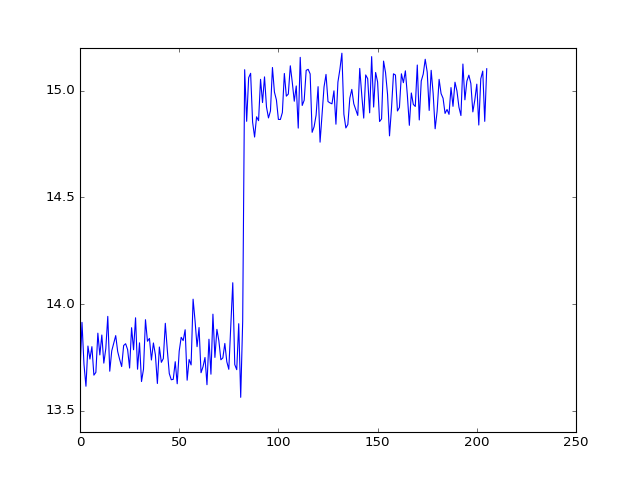

In [191]:
fig_em_com = plt.figure()
plt.plot(com_all)
plt.show()

## Conductance after MDEM

In [632]:
import re

In [641]:
G_narrow_em = []
for line in open('../md_relax/narrow/G_narrow.dat','r').readlines():
    if re.search(u'HOLE Gpred by Rmin',line):
        g = float(line.rstrip().split(":")[1])
        G_narrow_em.append(g)

In [647]:
G_narrow_em2 = []
for line in open('../md_relax/narrow/G_narrow_trial2.dat','r').readlines():
    if re.search(u'HOLE Gpred by Rmin',line):
        g = float(line.rstrip().split(":")[1])
        G_narrow_em2.append(g)

In [645]:
G_wide_em = []
for line in open('../md_relax/wide/G_wide.dat','r').readlines():
    if re.search(u'HOLE Gpred by Rmin',line):
        g = float(line.rstrip().split(":")[1])
        G_wide_em.append(g)

In [651]:
G_wide_em2 = []
for line in open('../md_relax/wide/G_wide_trial2.dat','r').readlines():
    if re.search(u'HOLE Gpred by Rmin',line):
        g = float(line.rstrip().split(":")[1])
        G_wide_em2.append(g)

<IPython.core.display.Javascript object>


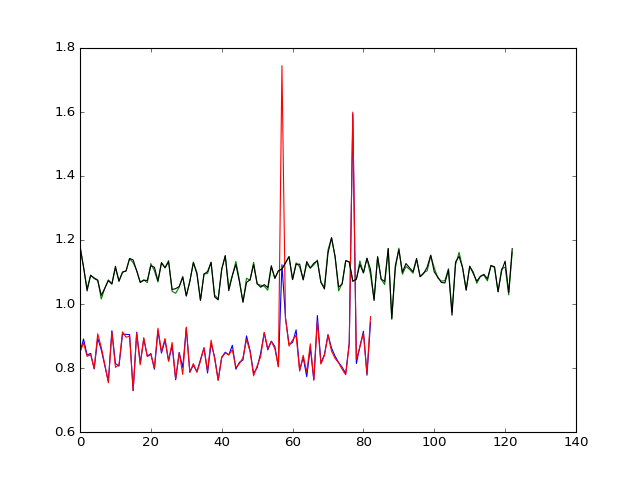

In [652]:
fig_G_narrow_em = plt.figure()

plt.plot(G_narrow_em,color='blue')
plt.plot(G_narrow_em2,color='red')
plt.plot(G_wide_em,color='green')
plt.plot(G_wide_em2,color='black')

plt.show()

## Analysing H-bonds from PRMD trajectories

In [700]:
chains = ['A','B','C','D','E','F','G','H']
chainc_ccwise = ['AB','BC','CD','DE','EF','FG','GH','HA']
chainc_cwise  = ['AH','HG','GF','FE','ED','DC','CB','BA']
chainc_intrachn = ['AA','BB','CC','DD','EE','FF','GG','HH']

In [893]:
def chain_direction(chain_combination):
    chainc_ccwise = ['AB','BC','CD','DE','EF','FG','GH','HA']
    chainc_cwise  = ['AH','HG','GF','FE','ED','DC','CB','BA']
    if chain_combination in chainc_cwise:
        return 1
    elif chain_combination in chainc_ccwise:
        return -1
    elif chain_combination in chainc_intrachn:
        return 0

In [726]:
path='../md_relax/narrow/output/refined1_0001_INPUT_0373_ignorechain/complex/mdf/prmd/'

In [844]:
n=0
file = path+'frame_'+str(n)+'.pdb'
p = isambard_dev.ampal.convert_pdb_to_ampal(file)
hbonds = isambard_dev.interactions.find_hydrogen_bonds(p)
sc_hbonds = [hb for hb in hbonds if hb.is_sidechain_sidechain == True]

In [847]:
hb = sc_hbonds[0]

In [852]:
hb

<Hydrogen Bond between (21E) HIS-HE2 ||||| OE1-GLU (25F)>

In [877]:
list(hb.acceptor.unique_id)

['F', '25', 3089]

In [863]:
hb.acceptor.res_label

'OE1'

In [882]:
hb.donor.ampal_parent.tags

{}

In [864]:
hb.donor.res_label

'HE2'

In [889]:
donor_H = [hb.donor.ampal_parent.id , hb.donor.res_label]
acceptor_O = [hb.acceptor.ampal_parent.id , hb.acceptor.res_label]
direction_HO = hb.donor.unique_id[0]+hb.acceptor.unique_id[0]

In [890]:
donor_H

['21', 'HE2']

In [891]:
acceptor_O

['25', 'OE1']

In [894]:
chain_direction(direction_HO)

-1

In [896]:
donor_H+acceptor_O+[direction_HO]

['21', 'HE2', '25', 'OE1', 'EF']

In [901]:
def get_Base_OH_atoms(path):
	hbonds_per_frame = {}
	n_frames = 100 # Number of trajectory frames
	for n in range(n_frames+1):
		file = path+'frame_'+str(n)+'.pdb'
		p = isambard_dev.ampal.convert_pdb_to_ampal(file)
		hbonds = isambard_dev.interactions.find_hydrogen_bonds(p)
		# Find all H-bonds and select those between sidechain atoms
		sc_hbonds_raw = [hb for hb in hbonds if hb.is_sidechain_sidechain == True]
		sc_hbonds_reduced = []
		for hb in sc_hbonds_raw:
			donor_H = [hb.donor.ampal_parent.id , hb.donor.res_label]
			acceptor_O = [hb.acceptor.ampal_parent.id , hb.acceptor.res_label]
			direction_HO = hb.donor.unique_id[0]+hb.acceptor.unique_id[0]
			hb_reduced = donor_H+acceptor_O+[direction_HO]
			data = json.dumps(hb_reduced)
			sc_hbonds_reduced.append( data )
		hbonds_per_frame['frame_'+str(n)] = sc_hbonds_reduced
	return hbonds_per_frame  


In [902]:
D = get_Base_OH_atoms(path)

In [908]:
def get_Base_KIHs(path):
    kihs_per_frame = {}
    n_frames = 100 # Number of trajectory frames
    for n in range(n_frames+1):
        file = path+'frame_'+str(n)+'.pdb'
        try:
            p = isambard_dev.ampal.convert_pdb_to_ampal(file)
            kihs_raw = isambard_dev.add_ons.knobs_into_holes.find_kihs(p)
            kihs_reduced = []
            for kih in kihs_raw:
                knob_data = ''.join(kih.knob.unique_id).rstrip()
                hole_data = [''.join(kih.hole[x].unique_id).rstrip() for x in range(len(kih.hole))]
                kih_direction = knob_data[0]+hole_data[0][0]
                kih_reduced = [knob_data[1:]]+[s[1:] for s in hole_data]+[kih_direction]
                data = json.dumps(kih_reduced)
                kihs_reduced.append(data)
            kihs_per_frame['frame_'+str(n)] = kihs_reduced
        except:
            kihs_per_frame['frame_'+str(n)] = 'NoFile'
    return kihs_per_frame

In [909]:
DD = get_Base_KIHs(path)

In [911]:
DD

{'frame_0': ['["17", "19", "22", "23", "26", "AB"]',
  '["21", "22", "25", "26", "29", "AB"]',
  '["19", "10", "13", "14", "17", "AH"]',
  '["22", "14", "17", "18", "21", "AH"]',
  '["26", "17", "20", "21", "24", "AH"]',
  '["29", "21", "24", "25", "28", "AH"]',
  '["12", "1", "3", "4", "7", "BA"]',
  '["22", "14", "17", "18", "21", "BA"]',
  '["26", "17", "20", "21", "24", "BA"]',
  '["29", "21", "24", "25", "28", "BA"]',
  '["3", "9", "12", "13", "16", "BC"]',
  '["14", "15", "18", "19", "22", "BC"]',
  '["17", "19", "22", "23", "26", "BC"]',
  '["21", "25", "22", "29", "26", "BC"]',
  '["12", "1", "3", "4", "7", "CB"]',
  '["15", "7", "10", "11", "14", "CB"]',
  '["22", "14", "17", "18", "21", "CB"]',
  '["26", "17", "20", "21", "24", "CB"]',
  '["29", "21", "24", "25", "28", "CB"]',
  '["3", "9", "12", "13", "16", "CD"]',
  '["14", "15", "18", "19", "22", "CD"]',
  '["17", "19", "22", "23", "26", "CD"]',
  '["21", "22", "25", "26", "29", "CD"]',
  '["15", "7", "10", "11", "14", "DC

In [912]:
def get_OH_atoms(file):
	try:
		p = isambard_dev.ampal.convert_pdb_to_ampal(file)
		hbonds = isambard_dev.interactions.find_hydrogen_bonds(p)
		# Find all H-bonds and select those between sidechain atoms
		sc_hbonds_raw = [hb for hb in hbonds if hb.is_sidechain_sidechain == True]
		sc_hbonds_reduced = []
		for hb in sc_hbonds_raw:
			donor_H = [hb.donor.ampal_parent.id , hb.donor.res_label]
			acceptor_O = [hb.acceptor.ampal_parent.id , hb.acceptor.res_label]
			direction_HO = hb.donor.unique_id[0]+hb.acceptor.unique_id[0]
			hb_reduced = donor_H+acceptor_O+[direction_HO]
			data = json.dumps(hb_reduced)
			sc_hbonds_reduced.append( data )
	except:
		sc_hbonds_reduced = 'NoFile'
	return sc_hbonds_reduced

In [915]:
file=path+'frame_10.pdb'
L = get_OH_atoms(file)

In [920]:
def get_KIHs(file):
    try:
        p = isambard_dev.ampal.convert_pdb_to_ampal(file)
        kihs_raw = isambard_dev.add_ons.knobs_into_holes.find_kihs(p)
        kihs_reduced = []
        for kih in kihs_raw:
            knob_data = ''.join(kih.knob.unique_id).rstrip()
            hole_data = [''.join(kih.hole[x].unique_id).rstrip() for x in range(len(kih.hole))]
            kih_direction = knob_data[0]+hole_data[0][0]
            kih_reduced = [knob_data[1:]]+[s[1:] for s in hole_data]+[kih_direction]
            data = json.dumps(kih_reduced)
            kihs_reduced.append(data)
    except:
        kihs_reduced = 'NoFile'
    return kihs_reduced

In [954]:
file=path+'frame_10.pdb'
LL = get_KIHs(file)

In [966]:
import analyse_HOLE

In [971]:
def get_HOLE(file):
	try:
		HOLE_dimensions,HOLE_conductance_estimates = analyse_HOLE.hole(file)
		return json.dumps(HOLE_dimensions+HOLE_conductance_estimates)
	except:
		return 'NoFile'

In [980]:
path = '../md_relax/narrow/output/refined1_0001_INPUT_0373_ignorechain/complex/mdf/prmd/'

'../md_relax/narrow/output/refined1_0001_INPUT_0373_ignorechain/complex/mdf/prmd/'

In [981]:
path = '../md_relax/prmd_test/'

In [972]:
D = 

((5.48854, 41.27),
 (4.6296835000000005, 0.82761595, 0.7055638300000001, 1.08173051))

In [976]:
x = get_HOLE(file)

In [979]:
json.loads(x)[0]

5.49235

In [982]:
def interactions_from_trajectory(path, n_frames, get_interaction):
	data_per_frame = []
	for n in range(n_frames+1):
		file = path+'frame_'+str(n)+'.pdb'
		data_per_frame.append(get_interaction(file))
	return data_per_frame

In [983]:
D = interactions_from_trajectory('../md_relax/prmd_test/', 10,get_HOLE)

In [987]:
D

['[5.57805, 41.28, 4.68476633, 0.83746272, 0.72567037, 1.0941987]',
 '[5.41378, 40.89, 4.6666467, 0.8342236000000001, 0.71703033, 1.09265038]',
 '[5.48061, 41.0, 4.65298049, 0.8317805899999999, 0.72074674, 1.08682281]',
 '[5.47431, 40.74, 4.62699088, 0.82713461, 0.69936973, 1.08444004]',
 '[5.38357, 40.79, 4.64416646, 0.83020497, 0.72518666, 1.08293235]',
 '[5.49296, 40.71, 4.72296241, 0.84429076, 0.7433943500000001, 1.0989910999999999]',
 '[5.45571, 40.56, 4.657274500000001, 0.8325482, 0.72723348, 1.08461615]',
 '[5.43572, 40.91, 4.63821231, 0.82914058, 0.7242569099999999, 1.08601112]',
 '[5.40943, 40.94, 4.61939603, 0.82577693, 0.70977026, 1.07958791]',
 '[5.51827, 41.23, 4.64657142, 0.83063488, 0.70813755, 1.0894028]',
 '[5.47667, 41.27, 4.6445953, 0.83028163, 0.71364213, 1.08416828]']

In [988]:
def get_COM_bb_distance(file):
	try:
		p = isambard_dev.ampal.convert_pdb_to_ampal(em_pdb)
		ccom = p.centre_of_mass
		n_chains = len(p.sequences)
		com_dd_distances = []
		for k in range(n_chains):
			com_dd_distances.append(numpy.linalg.norm(p[k].centre_of_mass - ccom))
		return json.dumps(com_dd_distances)
	except:
		return 'NoFile'

In [989]:
file

'../md_relax/prmd_test/frame_10.pdb'

In [990]:
get_COM_bb_distance(file)

'[14.866952204496272, 14.98724431568987, 15.039373628047406, 15.06033295981995, 14.847854358395917, 15.029550992781793, 15.077955861794628, 14.96512395454089]'

In [991]:
D = interactions_from_trajectory('../md_relax/prmd_test/', 100,get_COM_bb_distance)

In [994]:
D[0]

'[14.866952204496272, 14.98724431568987, 15.039373628047406, 15.06033295981995, 14.847854358395917, 15.029550992781793, 15.077955861794628, 14.96512395454089]'

In [926]:
path

'../md_relax/narrow/output/refined1_0001_INPUT_0373_ignorechain/complex/mdf/prmd/'

In [942]:
D = interactions_from_trajectory(path,100,get_OH_atoms)

In [943]:
D[0]

['["18", "HG1", "22", "OD2", "FG"]',
 '["18", "HG1", "22", "OD2", "EF"]',
 '["6", "HE1", "16", "OG1", "FG"]',
 '["6", "HE1", "16", "OG1", "CD"]',
 '["6", "HE1", "16", "OG1", "BC"]',
 '["29", "HH", "25", "OE2", "FF"]',
 '["18", "HG1", "22", "OD2", "GH"]',
 '["21", "HE2", "25", "OE1", "HA"]',
 '["21", "HE2", "25", "OE1", "DE"]',
 '["6", "HE1", "16", "OG1", "GH"]',
 '["29", "HH", "25", "OE2", "CC"]',
 '["29", "HH", "25", "OE2", "HH"]',
 '["29", "HH", "25", "OE2", "AA"]',
 '["21", "HE2", "25", "OE1", "BC"]',
 '["6", "HE1", "16", "OG1", "AB"]',
 '["29", "HH", "25", "OE2", "BB"]',
 '["21", "HE2", "25", "OE1", "EF"]',
 '["28", "HE", "32", "OG1", "GG"]',
 '["18", "HG1", "22", "OD2", "AB"]',
 '["18", "HG1", "22", "OD2", "BC"]',
 '["6", "HE1", "16", "OG1", "HA"]',
 '["21", "HE2", "25", "OE1", "GH"]',
 '["6", "HE1", "16", "OG1", "DE"]',
 '["18", "HG1", "22", "OD2", "CD"]',
 '["29", "HH", "25", "OE2", "EE"]',
 '["29", "HH", "25", "OE1", "DD"]',
 '["18", "HG1", "22", "OD2", "HA"]',
 '["18", "HG1", 

In [945]:
ls 

ABCchains/                          myscript_low.tcl
ABCchains_aligned/                  mytest.pdb
ABchains/                           out_high.txt
ABC_resmind.json                    out_low.txt
Achains/                            __pycache__/
align2_ref_chain.py*                README.md
align_chain_pdbs.py*                refined1.db
allchainsaligned                    refined1_interchn_scmc_hbonds.json
Analyse_Hbonds_SymDock.ipynb        refined1_kihs.json
Analyse_RmsdByRes_Chain2Chain.py*   refined1_mc_hbonds.json
com_ABCchains_low-high_aligned.tcl  refined1_sc_hbonds_ABC.json
com_ABCchains_low-high.tcl          refined1_sc_hbonds_AB.json
com_ABCchains_low.tcl               refined1_sc_hbonds.json
com_Achains_high.tcl                refined1_scmc_hbonds.json
com_Achains_low-high.tcl            renumber_chains.py*
com_Achains_low.tcl                 rigid_body_parameters.tcl
create_ABCchain_pdbs_aligned.py*    rmsdByRes_data/
create_ABCchain_pdbs.py*            RmsdByResidue.py*
c

In [729]:
import operator

In [731]:
xxxx = get_Base_OH_atoms(path)

In [732]:
xxxx

'["[\'1-ALA-H2 ||| NH1-ARG-5\', 0]", "[\'21-HIS-HE2 ||| OE2-GLU-25\', -1]", "[\'6-TRP-HE1 ||| OG1-THR-16\', -1]", "[\'29-TYR-HH ||| NH1-ARG-28\', 0]", "[\'29-TYR-HH ||| OE1-GLU-25\', 0]", "[\'21-HIS-HE2 ||| OE1-GLU-25\', 0]", "[\'29-TYR-HH ||| OE2-GLU-25\', 1]", "[\'28-ARG-HE ||| OG1-THR-32\', 0]", "[\'21-HIS-HE2 ||| OE1-GLU-25\', -1]", "[\'18-THR-HG1 ||| OD2-ASP-22\', -1]", "[\'11-SER-HG ||| OD1-ASN-7\', 0]", "[\'29-TYR-HH ||| OE2-GLU-25\', 0]"]'

In [713]:
all_hbonds_prmd_protein = []
path='../md_relax/narrow/output/refined1_0001_INPUT_0373_ignorechain/complex/mdf/prmd/'

for n in range(101):
    file = path+'frame_'+str(n)+'.pdb'
    p = isambard_dev.ampal.convert_pdb_to_ampal(file)
    # Find all H-bonds and select those between sidechain atoms
    hbonds = isambard_dev.interactions.find_hydrogen_bonds(p)
    sc_hbonds = [str(hb) for hb in hbonds if hb.is_sidechain_sidechain == True]
    all_hbonds_prmd_protein = all_hbonds_prmd_protein + sc_hbonds

In [714]:
print("Total number of H-bonds: ",len(all_hbonds_prmd_protein))
print("Total number of H-bonds types: ",len(set(all_hbonds_prmd_protein)))

Total number of H-bonds:  3022
Total number of H-bonds types:  43


In [689]:
print("Total number of H-bonds: ",len(all_hbonds_prmd_protein))
print("Total number of H-bonds types: ",len(set(all_hbonds_prmd_protein)))

Total number of H-bonds:  2282
Total number of H-bonds types:  40


In [715]:
S_hbonds_pdb = set(all_hbonds_prmd_protein)

In [716]:
set(all_hbonds_prmd_protein)

{'<Hydrogen Bond between (11A) SER-HG ||||| OD1-ASN (7A)>',
 '<Hydrogen Bond between (11D) SER-HG ||||| OD1-ASN (7D)>',
 '<Hydrogen Bond between (18A) THR-HG1 ||||| OD2-ASP (22B)>',
 '<Hydrogen Bond between (18B) THR-HG1 ||||| OD2-ASP (22C)>',
 '<Hydrogen Bond between (18C) THR-HG1 ||||| OD2-ASP (22D)>',
 '<Hydrogen Bond between (18D) THR-HG1 ||||| OD2-ASP (22E)>',
 '<Hydrogen Bond between (18E) THR-HG1 ||||| OD2-ASP (22F)>',
 '<Hydrogen Bond between (18F) THR-HG1 ||||| OD2-ASP (22G)>',
 '<Hydrogen Bond between (18G) THR-HG1 ||||| OD2-ASP (22H)>',
 '<Hydrogen Bond between (18H) THR-HG1 ||||| OD2-ASP (22A)>',
 '<Hydrogen Bond between (1H) ALA-H2 ||||| NH1-ARG (5H)>',
 '<Hydrogen Bond between (21A) HIS-HE2 ||||| OE1-GLU (25B)>',
 '<Hydrogen Bond between (21B) HIS-HE2 ||||| OE1-GLU (25C)>',
 '<Hydrogen Bond between (21D) HIS-HE2 ||||| OE1-GLU (25E)>',
 '<Hydrogen Bond between (21E) HIS-HE2 ||||| OE1-GLU (25F)>',
 '<Hydrogen Bond between (21F) HIS-HE2 ||||| OE1-GLU (25F)>',
 '<Hydrogen Bon

In [717]:
from operator import itemgetter

all_HO_pdb = []
for resn in range(1,33):
    for x in list(S_hbonds_pdb):
        a,b,c,d = itemgetter(*[3,4,6,7])(x.split(' '))
        resn_H, resn_O = a.split(')')[0].split('(')[1][:-1], d.split('(')[1].split(')')[0][:-1]
        chn_H, chn_O = a.split(')')[0].split('(')[1][-1],d.split('(')[1].split(')')[0][-1]
        HO_direction = chn_H + chn_O
        if int(resn_H) == resn:
#             print(resn_H+'-'+b+' ||| '+c+'-'+resn_O)
            all_HO_pdb.append(str([resn_H+'-'+b+' ||| '+c+'-'+resn_O, interaction_direction(HO_direction)]))

In [718]:
set(all_HO_pdb)

{"['1-ALA-H2 ||| NH1-ARG-5', 0]",
 "['11-SER-HG ||| OD1-ASN-7', 0]",
 "['18-THR-HG1 ||| OD2-ASP-22', -1]",
 "['21-HIS-HE2 ||| OE1-GLU-25', -1]",
 "['21-HIS-HE2 ||| OE1-GLU-25', 0]",
 "['21-HIS-HE2 ||| OE2-GLU-25', -1]",
 "['28-ARG-HE ||| OG1-THR-32', 0]",
 "['29-TYR-HH ||| NH1-ARG-28', 0]",
 "['29-TYR-HH ||| OE1-GLU-25', 0]",
 "['29-TYR-HH ||| OE2-GLU-25', 0]",
 "['29-TYR-HH ||| OE2-GLU-25', 1]",
 "['6-TRP-HE1 ||| OG1-THR-16', -1]"}

In [719]:
xx = list(set(all_HO_pdb))

In [721]:
import json

json.dumps(xx)

'["[\'1-ALA-H2 ||| NH1-ARG-5\', 0]", "[\'21-HIS-HE2 ||| OE2-GLU-25\', -1]", "[\'6-TRP-HE1 ||| OG1-THR-16\', -1]", "[\'29-TYR-HH ||| NH1-ARG-28\', 0]", "[\'29-TYR-HH ||| OE1-GLU-25\', 0]", "[\'21-HIS-HE2 ||| OE1-GLU-25\', 0]", "[\'29-TYR-HH ||| OE2-GLU-25\', 1]", "[\'28-ARG-HE ||| OG1-THR-32\', 0]", "[\'21-HIS-HE2 ||| OE1-GLU-25\', -1]", "[\'18-THR-HG1 ||| OD2-ASP-22\', -1]", "[\'11-SER-HG ||| OD1-ASN-7\', 0]", "[\'29-TYR-HH ||| OE2-GLU-25\', 0]"]'

In [712]:
set(all_HO_pdb)

{"['1-ALA-H2 ||| NH1-ARG-5', 0]",
 "['11-SER-HG ||| OD1-ASN-7', 0]",
 "['18-THR-HG1 ||| OD2-ASP-22', -1]",
 "['21-HIS-HE2 ||| OH-TYR-29', -1]",
 "['29-TYR-HH ||| OE2-GLU-25', 0]",
 "['29-TYR-HH ||| OE2-GLU-25', 1]",
 "['6-TRP-HE1 ||| OG1-THR-16', -1]"}

## HB stuff

In [249]:
all_hbs_em_narrow = []
for key in list(hbonds_em_narrow_bb.keys()):
    hbs = hbonds_em_narrow_bb[key]
    for hb in hbs:
        all_hbs_em_narrow.append(hb)

In [251]:
S_hbonds_em_narrow = set(all_hbs_em_narrow)

In [256]:
all_hbs_em_wide = []
for key in list(hbonds_em_wide_bb.keys()):
    hbs = hbonds_em_wide_bb[key]
    if hbs != "NoFile":
        for hb in hbs:
            all_hbs_em_wide.append(hb)

In [257]:
S_hbonds_em_wide = set(all_hbs_em_wide)

### H-O atoms for post-MDEM structures

In [441]:
three_letter ={'V':'VAL', 'I':'ILE', 'L':'LEU', 'E':'GLU', 'Q':'GLN', \
'D':'ASP', 'N':'ASN', 'H':'HIS', 'W':'TRP', 'F':'PHE', 'Y':'TYR',    \
'R':'ARG', 'K':'LYS', 'S':'SER', 'T':'THR', 'M':'MET', 'A':'ALA',    \
'G':'GLY', 'P':'PRO', 'C':'CYS'}

In [425]:
seq = 'APLVRWNRVISQLVPTITGVHDLTETVRYIKT'
seq_num = [str(i+1)+'-'+three_letter[seq[i]] for i in range(len(seq))]

In [449]:
def extract_OH_info(x):
    a,b,c,d = itemgetter(*[3,4,6,7])(x.split(' '))
    resn_H, resn_O = a.split(')')[0].split('(')[1][:-1], d.split('(')[1].split(')')[0][:-1]
    return resn_H+'-'+b+' ||| '+c+'-'+resn_O

Simplified set of interchain H-bonds for all post-MDEM docked structures (wide)

In [426]:
len(list(S_hbonds_em_narrow))

191

In [402]:
len(list(S_hbonds_em_wide))

174

This set of data included all interchain H-bonds

In [427]:
list(S_hbonds_em_narrow)

['<Hydrogen Bond between (28C) ARG-HH21 ||||| OG1-THR (32C)>',
 '<Hydrogen Bond between (28A) ARG-HH12 ||||| OE2-GLU (25A)>',
 '<Hydrogen Bond between (18C) THR-HG1 ||||| OD1-ASP (22D)>',
 '<Hydrogen Bond between (29E) TYR-HH ||||| OE1-GLU (25E)>',
 '<Hydrogen Bond between (28F) ARG-HH22 ||||| OH-TYR (29G)>',
 '<Hydrogen Bond between (28A) ARG-HH21 ||||| OG1-THR (32A)>',
 '<Hydrogen Bond between (28C) ARG-HH12 ||||| OH-TYR (29C)>',
 '<Hydrogen Bond between (21H) HIS-HE2 ||||| OE1-GLU (25A)>',
 '<Hydrogen Bond between (28C) ARG-HH11 ||||| OH-TYR (29C)>',
 '<Hydrogen Bond between (6E) TRP-HE1 ||||| OG1-THR (16F)>',
 '<Hydrogen Bond between (18E) THR-HG1 ||||| OD2-ASP (22F)>',
 '<Hydrogen Bond between (28H) ARG-HH21 ||||| OG1-THR (32H)>',
 '<Hydrogen Bond between (12E) GLN-HE21 ||||| OG-SER (11E)>',
 '<Hydrogen Bond between (28G) ARG-HH12 ||||| OE1-GLU (25G)>',
 '<Hydrogen Bond between (28H) ARG-HH12 ||||| OE2-GLU (25H)>',
 '<Hydrogen Bond between (21F) HIS-HE2 ||||| OE1-GLU (25G)>',
 '<H

In [400]:
list(S_hbonds_em_wide)

['<Hydrogen Bond between (28B) ARG-HH22 ||||| OE2-GLU (25B)>',
 '<Hydrogen Bond between (28G) ARG-HH12 ||||| OG1-THR (32G)>',
 '<Hydrogen Bond between (18C) THR-HG1 ||||| OD1-ASP (22D)>',
 '<Hydrogen Bond between (29E) TYR-HH ||||| OE1-GLU (25E)>',
 '<Hydrogen Bond between (21H) HIS-HE2 ||||| OE1-GLU (25A)>',
 '<Hydrogen Bond between (12F) GLN-HE21 ||||| N-ALA (1E)>',
 '<Hydrogen Bond between (28H) ARG-HH22 ||||| OH-TYR (29A)>',
 '<Hydrogen Bond between (18E) THR-HG1 ||||| OD2-ASP (22F)>',
 '<Hydrogen Bond between (6E) TRP-HE1 ||||| OG1-THR (16F)>',
 '<Hydrogen Bond between (28H) ARG-HH21 ||||| OG1-THR (32H)>',
 '<Hydrogen Bond between (28H) ARG-HH12 ||||| OE2-GLU (25H)>',
 '<Hydrogen Bond between (21F) HIS-HE2 ||||| OE1-GLU (25G)>',
 '<Hydrogen Bond between (6D) TRP-HE1 ||||| OG1-THR (16E)>',
 '<Hydrogen Bond between (7H) ASN-HD22 ||||| OE1-GLN (12A)>',
 '<Hydrogen Bond between (18D) THR-HG1 ||||| OD1-ASP (22E)>',
 '<Hydrogen Bond between (21G) HIS-HE2 ||||| OE1-GLU (25G)>',
 '<Hydrog

In [428]:
from operator import itemgetter

all_HO_atoms_narrow = []
for resn in range(1,33):
    for x in list(S_hbonds_em_narrow):
        a,b,c,d = itemgetter(*[3,4,6,7])(x.split(' '))
        resn_H, resn_O = a.split(')')[0].split('(')[1][:-1], d.split('(')[1].split(')')[0][:-1]
        if int(resn_H) == resn:
#             print(resn_H+'-'+b+' ||| '+c+'-'+resn_O)
            all_HO_atoms_narrow.append(resn_H+'-'+b+' ||| '+c+'-'+resn_O)

In [422]:
from operator import itemgetter

all_HO_atoms_wide = []
for resn in range(1,33):
    for x in list(S_hbonds_em_wide):
        a,b,c,d = itemgetter(*[3,4,6,7])(x.split(' '))
        resn_H, resn_O = a.split(')')[0].split('(')[1][:-1], d.split('(')[1].split(')')[0][:-1]
        if int(resn_H) == resn:
#             print(resn_H+'-'+b+' ||| '+c+'-'+resn_O)
            all_HO_atoms_wide.append(resn_H+'-'+b+' ||| '+c+'-'+resn_O)

In [423]:
def order_HO_atoms(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [429]:
order_HO_atoms(all_HO_atoms_narrow)

['1-ALA-H2 ||| NE-ARG-5',
 '5-ARG-HH21 ||| N-PRO-2',
 '6-TRP-HE1 ||| OG1-THR-16',
 '7-ASN-HD22 ||| OE1-GLN-12',
 '12-GLN-HE21 ||| OG-SER-11',
 '12-GLN-HE22 ||| OD1-ASN-7',
 '18-THR-HG1 ||| OD1-ASP-22',
 '18-THR-HG1 ||| OD2-ASP-22',
 '21-HIS-HE2 ||| OE1-GLU-25',
 '21-HIS-HE2 ||| OE2-GLU-25',
 '21-HIS-HD1 ||| N-ASP-22',
 '21-HIS-HD1 ||| OD1-ASP-22',
 '28-ARG-HH21 ||| OG1-THR-32',
 '28-ARG-HH12 ||| OE2-GLU-25',
 '28-ARG-HH22 ||| OH-TYR-29',
 '28-ARG-HH12 ||| OH-TYR-29',
 '28-ARG-HH11 ||| OH-TYR-29',
 '28-ARG-HH12 ||| OE1-GLU-25',
 '28-ARG-HE ||| OG1-THR-32',
 '28-ARG-HH11 ||| OE1-GLU-25',
 '28-ARG-HH22 ||| OE2-GLU-25',
 '28-ARG-HE ||| OE1-GLU-25',
 '28-ARG-HH21 ||| OE2-GLU-25',
 '28-ARG-HH21 ||| OE1-GLU-25',
 '28-ARG-HH11 ||| OE2-GLU-25',
 '28-ARG-HH21 ||| OH-TYR-29',
 '28-ARG-HH11 ||| OG1-THR-32',
 '28-ARG-HE ||| OE2-GLU-25',
 '29-TYR-HH ||| OE1-GLU-25',
 '29-TYR-HH ||| NE2-HIS-21',
 '29-TYR-HH ||| OE2-GLU-25']

In [424]:
order_HO_atoms(all_HO_atoms_wide)

['1-ALA-H2 ||| NE-ARG-5',
 '5-ARG-HH21 ||| N-PRO-2',
 '6-TRP-HE1 ||| OG1-THR-16',
 '7-ASN-HD22 ||| OE1-GLN-12',
 '7-ASN-HD22 ||| OG1-THR-16',
 '12-GLN-HE21 ||| N-ALA-1',
 '12-GLN-HE21 ||| OD1-ASN-7',
 '16-THR-HG1 ||| OD1-ASN-7',
 '18-THR-HG1 ||| OD1-ASP-22',
 '18-THR-HG1 ||| OD2-ASP-22',
 '21-HIS-HE2 ||| OE1-GLU-25',
 '21-HIS-HE2 ||| OE2-GLU-25',
 '21-HIS-HD1 ||| OD1-ASP-22',
 '26-THR-HG1 ||| ND1-HIS-21',
 '28-ARG-HH22 ||| OE2-GLU-25',
 '28-ARG-HH12 ||| OG1-THR-32',
 '28-ARG-HH22 ||| OH-TYR-29',
 '28-ARG-HH21 ||| OG1-THR-32',
 '28-ARG-HH12 ||| OE2-GLU-25',
 '28-ARG-HH11 ||| OE1-GLU-25',
 '28-ARG-HH21 ||| OE2-GLU-25',
 '28-ARG-HH11 ||| OE2-GLU-25',
 '28-ARG-HE ||| OG1-THR-32',
 '28-ARG-HH21 ||| OE1-GLU-25',
 '28-ARG-HE ||| OE2-GLU-25',
 '28-ARG-HH11 ||| OG1-THR-32',
 '28-ARG-HE ||| OE1-GLU-25',
 '28-ARG-HH11 ||| OH-TYR-29',
 '28-ARG-HH12 ||| OE1-GLU-25',
 '28-ARG-HH21 ||| OH-TYR-29',
 '29-TYR-HH ||| OE1-GLU-25',
 '29-TYR-HH ||| OE2-GLU-25']

In [430]:
S_narrow = set(order_HO_atoms(all_HO_atoms_narrow))
S_wide = set(order_HO_atoms(all_HO_atoms_wide))

In [437]:
print("Number of H-O atom pairs involved in H-bonds for Narrow models: ", len(S_narrow))
print("Number of H-O atom pairs involved in H-bonds for Wide models: ", len(S_wide))

Number of H-O atom pairs involved in H-bonds for Narrow models:  31
Number of H-O atom pairs involved in H-bonds for Wide models:  32


In [434]:
S_narrow.difference(S_wide)

{'12-GLN-HE21 ||| OG-SER-11',
 '12-GLN-HE22 ||| OD1-ASN-7',
 '21-HIS-HD1 ||| N-ASP-22',
 '28-ARG-HH12 ||| OH-TYR-29',
 '29-TYR-HH ||| NE2-HIS-21'}

In [435]:
S_wide.difference(S_narrow)

{'12-GLN-HE21 ||| N-ALA-1',
 '12-GLN-HE21 ||| OD1-ASN-7',
 '16-THR-HG1 ||| OD1-ASN-7',
 '26-THR-HG1 ||| ND1-HIS-21',
 '28-ARG-HH12 ||| OG1-THR-32',
 '7-ASN-HD22 ||| OG1-THR-16'}

**Order all HO-atoms from both narrow and wide models**

In [460]:
S_union = set(order_HO_atoms(all_HO_atoms_narrow)).union(set(order_HO_atoms(all_HO_atoms_wide)))

In [469]:
S_OH_atoms_all_ordered = []
for resn in range(1,33):
    for x in S_union:
        if int(x.split('-')[0]) == resn:
            S_OH_atoms_all_ordered.append(x)

Set of H-bonds per structure

Stats about OH-atoms per chain

In [482]:
num_HO_atoms_narrow = []
for hb_type in S_OH_atoms_all_ordered:
    #num_HO_atoms_narrow[hb_type] = []
    c = 0
    for mn in models_narrow_bb:
        data = hbonds_em_narrow_bb['model_'+mn]
        if data != "NoFile":
            for hb in data:
                ho_data = extract_OH_info(hb)
                if ho_data == hb_type:
                    c += 1
                    #print(ho_data)
    num_HO_atoms_narrow.append(c/float(8))

In [484]:
num_HO_atoms_wide = []
for hb_type in S_OH_atoms_all_ordered:
#     num_HO_atoms_wide[hb_type] = []
    c = 0
    for mn in models_wide_bb:
        data = hbonds_em_wide_bb['model_'+mn]
        if data != "NoFile":
            for hb in data:
                ho_data = extract_OH_info(hb)
                if ho_data == hb_type:
                    c += 1
                    #print(ho_data)
    num_HO_atoms_wide.append(c/8)

<IPython.core.display.Javascript object>


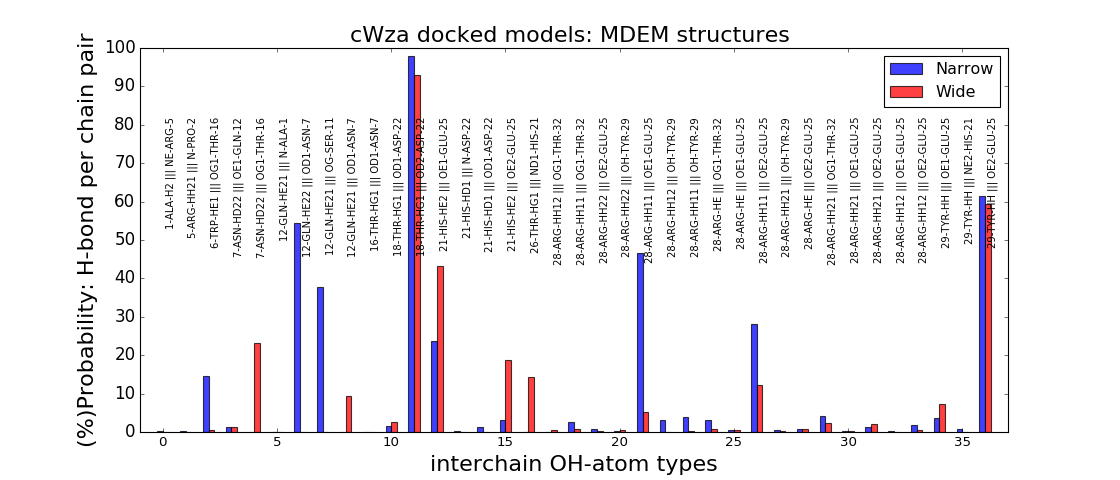

In [499]:
fig_hbonds_mdem = plt.figure(figsize=(14,6))

plt.bar(numpy.arange(len(num_HO_atoms_narrow))-0.25,numpy.array(num_HO_atoms_narrow)/len(models_narrow_bb),
        width=0.25,facecolor='blue',label='Narrow',alpha=0.75)

plt.bar(numpy.arange(len(num_HO_atoms_wide)),numpy.array(num_HO_atoms_wide)/len(models_wide_bb),width=0.25,
        facecolor='red',label='Wide',alpha=0.75)

plt.title('cWza docked models: MDEM structures ',fontsize=20)
plt.xlabel("interchain OH-atom types",fontsize=20)
plt.ylabel("(%)Probability: H-bond per chain pair",fontsize=20)
#plt.xticks(numpy.arange(len(nstates_narrow)),
#            ['s'+str(k) for k in numpy.arange(len(nstates_narrow))],rotation=90,fontsize=15)
plt.yticks(numpy.arange(0,1.1,0.1),numpy.arange(0,110,10),fontsize=15)
plt.xlim(-1,37)
#plt.ylim(0,1)

plt.legend()

for i in range(len(S_OH_atoms_all_ordered)):
    plt.text(i+0.1,0.8,S_OH_atoms_all_ordered[i],rotation=90,fontsize=9)

# plt.plot((12.75,12.75),(0,100),linestyle='--',color='black',alpha=0.75)

plt.show()

# KIHs after MDEM of narrow and wide structures

In [500]:
models_narrow_bb = [x.split("_INPUT_")[1][:4] for x in open('../md_relax/narrow/pdblist_narrow_original.txt').readlines()]

In [718]:
set(all_HO_pdb)

{"['1-ALA-H2 ||| NH1-ARG-5', 0]",
 "['11-SER-HG ||| OD1-ASN-7', 0]",
 "['18-THR-HG1 ||| OD2-ASP-22', -1]",
 "['21-HIS-HE2 ||| OE1-GLU-25', -1]",
 "['21-HIS-HE2 ||| OE1-GLU-25', 0]",
 "['21-HIS-HE2 ||| OE2-GLU-25', -1]",
 "['28-ARG-HE ||| OG1-THR-32', 0]",
 "['29-TYR-HH ||| NH1-ARG-28', 0]",
 "['29-TYR-HH ||| OE1-GLU-25', 0]",
 "['29-TYR-HH ||| OE2-GLU-25', 0]",
 "['29-TYR-HH ||| OE2-GLU-25', 1]",
 "['6-TRP-HE1 ||| OG1-THR-16', -1]"}

In [504]:
kihs_em_narrow_bb = {}
for mn in models_narrow_bb:
    kihs_em_narrow_bb['model_'+mn] = []
    em_pdb = "../md_relax/narrow/output/refined1_0001_INPUT_"+mn+"_ignorechain/complex/em/em_20000stps.pdb"
    p = isambard_dev.ampal.convert_pdb_to_ampal(em_pdb)
    kihs = isambard_dev.add_ons.knobs_into_holes.find_kihs(p)
    for k in range(len(kihs)):
        knob_data = ''.join(kihs[k].knob.unique_id).rstrip()
        hole_data = [''.join(kihs[k].hole[x].unique_id).rstrip() for x in range(len(kihs[k].hole))]
        kihs_em_narrow_bb['model_'+mn].append(str([knob_data, hole_data]))

In [506]:
models_wide_bb = [x.split("_INPUT_")[1][:4] for x in open('../md_relax/wide/pdblist_wide.txt').readlines()]

In [741]:
kihs_em_wide_bb = {}
for mn in models_wide_bb:
    kihs_em_wide_bb['model_'+mn] = []
    em_pdb = "../md_relax/wide/output/refined1_0001_INPUT_"+mn+"_ignorechain/complex/em/em_20000stps.pdb"
    try:
        p = isambard_dev.ampal.convert_pdb_to_ampal(em_pdb)
        kihs = isambard_dev.add_ons.knobs_into_holes.find_kihs(p)
        for k in range(len(kihs)):
            knob_data = ''.join(kihs[k].knob.unique_id).rstrip()
            hole_data = [''.join(kihs[k].hole[x].unique_id).rstrip() for x in range(len(kihs[k].hole))]
            #kihs_em_wide_bb['model_'+mn].append(str([knob_data, hole_data]))
            kih_direction = knob_data[0]+hole_data[0][0]
            kih_info = knob_data[1:]+'-'+'-'.join([s[1:] for s in hole_data])
            print(kih_info, interaction_direction(kih_direction))
    except:
        kihs_em_wide_bb['model_'+mn].append("NoFile") 

3-9-12-13-16 -1
17-19-22-23-26 -1
21-22-25-26-29 -1
12-1-3-4-7 1
16-3-6-7-10 1
19-10-13-14-17 1
22-14-17-18-21 1
26-17-20-21-24 1
16-3-6-7-10 1
19-10-13-14-17 1
22-14-17-18-21 1
26-17-20-21-24 1
29-21-24-25-28 1
3-9-12-13-16 -1
17-19-22-23-26 -1
21-22-25-26-29 -1
24-26-29-30-32 -1
12-1-3-4-7 1
16-3-6-7-10 1
19-10-13-14-17 1
22-14-17-18-21 1
26-17-20-21-24 1
29-21-24-25-28 1
3-9-12-13-16 -1
17-19-22-23-26 -1
21-22-25-26-29 -1
16-3-6-7-10 1
19-10-13-14-17 1
22-14-17-18-21 1
26-17-20-21-24 1
3-9-12-13-16 -1
17-19-22-23-26 -1
21-22-25-26-29 -1
12-1-3-4-7 1
16-3-6-7-10 1
19-10-13-14-17 1
22-14-17-18-21 1
26-17-20-21-24 1
29-21-24-25-28 1
3-9-12-13-16 -1
17-19-22-23-26 -1
21-22-25-26-29 -1
12-1-3-4-7 1
16-3-6-7-10 1
19-10-13-14-17 1
22-14-17-18-21 1
26-17-20-21-24 1
29-21-24-25-28 1
3-9-12-13-16 -1
17-19-22-23-26 -1
21-22-25-26-29 -1
12-1-3-4-7 1
16-3-6-7-10 1
19-10-13-14-17 1
22-14-17-18-21 1
26-17-20-21-24 1
29-21-24-25-28 1
3-9-12-13-16 -1
17-19-22-23-26 -1
21-22-25-26-29 -1
3-9-12-13-16 

Extract data per chain

In [ ]:
S_resi_em_all = []

for resn in range(1,33):
    for kih in S_kihs_em_union:
        x = kih.split("'")
        knob, hole= x[1], [x[3],x[5],x[7],x[9]]
        if int(knob[1:]) == resn:
            kih_direction = knob[0]+hole[0][0]
            kih_residues = knob[1:]+'-'+"-".join([s[1:] for s in hole])
            if kih_direction in chainc_ccwise:
                data = str([kih_residues,-1])
                if data not in S_resi_em_all:
                    S_resi_em_all.append(str([kih_residues,-1]))
            elif kih_direction in chainc_cwise:
                data = str([kih_residues,1])
                if data not in S_resi_em_all:
                    S_resi_em_all.append(str([kih_residues,1]))

In [544]:
all_kihs_em_narrow = []
for key in list(kihs_em_narrow_bb.keys()):
    kihs_em = kihs_em_narrow_bb[key]
    if kihs_em != "NoFile":
        for kih in kihs_em:
            all_kihs_em_narrow.append(kih)

In [548]:
all_kihs_em_wide = []
for key in list(kihs_em_wide_bb.keys()):
    kihs_em = kihs_em_wide_bb[key]
    if kihs_em[0] != 'NoFile':
        for kih in kihs_em:
            all_kihs_em_wide.append(kih)

In [551]:
S_kihs_em_narrow = set(all_kihs_em_narrow)

In [552]:
S_kihs_em_wide = set(all_kihs_em_wide)

In [556]:
S_kihs_em_union =  S_kihs_em_narrow.union(S_kihs_em_wide)

In [734]:
S_kihs_em_union

{"['A12', ['H1', 'H3', 'H4', 'H7']]",
 "['A14', ['B15', 'B18', 'B19', 'B22']]",
 "['A15', ['H7', 'H10', 'H11', 'H14']]",
 "['A16', ['H3', 'H6', 'H7', 'H10']]",
 "['A17', ['B19', 'B22', 'B23', 'B26']]",
 "['A17', ['B23', 'B19', 'B22', 'B26']]",
 "['A17', ['B23', 'B22', 'B19', 'B20']]",
 "['A19', ['H10', 'H13', 'H14', 'H17']]",
 "['A19', ['H10', 'H14', 'H17', 'H18']]",
 "['A19', ['H14', 'H17', 'H10', 'H13']]",
 "['A21', ['B21', 'B22', 'B25', 'B29']]",
 "['A21', ['B22', 'B25', 'B26', 'B29']]",
 "['A21', ['B22', 'B29', 'B25', 'B26']]",
 "['A21', ['B25', 'B22', 'B29', 'B26']]",
 "['A22', ['H14', 'H17', 'H18', 'H21']]",
 "['A26', ['H17', 'H20', 'H21', 'H24']]",
 "['A29', ['H21', 'H24', 'H25', 'H28']]",
 "['A3', ['B9', 'B12', 'B13', 'B16']]",
 "['B12', ['A1', 'A3', 'A4', 'A7']]",
 "['B14', ['C15', 'C18', 'C19', 'C22']]",
 "['B15', ['A7', 'A10', 'A11', 'A14']]",
 "['B16', ['A3', 'A6', 'A7', 'A10']]",
 "['B17', ['C19', 'C22', 'C23', 'C26']]",
 "['B19', ['A10', 'A13', 'A14', 'A17']]",
 "['B19', 

Define direction of KIHs accoridng to chain order, seen from C-terminus.

In [581]:
chains = ['A','B','C','D','E','F','G','H']
chainc_ccwise = ['AB','BC','CD','DE','EF','FG','GH','HA']
chainc_cwise  = ['AH','HG','GF','FE','ED','DC','CB','BA']

In [611]:
S_resi_em_all = []

for resn in range(1,33):
    for kih in S_kihs_em_union:
        x = kih.split("'")
        knob, hole= x[1], [x[3],x[5],x[7],x[9]]
        if int(knob[1:]) == resn:
            kih_direction = knob[0]+hole[0][0]
            kih_residues = knob[1:]+'-'+"-".join([s[1:] for s in hole])
            if kih_direction in chainc_ccwise:
                data = str([kih_residues,-1])
                if data not in S_resi_em_all:
                    S_resi_em_all.append(str([kih_residues,-1]))
            elif kih_direction in chainc_cwise:
                data = str([kih_residues,1])
                if data not in S_resi_em_all:
                    S_resi_em_all.append(str([kih_residues,1]))

In [614]:
S_resi_em_all

["['3-9-12-13-16', -1]",
 "['12-1-3-4-7', 1]",
 "['14-15-18-19-22', -1]",
 "['15-7-10-11-14', 1]",
 "['16-3-6-7-10', 1]",
 "['17-23-19-22-26', -1]",
 "['17-19-22-23-26', -1]",
 "['17-23-19-22-20', -1]",
 "['17-19-23-22-26', -1]",
 "['17-23-22-19-20', -1]",
 "['19-10-14-17-18', 1]",
 "['19-10-13-14-17', 1]",
 "['19-14-17-10-18', 1]",
 "['19-14-17-10-13', 1]",
 "['21-22-25-26-29', -1]",
 "['21-21-22-25-29', -1]",
 "['21-25-22-29-26', -1]",
 "['21-22-25-26-21', -1]",
 "['21-25-29-22-26', -1]",
 "['21-25-29-22-21', -1]",
 "['21-25-22-26-29', -1]",
 "['21-22-29-25-26', -1]",
 "['21-22-25-29-26', -1]",
 "['21-22-25-29-21', -1]",
 "['22-14-17-18-21', 1]",
 "['24-26-29-30-32', -1]",
 "['25-25-28-29-32', -1]",
 "['26-17-20-21-24', 1]",
 "['29-21-25-28-29', 1]",
 "['29-21-24-25-28', 1]",
 "['29-25-28-24-21', 1]"]

In [620]:
num_kihs_em_narrow = []

for kih_type in S_resi_em_all:
    c = 0
    for kih in all_kihs_em_narrow:
        x = kih.split("'")
        knob, hole= x[1], [x[3],x[5],x[7],x[9]]
        kih_direction = knob[0]+hole[0][0]
        kih_residues = knob[1:]+'-'+"-".join([s[1:] for s in hole])
        if kih_direction in chainc_ccwise:
            data = str([kih_residues,-1])
            if data == kih_type:
                c += 1
        elif kih_direction in chainc_cwise:
            data = str([kih_residues,1])
            if data == kih_type:
                c += 1
    num_kihs_em_narrow.append(c/8)

In [622]:
num_kihs_em_wide = []

for kih_type in S_resi_em_all:
    c = 0
    for kih in all_kihs_em_wide:
        x = kih.split("'")
        knob, hole= x[1], [x[3],x[5],x[7],x[9]]
        kih_direction = knob[0]+hole[0][0]
        kih_residues = knob[1:]+'-'+"-".join([s[1:] for s in hole])
        if kih_direction in chainc_ccwise:
            data = str([kih_residues,-1])
            if data == kih_type:
                c += 1
        elif kih_direction in chainc_cwise:
            data = str([kih_residues,1])
            if data == kih_type:
                c += 1
    num_kihs_em_wide.append(c/8)

<IPython.core.display.Javascript object>


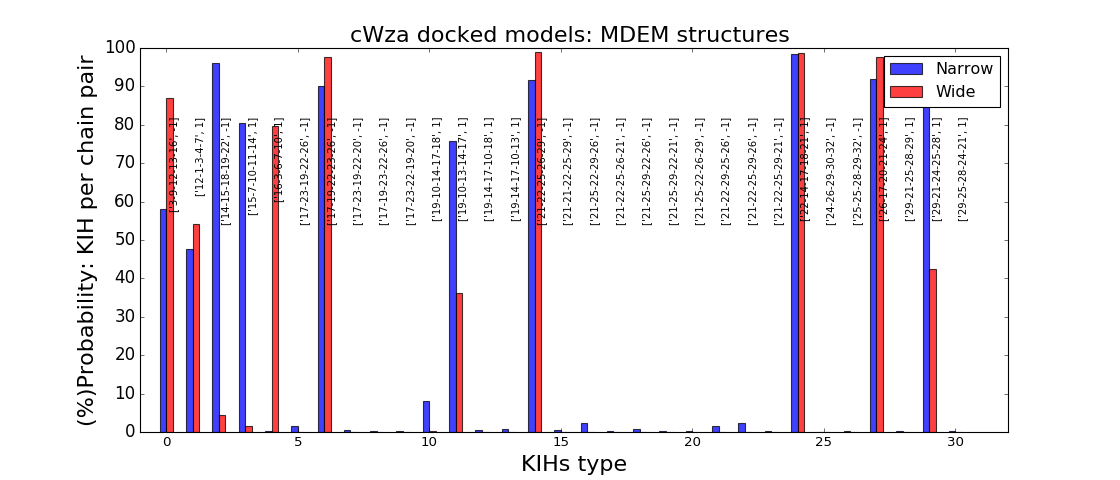

In [628]:
fig_kihs_mdem = plt.figure(figsize=(14,6))

plt.bar(numpy.arange(len(num_kihs_em_narrow))-0.25,numpy.array(num_kihs_em_narrow)/len(models_narrow_bb),
        width=0.25,facecolor='blue',label='Narrow',alpha=0.75)

plt.bar(numpy.arange(len(num_kihs_em_wide)),numpy.array(num_kihs_em_wide)/len(models_wide_bb),width=0.25,
        facecolor='red',label='Wide',alpha=0.75)

plt.title('cWza docked models: MDEM structures ',fontsize=20)
plt.xlabel("KIHs type",fontsize=20)
plt.ylabel("(%)Probability: KIH per chain pair",fontsize=20)
#plt.xticks(numpy.arange(len(nstates_narrow)),
#            ['s'+str(k) for k in numpy.arange(len(nstates_narrow))],rotation=90,fontsize=15)
plt.yticks(numpy.arange(0,1.1,0.1),numpy.arange(0,110,10),fontsize=15)
plt.xlim(-1,32)
#plt.ylim(0,1)

plt.legend(loc='best')

for i in range(len(S_resi_em_all)):
    plt.text(i+0.1,0.8,S_resi_em_all[i],rotation=90,fontsize=9)

# plt.plot((12.75,12.75),(0,100),linestyle='--',color='black',alpha=0.75)

plt.show()

# KIHs from MD trajectories

In [837]:
def get_Base_KIHs(path):
    all_kihs_prmd_protein = []
    n_frames = 100 # Number of trajectory frames
    for n in range(n_frames+1):
        file = path+'frame_'+str(n)+'.pdb'
        try:
            p = isambard_dev.ampal.convert_pdb_to_ampal(file)
            kihs = isambard_dev.add_ons.knobs_into_holes.find_kihs(p)
            for k in range(len(kihs)):
                knob_data = ''.join(kihs[k].knob.unique_id).rstrip()
                hole_data = [''.join(kihs[k].hole[x].unique_id).rstrip() for x in range(len(kihs[k].hole))]
                kih_direction = knob_data[0]+hole_data[0][0]
                kih_info = [knob_data[1:]]+[s[1:] for s in hole_data]+[interaction_direction(kih_direction)]
                data = json.dumps(kih_info)
                all_kihs_prmd_protein.append(data)
        except:
            all_kihs_prmd_protein.append('NoFile')
    
    return all_kihs_prmd_protein

In [827]:
yy

'["3", "9", "12", "13", "16", -1]'

In [828]:
y == yy

True

In [821]:
z = json.loads(y)

In [823]:
z[0]

'3'

In [829]:
X = [y,y,y]

In [832]:
Y = json.dumps(X)

In [836]:
json.loads(json.loads(Y)[0])[0]

'3'

# Inter-chain H-bonds : clockwise VS counter-clockwise

In [ ]:
hbs_AB = []
hbs_BA = []

for n in range(len(models_by_interchn_hbsn[1])):
    name, hb_data = models_by_interchn_hbsn[1][n]
    chn1,chn2,hb = hb_data[0]
    if chn1 == 'A':
        hbs_AB.append(hb)
    else:
        hbs_BA.append(hb)
        

In [ ]:
set(hbs_AB)

In [ ]:
set(hbs_BA)

**Observation**: There are more H-bonds from A to B, than from B to A.

Residues involved (A to B): THR, ASP, HIS, ARG, LYS, ASN, GLN

Residues involved (B to A): GLN, ASN, THR, HIS

In [ ]:
X_AB = []
X_BA = []

for n in range(len(models_by_interchn_hbsn[1])):
    name, hb_data = models_by_interchn_hbsn[1][n]
    chn1,chn2,hb = hb_data[0]
    if chn1 == 'A':
        num = name.split("_")[1]
        X_AB.append(Gpred_Rmin_all[ int(num)-1 ])
    else:
        num = name.split("_")[1]
        X_BA.append(Gpred_Rmin_all[ int(num)-1 ])

In [ ]:
plt.hist(rm_none(X_AB),bins=40,color='blue',histtype='step',label='H-bonds: A to B')
plt.hist(rm_none(X_BA),bins=40,color='red',histtype='step', label='H-bonds: B to A')
plt.legend()
plt.plot()

**Conclusion**:
This just exposes that fact that most docked models tend to have sidechains from A to B. However, directionality of the H-bonds cannot explain the difference in conductance.

In [ ]:

for n in range(len(models_by_interchn_hbsn[2])):
    name, hb_data = models_by_interchn_hbsn[2][n]
    for hb in hb_data:
        print(hb)
    print("&")

hello :D

Split structures by conductance and then look at their H-bonds, try to find a disctintive feature that characterises them 

# Intra-chain SC/MC H-bonds

In [ ]:
hb_scmc_all = {}
for n in range(1000):
    hb_scmc_all['model_'+format(n+1,'04d')] = []
    # Load chain PDB and convert to AMPAL object
    file = "Achains/ChainA_refined1_0001_INPUT_"+format(n+1,'04d')+"_ignorechain.pdb"
    p = isambard_dev.ampal.convert_pdb_to_ampal(file)
    # Add Hydrogens to structure, if not present
    p_wh = isambard_dev.external_programs.assembly_plus_protons(p.pdb, path=False)
    # Find all H-bonds and select those between sidechain atoms
    hbonds = isambard_dev.interactions.find_hydrogen_bonds(p_wh)
    for hb in hbonds:
        if (hb.is_sidechain_sidechain == False) and (hb.is_mainchain == False):
               hb_scmc_all['model_'+format(n+1,'04d')].append(str(hb))

In [ ]:
# Save H-bonds data in JSON file
with open('refined1_scmc_hbonds.json', 'w') as fp:
    json.dump(hb_scmc_all, fp)

In [ ]:
nhbs_scmc =[ len(hb_scmc_all['model_'+format(n+1,'04d')]) for n in range(1000)]

In [ ]:
fig = plt.figure()

plt.title('No. Sidechain H-bonds: cWza docked models', fontsize=20)
plt.xlabel("Number of SC-H-bonds", fontsize=15)
plt.ylabel("Absolute frequency", fontsize=15)
plt.hist(nhbs_scmc,color='cyan')

plt.show()

In [ ]:
hb_scmc_states = list(map(set, hb_scmc_all.values()))

In [ ]:
set.union(*hb_scmc_states)

In [ ]:
hb_scmc_combinations = list(set(list(map(str, [set(hb_scmc_all['model_'+format(n+1,'04d')]) for n in range(1000)]))))

In [ ]:
hb_scmc_combinations[0]

In [ ]:
for hbs in hb_scmc_combinations:
    print(hbs)

In [ ]:
len(hb_scmc_combinations)

In [ ]:
S_scmc = {}
for i in range(len(hb_scmc_combinations)):
    key = hb_scmc_combinations[i]
    S_scmc[key] = "s"+str(i)

In [ ]:
data_S_scmc = [ S_scmc[str(set(hb_scmc_all['model_'+format(n+1,'04d')]))] for n in range(1000) ]

In [ ]:
import pandas
from collections import Counter
letter_counts = Counter(data_S_scmc)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar',color='cyan')

**There only one most common type of intra-chain sidechain-mainchain H-bond**. This cannot distinguish between conductive states.

In [ ]:
hb_scmc_combinations[3]

# Inter-chain SC/MC H-bonds

In [ ]:
hbs_scmc_interchn = {}

for n in range(1000):
    hbs_scmc_interchn['model_'+format(n+1,'04d')] = []
    # Load chain PDB and convert to AMPAL object
    file = "ABchains/ChainAB_refined1_0001_INPUT_"+format(n+1,'04d')+"_ignorechain.pdb"
    p_AB = isambard_dev.ampal.convert_pdb_to_ampal(file)
    # Add Hydrogens to structure, if not present
    p_AB_wh = isambard_dev.external_programs.assembly_plus_protons(p_AB.pdb, path=False)
    # Find all H-bonds and select those between sidechain atoms
    hbonds_AB = isambard_dev.interactions.find_hydrogen_bonds(p_AB_wh)
    for hb in hbonds_AB:
        if (hb.is_sidechain_sidechain != True) and (hb.is_mainchain != True):
            x = str(hb).split("(")
            ch1,ch2 = x[1].split(")")[0][-1], x[-1].split(")")[0][-1]
            if ch1 != ch2:
                hbs_scmc_interchn['model_'+format(n+1,'04d')].append([ch1,ch2,str(hb)])

In [ ]:
# Save H-bonds data in JSON file
with open('refined1_interchn_scmc_hbonds.json', 'w') as fp:
    json.dump(hbs_scmc_interchn, fp)

In [ ]:
nhbs_scmc_AB_interchn = [len(hbs_scmc_interchn['model_'+format(n+1,'04d')]) for n in range(1000)]

In [ ]:
fig_AB_scmc_interchn = plt.figure()

plt.title('No. Interchain Sidechain H-bonds: cWza docked models', fontsize=20)
plt.xlabel("Number of IChn SCMC-H-bonds", fontsize=15)
plt.ylabel("Absolute frequency", fontsize=15)
plt.hist(nhbs_scmc_AB_interchn,color='orange', bins=numpy.arange(-1,4)+0.5,rwidth=0.75)
plt.xlim(-0.5,4)
plt.show()

In [ ]:
for n in range(200):
    print(n+1, hbs_scmc_interchn['model_'+format(n+1,'04d')])

In [ ]:
X = []; Y = []
for n in range(1000):
    if Gpred_Rmin_all[n] != "None":
        X.append(nhbs_scmc_AB_interchn[n])
        Y.append(Gpred_Rmin_all[n])

fig_scatter = plt.figure()
plt.scatter(X,Y)
#plt.xlim(-0.5,4.5)
plt.show()

In [ ]:
models_by_interchn_scmc_hbsn = {0:[],1:[],2:[],3:[]}

for n in range(1000):
    L = nhbs_scmc_AB_interchn[n]
    if L == 0:
        models_by_interchn_scmc_hbsn[0].append(['model_'+format(n+1,'04d'), hbs_scmc_interchn['model_'+format(n+1,'04d')]])
    elif L == 1:
        models_by_interchn_scmc_hbsn[1].append(['model_'+format(n+1,'04d'), hbs_scmc_interchn['model_'+format(n+1,'04d')]])
    elif L == 2:
        models_by_interchn_scmc_hbsn[2].append(['model_'+format(n+1,'04d'), hbs_scmc_interchn['model_'+format(n+1,'04d')]])
    elif L == 3:
        models_by_interchn_scmc_hbsn[3].append(['model_'+format(n+1,'04d'), hbs_scmc_interchn['model_'+format(n+1,'04d')]])

In [ ]:
colors = {0:'black',1:'blue',2:'red',3:'green'}

fig_interchn_hbs_hist = plt.figure()

for n in range(4):
    X = []
    for k in range(len(models_by_interchn_scmc_hbsn[n])):
        num = models_by_interchn_scmc_hbsn[n][k][0].split("_")[1]
        X.append(Gpred_Rmin_all[ int(num)-1 ])
    plt.hist(rm_none(X),bins=40,color=colors[n],histtype='step',linewidth=2)

plt.plot()

# Knobs-Into-Hobs interactions

In [ ]:
kihs_all = {}
for n in range(1000):
    kihs_all['model_'+format(n+1,'04d')] = []
    # Load chain PDB and convert to AMPAL object
    file = "ABchains/ChainAB_refined1_0001_INPUT_"+format(n+1,'04d')+"_ignorechain.pdb"
    p_AB = isambard_dev.ampal.convert_pdb_to_ampal(file)
    kihs = isambard_dev.add_ons.knobs_into_holes.find_kihs(p_AB)
    #kihs_all['model_'+format(n+1,'04d')] = set(kihs)
    for k in range(len(kihs)):
        knob_data = ''.join(kihs[k].knob.unique_id).rstrip()
        hole_data = [''.join(kihs[k].hole[x].unique_id).rstrip() for x in range(len(kihs[k].hole))]
        kihs_all['model_'+format(n+1,'04d')].append(str([knob_data, hole_data]))

In [ ]:
# Save KIHS data in JSON file
with open('refined1_kihs.json', 'w') as fp:
    json.dump(kihs_all, fp)

In [ ]:
# Generate list of sets
kihs_all_sets = [ set(kihs_all['model_'+format(n+1,'04d')]) for n in range(1000) ]

In [ ]:
set.union(*kihs_all_sets)

Set of all **17 possible KIHs** identified for all docked models. This implies that overall, there exist **131, 072** possible combinations of KIHs.

In [ ]:
kihs_combinations = list((set(list(map(str, [set(kihs_all['model_'+format(n+1,'04d')]) for n in range(1000)])))))

In [ ]:
print("However, there are only ", len(kihs_combinations), "possible combinations identified for all docked models")

In [ ]:
kihs_combinations[0]

We can also ask which are the most likely combinations shown by all structures.

In [ ]:
# KIHs states
S_kihs = {}
for i in range(len(kihs_combinations)):
    key = kihs_combinations[i]
    S_kihs[key] = "s"+str(i)

In [ ]:
S_kihs.values()

In [ ]:
data_S_kihs = [ S_kihs[str(set(kihs_all['model_'+format(n+1,'04d')]))] for n in range(1000) ]

In [ ]:
import pandas
from collections import Counter
letter_counts = Counter(data_S_kihs)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar',color='magenta')


In [ ]:
kihs_combinations[74]

In [ ]:
len(S_kihs.values())

In [ ]:
models_by_kihs_state = {}
for val in list(S_kihs.values()):
    models_by_kihs_state[val] = []
    for n in range(1000):
        if S_kihs[ str(kihs_all_sets[n]) ] == val:
            models_by_kihs_state[val].append("model_"+format(n+1,'04d'))

In [ ]:
len(models_by_kihs_state['s74'])

In [ ]:
X = []
state = 's74'
for n in range(len(models_by_kihs_state[state])):
    num = models_by_kihs_state[state][n].split("_")[1]
    #print(num)
    X.append(Gpred_Rmin_all[ int(num)-1 ])

In [ ]:
fig = plt.figure()
plt.hist(rm_none(X),bins=40,color='green')
plt.plot()

In [ ]:
models_by_kihs_state[state]

In [ ]:
kihs_combinations[74]

# Salt-bridges

In [ ]:
sbridges_all = {}
for n in range(1000):
    kihs_all['model_'+format(n+1,'04d')] = []
    # Load chain PDB and convert to AMPAL object
    file = "ABchains/ChainAB_refined1_0001_INPUT_"+format(n+1,'04d')+"_ignorechain.pdb"
    p_AB = isambard_dev.ampal.convert_pdb_to_ampal(file)
    sbridges = isambard_dev.interactions.find_salt_bridges(p_AB)
    sbridges_all['model_'+format(n+1,'04d')] = sbridges

In [ ]:
models_wsbridges = [n for n in range(1000) if len(sbridges_all['model_'+format(n+1,'04d')]) != 0]

In [ ]:
X = []
for n in models_wsbridges:
    X.append(Gpred_Rmin_all[n])

In [ ]:
fig = plt.figure()
plt.hist(rm_none(X),bins=40,color='green')
plt.plot()

# Conductance separation and structural features

In [ ]:
X = rm_none(Gpred_Rmin_all)
plt.hist(X,bins=40)
plt.plot()

In [ ]:
# Mode 1
G_mean_low = 0.932712
std1 = 0.097144
# Mode 2
G_mean_high = 1.267678
std2 = 0.076495


In [ ]:
Isc_all = []
for id in model_ids:
    try:
        model_Isc = session.query(RosettaMP_Energies.I_sc).filter_by(id = id).one()
        Isc_all.append(model_Isc[0])
    except:
        Isc_all.append("None")

In [ ]:
models_G_low = []
models_G_high = []

Isc_G_low = []
Isc_G_high = []

for n in range(1000):
        G = Gpred_Rmin_all[n]
        if G != "None":
            if (G >= G_mean_low - 0.5*std1) and (G <= G_mean_low + 0.5*std1):
                models_G_low.append(n)
                Isc_G_low.append(Isc_all[n])
            elif ( G >= G_mean_high - 0.5*std2 ) and (G <= G_mean_high + 0.5*std2 ):
                models_G_high.append(n)
                Isc_G_high.append(Isc_all[n])

In [ ]:
sorted_data_low  = sorted(  list(zip(models_G_low, Isc_G_low)), key=lambda x: x[1])
sorted_data_high = sorted(list(zip(models_G_high, Isc_G_high)), key=lambda x: x[1])

In [ ]:
Gpred_Rmin_all[999]

In [ ]:
for n in models_G_low:
    print(Gpred_Rmin_all[n])

In [ ]:
sorted_indeces_low = [x[0] for x in sorted_data_low]
sorted_indeces_high = [x[0] for x in sorted_data_high]

In [ ]:
for i in sorted_indeces_high:
    #print(format(i+1,'04d'))
    print(Gpred_Rmin_all[i])

In [ ]:
for i in sorted_indeces_high:
    print(format(i+1,'04d'))

In [ ]:
from operator import itemgetter

In [ ]:
union_kihs_low = set.union(*list(itemgetter(*sorted_indeces_low[:100])(kihs_all_sets)))

In [ ]:
union_kihs_high = set.union(*list(itemgetter(*sorted_indeces_high[:100])(kihs_all_sets)))

In [ ]:
union_kihs_low

In [ ]:
union_kihs_high

In [ ]:
set(union_kihs_low) - set(union_kihs_high)

In [ ]:
c=0
for kih in list(itemgetter(*sorted_indeces_low[:100])(kihs_all_sets)):
    if "['B19', ['A10', 'A13', 'A14', 'A17']]" in kih:
        c = c +1

In [ ]:
print(c)

In [ ]:
data_S_kihs_low=[S_kihs[str(set(kihs_all['model_'+format(n+1,'04d')]))] for n in sorted_indeces_low[0:100] ]

In [ ]:
data_S_kihs_high=[S_kihs[str(set(kihs_all['model_'+format(n+1,'04d')]))] for n in sorted_indeces_high[0:100] ]

In [ ]:
hist_num_L = []
for state in ['s'+str(n) for n in range(len(S_kihs.keys()))]:
    counter = 0
    for n in sorted_indeces_low:
        kihs = str(set(kihs_all['model_'+format(n+1,'04d')]))
        if S_kihs[kihs] == state:
            counter = counter + 1
    hist_num_L.append(counter)

In [ ]:
hist_num_H = []
for state in ['s'+str(n) for n in range(len(S_kihs.keys()))]:
    counter = 0
    for n in sorted_indeces_high:
        kihs = str(set(kihs_all['model_'+format(n+1,'04d')]))
        if S_kihs[kihs] == state:
            counter = counter + 1
    hist_num_H.append(counter)

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

ax.bar(range(len(S_kihs.values())), hist_num_L, width=0.5, facecolor='blue')
ax.bar(range(len(S_kihs.values())), hist_num_H, width=0.5, facecolor='red', alpha=0.5)
ax.set_xticks(range(len(S_kihs.values())))
ax.set_xticklabels(['s'+str(n) for n in range(len(S_kihs.keys()))],rotation=90,fontsize=10)
ax.xaxis.set_tick_params('center')

plt.plot()

H-bonds

One can distinguish H-bonds among 6 different group types:
1. Intra-chain Mainchain-Mainchain (Mostly backbone atoms, fixed number: 35)
2. Intra-chain Sidechain-Sidechain (1 or 2 H-bonds, single dominant state for (4 states) 1- and (4 states) 2-H-bond structures)
3. Intra-chain Sidechain-Mainchain (Mostly 4 H-bonds, single dominant H-bond state out of 12 states)
4. Inter-chain Sidechain-Sidechain (0-4 H-bonds, no single dominant number. **Need to analayse all of these** )
5. Inter-chain Sidehcain-Mainchain (0-3 H-bonds; moslty 0(~ 700 models) and 1(~ 200 models) are dominant numbers. )
6. Inter-chain Mainchain-Mainchain (?)

**Position of these H-bonds ALONG THE SEQUENCE AND CHAIN IS IMPORTANT FOR INTERPRETATION**

## Inter-chain Sidechain-Sidechain H-bonds

In [ ]:
hbs_interchn['model_0002']

In [ ]:
for n in range(5):
    print("Number of models with "+str(n)+" H-bonds: ",len(models_by_interchn_hbsn[n]))

In [ ]:
interchn_states = {}
for k in range(1,5):
    interchn_states[k] = list(
        set([ str(set(map(str, models_by_interchn_hbsn[k][n][1]))) for n in range(len(models_by_interchn_hbsn[k])) ]))
    print("Number of H-bond states for "+str(k)+" H-bonds: ", len(interchn_states[k]))

In [ ]:
interchn_states[1]

If we have a look at the union set of all possible H-bonds identified for all structures, we see that in comparison to the 1 single state H-bond structures, there 19 different H-bonds, not 16.

In [ ]:
all_interchn_hbonds = list(set.union(*[set([vv[2] for vv in v ]) for v in hbs_interchn.values()]))

In [ ]:
len(all_interchn_hbonds)

In [ ]:
all_interchn_hbonds

So, all possible H-bond states can be decomposed in terms of this cannonical set of H-bonds.

In [ ]:
S_interchn_hbonds = {}
for k in range(len(all_interchn_hbonds)):
    key = all_interchn_hbonds[k]
    S_interchn_hbonds[key] = k

In [ ]:
nhbs_colors = {0:'white',1:'blue',2:'green',3:'red',4:'black'}

heatmap_data = []

for n in range(1000):
    data = hbs_interchn['model_'+format(n+1,'04d')]
    nhbs = len(data)
    vec = numpy.zeros(19, dtype=int)
    for m in data:
        index = S_interchn_hbonds[ m[2] ]
        vec[index] = nhbs
    heatmap_data.append(vec)
    

In [ ]:
cMap = colors.ListedColormap(['white','blue','green','red','black'])

fig, ax = plt.subplots()

heatmap = ax.pcolor(numpy.array(heatmap_data), cmap=cMap)

ax.set_xticks(numpy.arange(len(S_interchn_hbonds.values()))+0.5)
ax.set_xticklabels(['s'+str(n) for n in range(len(S_interchn_hbonds.keys()))],rotation=90,fontsize=10)

#cbar = plt.colorbar()

plt.show()

In [ ]:
nhbs_colors = {0:'white',1:'blue',2:'green',3:'red',4:'black'}

heatmap_data_low = []

for n in sorted_indeces_low[0:100]:
    data = hbs_interchn['model_'+format(n+1,'04d')]
    nhbs = len(data)
    vec = numpy.zeros(19, dtype=int)
    for m in data:
        index = S_interchn_hbonds[ m[2] ]
        vec[index] = nhbs
    heatmap_data_low.append(vec)

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
nhbs_colors = {0:'white',1:'blue',2:'green',3:'red',4:'black'}

for k in range(len(numpy.array(heatmap_data_low).T)):
        data = numpy.array(heatmap_data_low).T[k]
        bar_data = []
        for state in range(1,5):
            counter = 0
            for entry in data:
                if entry == state:
                    counter = counter + 1
            bar_data.append(counter)
        prev = 0
        for i in range(4):
            ax.bar(k-0.25, bar_data[i], bottom = prev , width=0.25, facecolor=nhbs_colors[i+1],hatch='/',alpha=0.5)
            prev = bar_data[i] + prev

for k in range(len(numpy.array(heatmap_data_high).T)):
        data = numpy.array(heatmap_data_high).T[k]
        bar_data = []
        for state in range(1,5):
            counter = 0
            for entry in data:
                if entry == state:
                    counter = counter + 1
            bar_data.append(counter)
        prev = 0
        for i in range(4):
            ax.bar(k, bar_data[i], bottom = prev , width=0.25, facecolor=nhbs_colors[i+1])
            prev = bar_data[i] + prev            

ax.set_xticks(range(len(S_interchn_hbonds.values())))
ax.set_yticks(numpy.arange(0,75,5))
ax.set_xticklabels(['s'+str(n) for n in range(len(S_interchn_hbonds.values()))],rotation=90,fontsize=15)
ax.xaxis.set_tick_params('center')
ax.set_xlim(-0.5,18.5)
ax.set_ylim(0,75)
ax.set_xlabel("Base H-bonds", fontsize=25)
ax.set_ylabel("Number of models", fontsize = 25)

ax.bar(0,0,facecolor='white',hatch='/',label='L-state')
ax.bar(0,0,facecolor='white',label='H-state')
ax.bar(0,0,facecolor='blue',label='1 H-bond')
ax.bar(0,0,facecolor='green',label='2 H-bonds')
ax.bar(0,0,facecolor='red',label='3 H-bonds')
ax.bar(0,0,facecolor='black',label='4 H-bonds')

ax.legend(loc='best')
plt.show()

In [ ]:
for k in range(len(list(S_interchn_hbonds.keys()))):
    x = list(S_interchn_hbonds.keys())[k]
    x1,x2,x3,x4 = itemgetter(*[3,4,6,7])(x.split())
    print("H-bond s"+str(k)+": ",x1,x2,x3,x4.split(">")[0])

In [ ]:
S_interchn_hbonds

In [ ]:
sorted(S_interchn_hbonds.items(), key=operator.itemgetter(1))

In [ ]:
nhbs_colors = {0:'white',1:'blue',2:'green',3:'red',4:'black'}

heatmap_data_high = []

for n in sorted_indeces_high[0:100]:
    data = hbs_interchn['model_'+format(n+1,'04d')]
    nhbs = len(data)
    vec = numpy.zeros(19, dtype=int)
    for m in data:
        index = S_interchn_hbonds[ m[2] ]
        vec[index] = nhbs
    heatmap_data_high.append(vec)
    

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
nhbs_colors = {0:'white',1:'blue',2:'green',3:'red',4:'black'}

for k in range(len(numpy.array(heatmap_data_high).T)):
        data = numpy.array(heatmap_data_high).T[k]
        bar_data = []
        for state in range(1,5):
            counter = 0
            for entry in data:
                if entry == state:
                    counter = counter + 1
            bar_data.append(counter)
        prev = 0
        for i in range(4):
            ax.bar(k-0.25, bar_data[i], bottom = prev , width=0.25, facecolor=nhbs_colors[i+1])
            prev = bar_data[i] + prev
plt.show()

In [ ]:
cMap = colors.ListedColormap(['white','blue','green','red','black'])

fig_low, (ax1,ax2) = plt.subplots(1,2,figsize=(13,6))

ax1.pcolor(numpy.array(heatmap_data_low), cmap=cMap)
ax1.set_xticks(numpy.arange(len(S_interchn_hbonds.values()))+0.5)
ax1.set_xticklabels(['s'+str(n) for n in range(len(S_interchn_hbonds.keys()))],rotation=90,fontsize=11)
ax1.set_title("L-models, lowest interface score",fontsize=18)
ax1.set_ylabel("Model number",fontsize=18)
for k in range(19):
    ax1.plot((k,k),(0,100),color='black', alpha=0.2)

ax2.pcolor(numpy.array(heatmap_data_high), cmap=cMap)
ax2.set_xticks(numpy.arange(len(S_interchn_hbonds.values()))+0.5)
ax2.set_xticklabels(['s'+str(n) for n in range(len(S_interchn_hbonds.keys()))],rotation=90,fontsize=11)
ax2.set_title("H-models, lowest interface score",fontsize=18)
for k in range(19):
    ax2.plot((k,k),(0,100),color='black', alpha=0.2)

plt.show()

In [ ]:
cMap = colors.ListedColormap(['white','blue','green','red','black'])

fig_low_high, ax = plt.subplots(figsize=(6.5,6))

ax.pcolor(numpy.array(heatmap_data_low), cmap=cMap)
ax.set_xticks(numpy.arange(len(S_interchn_hbonds.values()))+0.5)
ax.set_xticklabels(['s'+str(n) for n in range(len(S_interchn_hbonds.keys()))],rotation=90,fontsize=11)
#ax.set_title("L-models, lowest interface score",fontsize=18)
ax.set_ylabel("Model number",fontsize=18)
for k in range(19):
    ax.plot((k,k),(0,100),color='black', alpha=0.2)

ax.pcolor(numpy.array(heatmap_data_high), cmap=cMap, alpha=0.4)
#ax.set_xticks(numpy.arange(len(S_interchn_hbonds.values()))+0.5)
#ax.set_xticklabels(['s'+str(n) for n in range(len(S_interchn_hbonds.keys()))],rotation=90,fontsize=11)

plt.show()

In [ ]:
hist_hbonds_L = []
for state in ['s'+str(n) for n in range(len(S_interchn_hbonds.keys()))]:
    counter = 0
    for n in sorted_indeces_low[0:100]:
        data = hbs_interchn['model_'+format(n+1,'04d')]
        for m in data:
            index = S_interchn_hbonds[ m[2] ]
            if "s"+str(index) == state:
                counter = counter + 1
    hist_hbonds_L.append(counter)

In [ ]:
hist_hbonds_L

In [ ]:
hist_hbonds_H = []
for state in ['s'+str(n) for n in range(len(S_interchn_hbonds.keys()))]:
    counter = 0
    for n in sorted_indeces_high[0:100]:
        data = hbs_interchn['model_'+format(n+1,'04d')]
        for m in data:
            index = S_interchn_hbonds[ m[2] ]
            if "s"+str(index) == state:
                counter = counter + 1
    hist_hbonds_H.append(counter)

In [ ]:
hist_hbonds_H

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

ax.bar(numpy.arange(len(S_interchn_hbonds.values()))-0.25, hist_hbonds_L, width=0.25, facecolor='blue',label='L-models')
ax.bar(numpy.arange(len(S_interchn_hbonds.values())), hist_hbonds_H, width=0.25, facecolor='green',label='H-models')
ax.set_xticks(range(len(S_interchn_hbonds.values())))
#ax.set_yticklabels(fontsize=20)
ax.set_xticklabels(['s'+str(n) for n in range(len(S_interchn_hbonds.values()))],rotation=90,fontsize=15)
ax.xaxis.set_tick_params('center')
ax.set_ylim(0,80)
ax.set_xlabel("H-bond base states", fontsize=20)
ax.set_ylabel("Number of models", fontsize=20)
plt.legend()
plt.plot()

HELLO

In [ ]:
S_interchn_hbonds

In [ ]:
figg = plt.figure()
plt.plot( [x[1]/8 for x in sorted_data_low[0:100]], color='blue')
plt.plot( [x[1]/8 for x in sorted_data_high[0:100]], color = 'red')
plt.show()

In [ ]:
nkihs_all = []
for i in range(len( list(kihs_all.values()) )):
    nkihs = len( list(kihs_all.values())[i] )
    nkihs_all.append(nkihs)

In [ ]:
set(nkihs_all)

In [ ]:
with open('refined1_kihs.json') as fp:
    kihs_all = json.load(fp)

In [ ]:
base_kihs = list(set.union(*kihs_all_sets))

In [ ]:
S_base_kihs = {}
for i in range(len(base_kihs)):
    S_base_kihs[ str(base_kihs[i]) ] = i

In [ ]:
len(list(S_base_kihs.values()))

In [ ]:
nkihs_colors = {0:'white',1:'blue',2:'green',3:'red',4:'black',5:'cyan',6:'magenta',7:'brown',8:'grey'}

heatmap_kihs_data = []

for n in range(1000):
    data = kihs_all['model_'+format(n+1,'04d')]
    nkihs = len(data)
    vec = numpy.zeros(17, dtype=int)
    for m in data:
        index = S_base_kihs[ m ]
        vec[index] = nkihs
    heatmap_kihs_data.append(vec)

In [ ]:
cMap = colors.ListedColormap(['white','blue','green','red','black','cyan','magenta','brown','grey'])

fig, ax = plt.subplots()

heatmap = ax.pcolor(numpy.array(heatmap_kihs_data), cmap=cMap)

ax.set_xticks(numpy.arange(len(S_base_kihs.values()))+0.5)
ax.set_xticklabels(['s'+str(n) for n in range(len(S_base_kihs.keys()))],rotation=90,fontsize=10)

#cbar = plt.colorbar()

plt.show()

In [ ]:
nkihs_colors = {0:'white',1:'blue',2:'green',3:'red',4:'black',5:'cyan',6:'magenta',7:'brown',8:'grey'}

heatmap_kihs_data_low = []

for n in sorted_indeces_low[0:100]:
    data = kihs_all['model_'+format(n+1,'04d')]
    nkihs = len(data)
    vec = numpy.zeros(17, dtype=int)
    for m in data:
        index = S_base_kihs[ m ]
        vec[index] = nkihs
    heatmap_kihs_data_low.append(vec)

In [ ]:
nkihs_colors = {0:'white',1:'blue',2:'green',3:'red',4:'black',5:'cyan',6:'magenta',7:'brown',8:'grey'}

heatmap_kihs_data_high = []

for n in sorted_indeces_high[0:100]:
    data = kihs_all['model_'+format(n+1,'04d')]
    nkihs = len(data)
    vec = numpy.zeros(17, dtype=int)
    for m in data:
        index = S_base_kihs[ m ]
        vec[index] = nkihs
    heatmap_kihs_data_high.append(vec)

In [ ]:
cMap = colors.ListedColormap(['white','magenta','brown','red','black','cyan','blue','green','grey'])

fig_kihs_lh, (ax1,ax2) = plt.subplots(1,2,figsize=(13,6))

ax1.pcolor(numpy.array(heatmap_kihs_data_low), cmap=cMap)
ax1.set_xticks(numpy.arange(len(S_base_kihs.values()))+0.5)
ax1.set_xticklabels(['s'+str(n) for n in range(len(S_base_kihs.keys()))],rotation=90,fontsize=11)
ax1.set_title("L-models, lowest interface score",fontsize=18)
ax1.set_ylabel("Model number",fontsize=18)
for k in range(17):
    ax1.plot((k,k),(0,100),color='black', alpha=0.2)

ax2.pcolor(numpy.array(heatmap_kihs_data_high), cmap=cMap)
ax2.set_xticks(numpy.arange(len(S_base_kihs.values()))+0.5)
ax2.set_xticklabels(['s'+str(n) for n in range(len(S_base_kihs.keys()))],rotation=90,fontsize=11)
ax2.set_title("H-models, lowest interface score",fontsize=18)
for k in range(17):
    ax2.plot((k,k),(0,100),color='black', alpha=0.2)

plt.show()

In [ ]:
S_base_kihs

To-do:
1. Make histogram of color bars per base state: kihs and hbonds
2. Make hisogram of combined states per conductance group
3. Visualise Hbonds and KIHs for PDBS (renumber residues per chain)

In [ ]:
kihs_decomposed_low = []
for n in sorted_indeces_low[0:100]:
    data = kihs_all['model_'+format(n+1,'04d')]
    #nkihs = len(data)
    #vec = numpy.zeros(17, dtype=int)
    for m in data:
        index = S_base_kihs[ m ]
        kihs_decomposed_low.append("s"+str(index))

In [ ]:
kihs_decomposed_high = []
for n in sorted_indeces_high[0:100]:
    data = kihs_all['model_'+format(n+1,'04d')]
    #nkihs = len(data)
    #vec = numpy.zeros(17, dtype=int)
    for m in data:
        index = S_base_kihs[ m ]
        kihs_decomposed_high.append("s"+str(index))

In [ ]:
hist_L = []
for state in ['s'+str(n) for n in range(len(S_base_kihs.keys()))]:
    counter = 0
    for n in sorted_indeces_low[0:100]:
        data = kihs_all['model_'+format(n+1,'04d')]
        for m in data:
            index = S_base_kihs[ m ]
            if "s"+str(index) == state:
                counter = counter + 1
    hist_L.append(counter)

In [ ]:
hist_L

In [ ]:
hist_H = []
for state in ['s'+str(n) for n in range(len(S_base_kihs.keys()))]:
    counter = 0
    for n in sorted_indeces_high[0:100]:
        data = kihs_all['model_'+format(n+1,'04d')]
        for m in data:
            index = S_base_kihs[ m ]
            if "s"+str(index) == state:
                counter = counter + 1
    hist_H.append(counter)

In [ ]:
hist_H

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))

ax.bar(numpy.arange(len(S_base_kihs.values()))-0.25, hist_L, width=0.25, facecolor='blue',label='L-models')
ax.bar(numpy.arange(len(S_base_kihs.values())), hist_H, width=0.25, facecolor='green',label='H-models')
ax.set_xticks(range(len(S_base_kihs.values())))
#ax.set_yticklabels(fontsize=20)
ax.set_xticklabels(['s'+str(n) for n in range(len(S_base_kihs.keys()))],rotation=90,fontsize=15)
ax.xaxis.set_tick_params('center')
ax.set_ylim(0,105)
ax.set_xlabel("KIH base states", fontsize=20)
ax.set_ylabel("Number of models", fontsize=20)
plt.legend()
plt.plot()

In [ ]:
S_base_kihs

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
nkihs_colors = {0:'white',1:'magenta',2:'brown',3:'red',4:'black',5:'cyan',6:'blue',7:'green',8:'grey'}

for k in range(len(numpy.array(heatmap_kihs_data_low).T)):
        data = numpy.array(heatmap_kihs_data_low).T[k]
        bar_data = []
        for state in range(1,9):
            counter = 0
            for entry in data:
                if entry == state:
                    counter = counter + 1
            bar_data.append(counter)
        prev = 0
        for i in range(8):
            ax.bar(k-0.25, bar_data[i], bottom = prev , width=0.25, facecolor=nkihs_colors[i+1],hatch='/',alpha=0.5)
            prev = bar_data[i] + prev

for k in range(len(numpy.array(heatmap_kihs_data_high).T)):
        data = numpy.array(heatmap_kihs_data_high).T[k]
        bar_data = []
        for state in range(1,9):
            counter = 0
            for entry in data:
                if entry == state:
                    counter = counter + 1
            bar_data.append(counter)
        prev = 0
        for i in range(8):
            ax.bar(k, bar_data[i], bottom = prev , width=0.25, facecolor=nkihs_colors[i+1])
            prev = bar_data[i] + prev            

ax.set_xticks(range(len(S_base_kihs.values())))
ax.set_yticks(numpy.arange(0,105,5))
ax.set_xticklabels(['s'+str(n) for n in range(len(S_base_kihs.values()))],rotation=90,fontsize=15)
ax.xaxis.set_tick_params('center')
#ax.set_xlim(-0.5,18.5)
ax.set_ylim(0,105)
ax.set_xlabel("Base KIHs", fontsize=25)
ax.set_ylabel("Number of models", fontsize = 25)

ax.bar(0,0,facecolor='white',hatch='/',label='L-state')
ax.bar(0,0,facecolor='white',label='H-state')

for key in range(1,9):
    ax.bar(0,0,facecolor=nkihs_colors[key],label=str(key)+' H-bond')

ax.legend(loc='best')
plt.show()

In [ ]:
S_base_kihs

In [ ]:
import operator
sorted_S_base_kihs = sorted(S_base_kihs.items(), key=operator.itemgetter(1))

In [ ]:
sorted_S_base_kihs

# Sidechain conformation

Need to choose reference model to perform alignment and hence RMSD-by-residue analaysis. 
Take lowest interface energy structure as reference.

In [ ]:
sorted_data_all  = sorted( list(zip(list(range(1,1001)), Isc_all)), key=lambda x: x[1] )

In [ ]:
sorted_data_all[0]

In [318]:
p[0].sequence

'APLVRWNRVISQLVPTITGVHDLTETVRYIKT'

In [317]:
p = isambard_dev.ampal.convert_pdb_to_ampal("Achains/aligned_ChainA_refined1_0001_INPUT_0389_ignorechain.pdb")

In [ ]:
fig5 = plt.figure(figsize=(12,6))

plt.title("All cWza docked models (Reference model 0389)",fontsize=20)

for n in range(1000):
    file = open("rmsdByRes_data/rmsdByRes_MyResidues_"+format(n+1,'04d')+"_0389.csv")
    lines = file.readlines()
    data = [float(lines[i].rstrip().split(",")[3]) for i in range(1,len(lines))]
    
    plt.plot(data[0:int(len(data)/2)])

for i in range(len(sequence)):
    plt.plot((i,i),(0,7),linestyle='--',color='black',alpha=0.5)
    
sequence = list(p[0].sequence)

plt.xticks(range(len(sequence)),sequence,fontsize=15)
plt.xlabel("Residues in sequence",fontsize=20)
plt.xlim(0,32)

plt.ylabel("AA-RMSD per residue ($\AA$)",fontsize=20)
plt.ylim(0,7)

#plt.legend()

plt.show()

In [ ]:
fig6 = plt.figure(figsize=(12,6))

plt.title("cWza L-models (Reference model 0389)",fontsize=20)

for n in sorted_indeces_low[0:100]:
    file = open("rmsdByRes_data/rmsdByRes_MyResidues_"+format(n+1,'04d')+"_0389.csv")
    lines = file.readlines()
    data = [float(lines[i].rstrip().split(",")[3]) for i in range(1,len(lines))]
    
    plt.plot(data[0:int(len(data)/2)])

for i in range(len(sequence)):
    plt.plot((i,i),(0,7),linestyle='--',color='black',alpha=0.5)
    
sequence = list(p[0].sequence)

plt.xticks(range(len(sequence)),sequence,fontsize=15)
plt.xlabel("Residues in sequence",fontsize=20)
plt.xlim(0,32)

plt.ylabel("AA-RMSD per residue ($\AA$)",fontsize=20)
plt.ylim(0,7)

#plt.legend()

plt.show()

In [ ]:
fig6 = plt.figure(figsize=(12,6))

plt.title("cWza H-models (Reference model 0389)",fontsize=20)

for n in sorted_indeces_high[0:100]:
    file = open("rmsdByRes_data/rmsdByRes_MyResidues_"+format(n+1,'04d')+"_0389.csv")
    lines = file.readlines()
    data = [float(lines[i].rstrip().split(",")[3]) for i in range(1,len(lines))]
    
    plt.plot(data[0:int(len(data)/2)])

for i in range(len(sequence)):
    plt.plot((i,i),(0,7),linestyle='--',color='black',alpha=0.5)
    
sequence = list(p[0].sequence)

plt.xticks(range(len(sequence)),sequence,fontsize=15)
plt.xlabel("Residues in sequence",fontsize=20)
plt.xlim(0,32)

plt.ylabel("AA-RMSD per residue ($\AA$)",fontsize=20)
plt.ylim(0,7)

#plt.legend()

plt.show()

TO-DO:
1. Renumber residue numbers for all chains in ABC chain models
2. Then try to extract min distances between CA-CA atoms from BC and BA chains, and display them with PyMOL

# Minimum interchain distance between CAs 

In [ ]:
with open('ABC_resmind.json', 'r') as fp:
    data = json.load(fp) 

In [ ]:
fig = plt.figure(figsize=(10,10))

plt.plot(range(1,33),range(1,33),marker='o',)

for index in sorted_indeces_low[0:100]:
    name = 'ChainABC_refined1_0001_INPUT_'+format(index+1,'04d')+'_ignorechain.pdb'
    for n in range(32):
        resA, resB, resC = list(data[name][0][n])
        resnA = resA.split("-")[1]
        resnB = resB.split("-")[1]
        resnC = resC.split("-")[1]
        plt.plot((resnA,n+1),(0,n+1),color='green')
        plt.plot((0,n+1),(resnC,n+1),color='red')
    
sequence = list(p[0].sequence)

for i in range(len(sequence)):
    plt.text(i+0.5,i+1,sequence[i],fontsize=15)

plt.xticks(range(1,len(sequence)+1),sequence,fontsize=15)
plt.xlabel("Residues in sequence",fontsize=20)
plt.xlim(0,33)

plt.yticks(range(1,len(sequence)+1),sequence,fontsize=15)
plt.ylabel("Residues in sequence",fontsize=20)
plt.ylim(0,33)

plt.show()

In [ ]:
fig2 = plt.figure(figsize=(10,10))

plt.plot(range(1,33),range(1,33),marker='o',)

for index in sorted_indeces_high[0:100]:
    name = 'ChainABC_refined1_0001_INPUT_'+format(index+1,'04d')+'_ignorechain.pdb'
    for n in range(32):
        resA, resB, resC = list(data[name][0][n])
        resnA = resA.split("-")[1]
        resnB = resB.split("-")[1]
        resnC = resC.split("-")[1]
        plt.plot((resnA,n+1),(0,n+1),color='green')
        plt.plot((0,n+1),(resnC,n+1),color='red')
    
sequence = list(p[0].sequence)

for i in range(len(sequence)):
    plt.text(i+0.5,i+1,sequence[i],fontsize=15)

plt.xticks(range(1,len(sequence)+1),sequence,fontsize=15)
plt.xlabel("Residues in sequence",fontsize=20)
plt.xlim(0,33)

plt.yticks(range(1,len(sequence)+1),sequence,fontsize=15)
plt.ylabel("Residues in sequence",fontsize=20)
plt.ylim(0,33)

plt.show()

In [ ]:
list(data['ChainABC_refined1_0001_INPUT_1000_ignorechain.pdb'][0])

In [ ]:
fign, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15), sharey=True)

#plt.plot(range(1,33),range(1,33),marker='o',)#

for index in sorted_indeces_high[0:100]:
    name = 'ChainABC_refined1_0001_INPUT_'+format(index+1,'04d')+'_ignorechain.pdb'
    for n in range(32):
        resA, resB, resC = list(data[name][0][n])
        disAB, disBC = list(data[name][1][n])
        resnA = resA.split("-")[1]
        resnB = resB.split("-")[1]
        resnC = resC.split("-")[1]
        
        ax1.plot((-int(resnB),0),(0, float(disAB)),color='green',marker='o',linestyle='',linewidth=0.5)
        ax1.plot((resnA,0), (0, float(disAB)),color='green',marker='o',linestyle='',linewidth=0.5)
        
        ax2.plot((-int(resnB),0),(0, float(disBC)),color='blue',marker='o',linestyle='',linewidth=0.5)
        ax2.plot((resnC,0), (0, float(disBC)),color='blue',marker='o',linestyle='',linewidth=0.5)
        

ax1.set_xlim(-32,32)
ax2.set_xlim(-32,32)
        
for i in range(0,21):
    ax1.plot((-32,32),(i,i),color='black',linestyle='--',alpha=0.5)
    ax2.plot((-32,32),(i,i),color='black',linestyle='--',alpha=0.5)

plt.show()

In [ ]:
fign2, (ax1, ax2) = plt.subplots(1,2, figsize=(15,15), sharey=True)

#plt.plot(range(1,33),range(1,33),marker='o',)#

for index in sorted_indeces_low[0:100]:
    name = 'ChainABC_refined1_0001_INPUT_'+format(index+1,'04d')+'_ignorechain.pdb'
    for n in range(32):
        resA, resB, resC = list(data[name][0][n])
        disAB, disBC = list(data[name][1][n])
        resnA = resA.split("-")[1]
        resnB = resB.split("-")[1]
        resnC = resC.split("-")[1]
        
        ax1.plot((-int(resnB),0),(0, float(disAB)),color='green',marker='o',linestyle='',linewidth=0.5)
        ax1.plot((resnA,0), (0, float(disAB)),color='green',marker='o',linestyle='',linewidth=0.5)
        
        ax2.plot((-int(resnB),0),(0, float(disBC)),color='blue',marker='o',linestyle='',linewidth=0.5)
        ax2.plot((resnC,0), (0, float(disBC)),color='blue',marker='o',linestyle='',linewidth=0.5)

ax1.set_xlim(-32,32)
ax2.set_xlim(-32,32)
        
for i in range(0,21):
    ax1.plot((-32,32),(i,i),color='black',marker='o',linestyle='--',alpha=0.5)
    ax2.plot((-32,32),(i,i),color='black',marker='o',linestyle='--',alpha=0.5)

        
plt.show()

In [ ]:
def normalise(data):
    weights = np.ones_like(data)/float(len(data))
    return weights

In [ ]:
fign2, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10), sharey=True)

#plt.plot(range(1,33),range(1,33),marker='o',)#
distances_AB = []
distances_BC = []
for index in sorted_indeces_low[0:100]:
    name = 'ChainABC_refined1_0001_INPUT_'+format(index+1,'04d')+'_ignorechain.pdb'
    for n in range(32):
        resA, resB, resC = list(data[name][0][n])
        disAB, disBC = list(data[name][1][n])
        distances_AB.append(disAB)
        distances_BC.append(disBC)
        
ax1.hist(distances_AB, weights=normalise(distances_AB), bins=40)
ax2.hist(distances_BC, weights=normalise(distances_BC), bins=40)

#ax1.set_ylim(0,350)
ax1.set_ylim(0,0.12)

plt.show()

In [ ]:
fign22, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10), sharey=True)

#plt.plot(range(1,33),range(1,33),marker='o',)#
distances_AB = []
distances_BC = []
for index in sorted_indeces_high[0:100]:
    name = 'ChainABC_refined1_0001_INPUT_'+format(index+1,'04d')+'_ignorechain.pdb'
    for n in range(32):
        resA, resB, resC = list(data[name][0][n])
        disAB, disBC = list(data[name][1][n])
        distances_AB.append(disAB)
        distances_BC.append(disBC)
        
ax1.hist(distances_AB,weights=normalise(distances_AB),bins=40)
ax2.hist(distances_BC,weights=normalise(distances_BC),bins=40)

ax1.set_ylim(0,0.12)

plt.show()

Analayse:
1. Center of mass per sidechain residue, taking CA atoms as reference point
2.  And compute radius of gyration to define an uncertainty value 

In [ ]:
p = isambard_dev.ampal.convert_pdb_to_ampal("ABCchains/ChainABC_refined1_0001_INPUT_0389_ignorechain.pdb")

In [ ]:
for i in range(3):
    chain = p[i]
    for n in range(32):
        CA = list(chain[n].get_atoms())[1]
        CA_xyz = numpy.array([CA.x, CA.y, CA.z])
        sc_atoms = list(chain[n].get_atoms())[5:]
        M = 0
        sc_xyz = numpy.zeros(3)
        I_res = 0
        for atom in sc_atoms:
            atom_xyz = numpy.array([atom.x, atom.y, atom.z])
            atom_xyz_CA = atom_xyz - CA_xyz
            #print(atom.res_label , atom.mass*atom_xyz_CA)
            M = M + atom.mass
            I_res = I_res + atom.mass*numpy.linalg.norm(atom_xyz_CA)**2
            sc_xyz = sc_xyz + atom.mass*atom_xyz_CA
        res_scCM = sc_xyz/float(M)
        rg_sc = numpy.sqrt(I_res/float(M))
        print(chain[n].mol_code,  res_scCM, rg_sc)
    print("&")

In [ ]:

for i in range(3):
    chain = p[i]
    for n in range(32):
        CA = list(chain[n].get_atoms())[1]
        CA_xyz = numpy.array([CA.x, CA.y, CA.z])
        sc_atoms = list(chain[n].get_atoms())[5:]
        M = 0
        sc_xyz = numpy.zeros(3)
        I_res = 0
        [numpy.array([atom.x, atom.y, atom.z]) - CA_xyz for atom in sc_atoms ]
        for atom in sc_atoms:
            atom_xyz = numpy.array([atom.x, atom.y, atom.z])
            atom_xyz_CA = atom_xyz - CA_xyz
            #print(atom.res_label , atom.mass*atom_xyz_CA)
            M = M + atom.mass
            I_res = I_res + atom.mass*numpy.linalg.norm(atom_xyz_CA)**2
            sc_xyz = sc_xyz + atom.mass*atom_xyz_CA
        res_scCM = sc_xyz/float(M)
        rg_sc = numpy.sqrt(I_res/float(M))
        print(chain[n].mol_code, res_scCM, rg_sc)
    print("&")

In [ ]:
a = [ 0.58742857,  0.42028571, -0.42428571]

In [ ]:
numpy.linalg.norm(a)

In [ ]:
X = np.asarray([[-1,0,1],
                [0,1,2]])

In [ ]:
from sklearn import preprocessing

In [ ]:
X_normalized = preprocessing.normalize(X, norm='l2')

# COM analysis

In [ ]:
file_low = open("out_low.txt",'r')
data_com_low = numpy.array([list(map(float, line.rstrip().split())) for line in file_low.readlines()])

In [ ]:
file_high = open("out_high.txt",'r')
data_com_high = numpy.array([list(map(float, line.rstrip().split())) for line in file_high.readlines()])

In [ ]:
%notebook matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x,y,z = data_com_low.T
ax.scatter(y,z,x,c='blue')

x,y,z = data_com_high.T
ax.scatter(y,z,x,c='red',s=50)

plt.show()

# DB test

In [998]:
import sys
import numpy
import operator
import json
import concurrent.futures
import isambard_dev
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from setup_db_interactions import  Json, Pdb, Interhelix_Interactions, Chain2Complex_BB_distance, HOLE_Output, Base
import analyse_HOLE

In [1066]:
dbfile = 'test.db'

In [1065]:
engine = create_engine('sqlite:///'+dbfile)
Base.metadata.bind = engine
DBSession = sessionmaker(bind=engine)
session = DBSession()

Define functions for data extraction

In [1001]:
def interaction_direction(chain_combination):
    chainc_ccwise = ['AB','BC','CD','DE','EF','FG','GH','HA']
    chainc_cwise  = ['AH','HG','GF','FE','ED','DC','CB','BA']
    chainc_intrachn = ['AA','BB','CC','DD','EE','FF','GG','HH']
    if chain_combination in chainc_cwise:
        return 1
    elif chain_combination in chainc_ccwise:
        return -1
    elif chain_combination in chainc_intrachn:
        return 0

In [1002]:
def get_OH_atoms(file):
	"""Get all OH-atoms per H-bond in PDB, in residue-number/OH-atom format plus chain direction"""
	try:
		p = isambard_dev.ampal.convert_pdb_to_ampal(file)
		hbonds = isambard_dev.interactions.find_hydrogen_bonds(p)
		# Find all H-bonds and select those between sidechain atoms
		sc_hbonds_raw = [hb for hb in hbonds if hb.is_sidechain_sidechain == True]
		sc_hbonds_reduced = []
		for hb in sc_hbonds_raw:
			donor_H = [hb.donor.ampal_parent.id , hb.donor.res_label]
			acceptor_O = [hb.acceptor.ampal_parent.id , hb.acceptor.res_label]
			direction_HO = hb.donor.unique_id[0]+hb.acceptor.unique_id[0]
			hb_reduced = donor_H+acceptor_O+[direction_HO]
			data = json.dumps(hb_reduced)
			sc_hbonds_reduced.append( data )
	except:
		sc_hbonds_reduced = 'NoFile'
	return sc_hbonds_reduced

In [1004]:
def get_KIHs(file):
    """Get all KIHs in PDB, in residue number format plus chain direction"""
    try:
        p = isambard_dev.ampal.convert_pdb_to_ampal(file)
        kihs_raw = isambard_dev.add_ons.knobs_into_holes.find_kihs(p)
        kihs_reduced = []
        for kih in kihs_raw:
            knob_data = ''.join(kih.knob.unique_id).rstrip()
            hole_data = [''.join(kih.hole[x].unique_id).rstrip() for x in range(len(kih.hole))]
            kih_direction = knob_data[0]+hole_data[0][0]
            kih_reduced = [knob_data[1:]]+[s[1:] for s in hole_data]+[kih_direction]
            data = json.dumps(kih_reduced)
            kihs_reduced.append(data)
    except:
        kihs_reduced = 'NoFile'
    return kihs_reduced

In [1005]:
def get_HOLE(file):
	try:
		HOLE_dimensions,HOLE_conductance_estimates = analyse_HOLE.hole(file)
		data = HOLE_dimensions+HOLE_conductance_estimates
		return json.dumps(data)
	except:
		return 'NoFile'

In [1006]:
def get_COM_bb_distance(file):
	try:
		p = isambard_dev.ampal.convert_pdb_to_ampal(em_pdb)
		ccom = p.centre_of_mass
		n_chains = len(p.sequences)
		com_dd_distances = []
		for k in range(n_chains):
			com_dd_distances.append(numpy.linalg.norm(p[k].centre_of_mass - ccom))
		return json.dumps(com_dd_distances)
	except:
		return 'NoFile'

In [1007]:
def data_from_trajectory(path, n_frames, get_data):
	data_per_frame = []
	for n in range(n_frames+1):
		file = path+'frame_'+str(n)+'.pdb'
		data_per_frame.append(get_data(file))
	return data_per_frame

Test data insertion into database

In [1008]:
n=0

In [1009]:
path

'../md_relax/prmd_test/'

In [1010]:
model  = Pdb(pdb_name = 'hello')

In [1011]:
session.add(model)

In [1014]:
n_frames = 10

In [1015]:
hbonds_trajectory = data_from_trajectory(path,n_frames,get_OH_atoms)
kihs_trajectory	= data_from_trajectory(path,n_frames,get_KIHs)

In [1023]:
model_interactions = Interhelix_Interactions(hbonds=hbonds_trajectory,kihs=kihs_trajectory,pdb=model)

In [1024]:
session.add(model_interactions)

In [1025]:
hole_trajectory = data_from_trajectory(path,n_frames,get_HOLE)

In [1027]:
model_HOLE = HOLE_Output(HOLE_data=hole_trajectory,pdb=model)
session.add(model_HOLE)

In [1028]:
bb_distances_trajectory = data_from_trajectory(path,n_frames,get_COM_bb_distance)

In [1029]:
model_COM_distances = Chain2Complex_BB_distance(bb_distances=bb_distances_trajectory,pdb=model)
session.add(model_COM_distances)

In [1035]:
session.commit()

Test data extraction from database

In [1036]:
models = session.query(Pdb).all()

In [1040]:
print([m.pdb_name for m in models])

['hello']


In [1061]:
model_kihs = session.query(Interhelix_Interactions).all()
data = [m.kihs for m in model_hbonds]
print(data[0][0][0])

["3", "9", "12", "13", "16", "AB"]


# DB test 2

In [1095]:
dbfile = '../md_relax/test.db'

In [1096]:
engine = create_engine('sqlite:///'+dbfile)
Base.metadata.bind = engine
DBSession = sessionmaker(bind=engine)
session = DBSession()

In [1097]:
models = session.query(Pdb).all()

In [1098]:
print([m.pdb_name for m in models])

['refined1_0001_INPUT_0004_ignorechain', 'refined1_0001_INPUT_0031_ignorechain', 'refined1_0001_INPUT_0027_ignorechain', 'refined1_0001_INPUT_0002_ignorechain', 'refined1_0001_INPUT_0057_ignorechain']


In [1099]:
model_hbonds = session.query(Interhelix_Interactions).all()
data = [m.hbonds for m in model_hbonds]
print(data[4])

[['["21", "HE2", "25", "OE1", "AB"]', '["29", "HH", "25", "OE2", "FF"]', '["6", "HE1", "16", "OG1", "CD"]', '["18", "HG1", "22", "OD2", "GH"]', '["6", "HE1", "16", "OG1", "HA"]', '["21", "HE2", "25", "OE1", "GH"]', '["29", "HH", "25", "OE2", "ED"]', '["21", "HE2", "25", "OE1", "HA"]', '["21", "HE2", "25", "OE1", "CD"]', '["18", "HG1", "22", "OD2", "DE"]', '["6", "HE1", "16", "OG1", "DE"]', '["29", "HH", "25", "OE2", "HG"]', '["18", "HG1", "22", "OD2", "CD"]', '["18", "HG1", "22", "OD2", "EF"]', '["6", "HE1", "16", "OG1", "EF"]', '["6", "HE1", "16", "OG1", "FG"]', '["29", "HH", "25", "OE2", "AA"]', '["29", "HH", "25", "OE2", "GG"]', '["28", "HE", "32", "OG1", "HH"]', '["18", "HG1", "22", "OD2", "HA"]', '["29", "HH", "25", "OE2", "DD"]', '["21", "HE2", "25", "OE1", "EF"]', '["18", "HG1", "22", "OD2", "BC"]', '["18", "HG1", "22", "OD2", "AB"]', '["21", "HE2", "25", "OE1", "FG"]', '["18", "HG1", "22", "OD2", "FG"]', '["6", "HE1", "16", "OG1", "AB"]', '["6", "HE1", "16", "OG1", "BC"]'], ['[

In [1100]:
model_kihs = session.query(Interhelix_Interactions).all()
data = [m.kihs for m in model_hbonds]
print(data[0][0][0])

["3", "9", "12", "13", "16", "AB"]


In [1101]:
model_HOLE = session.query(HOLE_Output).all()
data = [m.HOLE_data for m in model_HOLE]
print(data[4])

['[5.04411, 41.88, 4.26781175, 0.7629266800000001, 0.59706692, 0.9869134]', '[5.15558, 41.5, 4.35654084, 0.77878816, 0.63126283, 1.00223282]', '[5.24335, 41.4, 4.4036508, 0.78720967, 0.67111644, 1.00779991]', '[5.10583, 41.41, 4.35768777, 0.77899319, 0.6423232400000001, 1.00082013]']


In [1102]:
model_COM_distances = session.query(Chain2Complex_BB_distance).all()
data = [m.bb_distances for m in model_COM_distances]
print(data[0])

['[13.423012930181521, 13.642394948584702, 13.631611986721278, 13.466680630768206, 13.496569091901064, 13.597567050906218, 13.660840109139379, 13.701201544107846]', '[13.503245678085513, 13.696344270651373, 13.624645023968217, 13.540917500848087, 13.509241955640487, 13.669169171144581, 13.690005361165436, 13.758325169145266]', '[13.50530671146459, 13.607335147375725, 13.575330924789727, 13.516580880413956, 13.524308522729747, 13.604015138889006, 13.635192224564628, 13.681083329422519]', '[13.47656061057748, 13.631066987985987, 13.583182586156362, 13.543749954199036, 13.539787144908011, 13.591969391705101, 13.648147127962053, 13.720987247572817]']



# Read DB: PRMD trajectories

In [1155]:
dbfile_narrow = '../md_relax/narrow_models.db'
engine_narrow = create_engine('sqlite:///'+dbfile_narrow)
Base.metadata.bind = engine_narrow
DBSession_narrow = sessionmaker(bind=engine_narrow)
session_narrow = DBSession_narrow()

In [1156]:
dbfile_wide = '../md_relax/wide_models.db'
engine_wide = create_engine('sqlite:///'+dbfile_wide)
Base.metadata.bind = engine_wide
DBSession_wide = sessionmaker(bind=engine_wide)
session_wide = DBSession_wide()

In [1157]:
pdbnames_narrow =  [m.pdb_name for m in session_narrow.query(Pdb).all()]

In [1158]:
pdbnames_wide =  [m.pdb_name for m in session_wide.query(Pdb).all()]

## COM2COM distance 


<IPython.core.display.Javascript object>


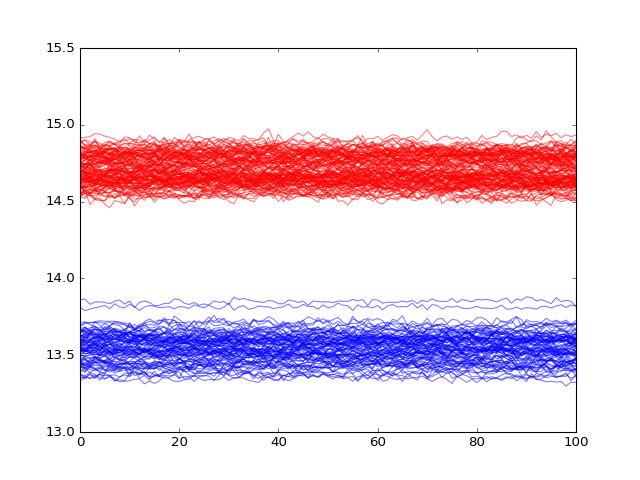

NoFile
NoFile


[]

In [1170]:
model_COM_distances_narrow = session_narrow.query(Chain2Complex_BB_distance).all()
data_narrow = [m.bb_distances for m in model_COM_distances_narrow]

model_COM_distances_wide = session_wide.query(Chain2Complex_BB_distance).all()
data_wide = [m.bb_distances for m in model_COM_distances_wide]

fig_COMM = plt.figure()

n_models_narrow = len(data_narrow)
for k1 in range(n_models_narrow):
    model_data = data_narrow[k1]
    n_frames = len(model_data)
    try:
        mean_X = numpy.mean([json.loads(model_data[k2]) for k2 in range(n_frames)],axis=1)
        plt.plot(mean_X, color='blue', alpha=0.5)
    except:
        print('NoFile')
        
n_models_wide = len(data_wide)
for k1 in range(n_models_wide):
    model_data = data_wide[k1]
    n_frames = len(model_data)
    try:
        mean_X = numpy.mean([json.loads(model_data[k2]) for k2 in range(n_frames)],axis=1)
        plt.plot(mean_X, color='red', alpha=0.5)
    except:
        print('NoFile')

plt.ylim(13,15.5)
plt.plot()

#     print(mean_X)
#     for k2 in range(n_frames):
#         x = json.loads(model_data[k2])
#         print(k2, numpy.mean(x), numpy.std(x))

## Estimated conductance

<IPython.core.display.Javascript object>


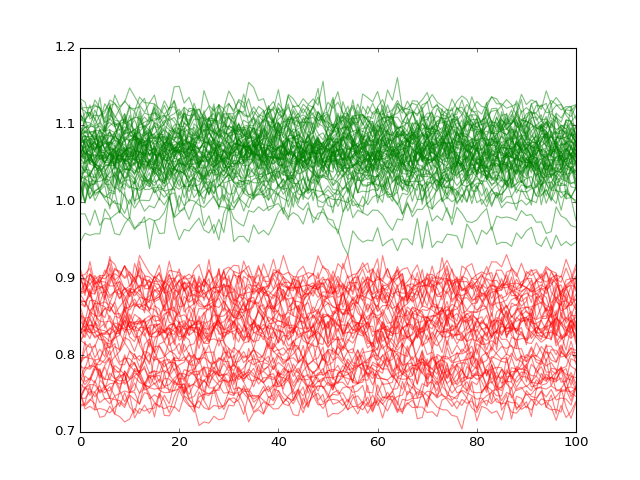

[]

In [1192]:
model_g_narrow = session_narrow.query(HOLE_Output).all()
data_narrow = [m.HOLE_data for m in model_g_narrow]

model_g_wide = session_wide.query(HOLE_Output).all()
data_wide = [m.HOLE_data for m in model_g_wide]

fig_HOLE = plt.figure()

n_models_narrow = len(data_narrow)
for k1 in range(n_models_narrow):
    model_data = data_narrow[k1]
    n_frames = len(model_data)
    try:
        X = [json.loads(model_data[k2])[3] for k2 in range(n_frames)]
        plt.plot(X, color='red', alpha=0.5)
    except:
        pass
#         print('NoFile')

n_models_wide = len(data_wide)
for k1 in range(n_models_wide):
    model_data = data_wide[k1]
    n_frames = len(model_data)
    try:
        X = [json.loads(model_data[k2])[3] for k2 in range(n_frames)]
        plt.plot(X, color='green', alpha=0.5)
    except:
        pass
#         print('NoFile')

plt.ylim(0.7,1.2)
plt.plot()



## H-bond analysis

### Get HO-atom base 

Extract inter-chain HO-atoms for all structures, from all frames.

In [1228]:
def interaction_direction(chain_combination):
    chainc_ccwise = ['AB','BC','CD','DE','EF','FG','GH','HA']
    chainc_cwise  = ['AH','HG','GF','FE','ED','DC','CB','BA']
    chainc_intrachn = ['AA','BB','CC','DD','EE','FF','GG','HH']
    if chain_combination in chainc_cwise:
        return 1
    elif chain_combination in chainc_ccwise:
        return -1
    elif chain_combination in chainc_intrachn:
        return 0

In [1262]:
model_HO_atoms_narrow = session_narrow.query(Interhelix_Interactions).all()
data_narrow = [m.hbonds for m in model_HO_atoms_narrow]

S_hbonds_narrow = set()
n_models_narrow = len(data_narrow)
for k1 in range(n_models_narrow):
    model_data = data_narrow[k1]
    n_frames = len(model_data)
    S_hbonds_model = set(itertools.chain.from_iterable(data_narrow[k1]))
    S_hbonds_narrow = S_hbonds_narrow.union(S_hbonds_model)
    
S_hbonds_reduced_narrow = []
for hb_raw in list(S_hbonds_narrow):
    hb_data = json.loads(hb_raw)
    if interaction_direction(hb_data[-1]) != 0:
        HO_direction = [interaction_direction(hb_data[-1])]
        HO_atoms = hb_data[:-1]
        hb_reduced = json.dumps(HO_atoms+HO_direction)
        S_hbonds_reduced_narrow.append(hb_reduced)
    
S_hbonds_reduced_narrow = list(set(S_hbonds_reduced_narrow))

In [1263]:
model_HO_atoms_wide = session_wide.query(Interhelix_Interactions).all()
data_wide = [m.hbonds for m in model_HO_atoms_wide]

S_hbonds_wide = set()
n_models_wide = len(data_wide)
for k1 in range(n_models_wide):
    if 'NoFile' not in data_wide[k1]:
        model_data = data_wide[k1]
        n_frames = len(model_data)
        S_hbonds_model = set(itertools.chain.from_iterable(data_wide[k1]))
        S_hbonds_wide = S_hbonds_wide.union(S_hbonds_model)
        
S_hbonds_reduced_wide = []
for hb_raw in list(S_hbonds_wide):
    hb_data = json.loads(hb_raw)
    if interaction_direction(hb_data[-1]) != 0:
        HO_direction = [interaction_direction(hb_data[-1])]
        HO_atoms = hb_data[:-1]
        hb_reduced = json.dumps(HO_atoms+HO_direction)
        S_hbonds_reduced_wide.append(hb_reduced)

S_hbonds_reduced_wide = list(set(S_hbonds_reduced_wide))

In [1264]:
S_hbonds_reduced = set(S_hbonds_reduced_wide).union(set(S_hbonds_reduced_narrow))

In [1268]:
set(S_hbonds_reduced_wide).difference(set(S_hbonds_reduced_narrow))

{'["1", "H2", "12", "OE1", -1]',
 '["16", "HG1", "7", "ND2", 1]',
 '["16", "HG1", "7", "OD1", 1]',
 '["26", "HG1", "21", "ND1", 1]',
 '["32", "HG1", "28", "NH1", 1]'}

In [1269]:
set(S_hbonds_reduced_narrow).difference(set(S_hbonds_reduced_wide))

{'["28", "HE", "29", "OH", -1]',
 '["29", "HH", "29", "OH", -1]',
 '["29", "HH", "29", "OH", 1]'}

**Total base of HO-atom types**

In [1274]:
S_hbonds_reduced_ordered = []
for resn in range(1,33):
    for hb in S_hbonds_reduced:
        x = json.loads(hb)
        if int(x[0]) == resn:
            S_hbonds_reduced_ordered.append(json.dumps(x))

In [1275]:
S_hbonds_reduced_ordered

['["1", "H2", "12", "OE1", -1]',
 '["6", "HE1", "16", "OG1", -1]',
 '["16", "HG1", "7", "ND2", 1]',
 '["16", "HG1", "7", "OD1", 1]',
 '["18", "HG1", "22", "OD2", -1]',
 '["18", "HG1", "22", "OD1", -1]',
 '["21", "HE2", "25", "OE2", -1]',
 '["21", "HE2", "22", "OD1", -1]',
 '["21", "HE2", "29", "OH", -1]',
 '["21", "HE2", "25", "OE1", -1]',
 '["24", "HG1", "26", "OG1", -1]',
 '["26", "HG1", "21", "ND1", 1]',
 '["28", "HE", "29", "OH", -1]',
 '["28", "HE", "32", "OG1", -1]',
 '["29", "HH", "25", "OE1", 1]',
 '["29", "HH", "29", "OH", 1]',
 '["29", "HH", "28", "NH2", 1]',
 '["29", "HH", "29", "OH", -1]',
 '["29", "HH", "25", "OE2", 1]',
 '["29", "HH", "28", "NH1", 1]',
 '["32", "HG1", "28", "NH1", 1]']

Analyse evolution of inter-chain H-bond formation probability in time (1 ns)

In [1304]:
n_chains = 8
n_models_narrow = len(data_narrow)
prob_narrow = []
for k1 in range(n_models_narrow):
    model_data = data_narrow[k1]
    n_frames = len(model_data)
    prob_per_traj = []
    for k2 in range(n_frames):
        hbs_frame = model_data[k2]
        prob_per_frame = []
        for S_OH_atom in S_hbonds_reduced_ordered:
            counter_OH_atom = 0
            for hb in hbs_frame:
                hb_data_raw = json.loads(hb)
                HO_direction = [interaction_direction(hb_data_raw[-1])]
                HO_atoms = hb_data_raw[:-1]
                hb_reduced = json.dumps(HO_atoms+HO_direction)
                if hb_reduced == S_OH_atom:
                    counter_OH_atom += 1
            prob_per_frame.append(counter_OH_atom/float(n_chains))
        prob_per_traj.append(prob_per_frame)
    prob_time_mean =  list(numpy.mean(numpy.array(prob_per_traj).T,axis=1))
    prob_narrow.append(prob_time_mean)

In [1310]:
stats_narrow = list(numpy.mean(numpy.array(prob_narrow).T,axis=1))

In [1311]:
stats_narrow

[0.0,
 0.72663425981152308,
 0.0,
 0.0,
 0.97556065847548601,
 0.017669688655612546,
 0.029613503519026578,
 8.9466778003101518e-05,
 0.027496123106286519,
 0.19770666825718719,
 8.9466778003101518e-05,
 0.0,
 7.4555648335917932e-05,
 8.9466778003101518e-05,
 0.022113205296433253,
 1.4911129667183586e-05,
 0.0018489800787307646,
 1.4911129667183586e-05,
 0.2247405463437909,
 0.0013121794107121558,
 0.0]

In [1307]:
n_chains = 8
n_models_wide = len(data_wide)
prob_wide = []
for k1 in range(n_models_wide):
    if 'NoFile' not in data_wide[k1]:
        model_data = data_wide[k1]
        n_frames = len(model_data)
        prob_per_traj = []
        for k2 in range(n_frames):
            hbs_frame = model_data[k2]
            prob_per_frame = []
            for S_OH_atom in S_hbonds_reduced_ordered:
                counter_OH_atom = 0
                for hb in hbs_frame:
                    hb_data_raw = json.loads(hb)
                    HO_direction = [interaction_direction(hb_data_raw[-1])]
                    HO_atoms = hb_data_raw[:-1]
                    hb_reduced = json.dumps(HO_atoms+HO_direction)
                    if hb_reduced == S_OH_atom:
                        counter_OH_atom += 1
                prob_per_frame.append(counter_OH_atom/float(n_chains))
            prob_per_traj.append(prob_per_frame)
        prob_time_mean =  list(numpy.mean(numpy.array(prob_per_traj).T,axis=1))
        prob_wide.append(prob_time_mean)

In [1308]:
stats_wide = list(numpy.mean(numpy.array(prob_wide).T,axis=1))

In [1309]:
stats_wide

[1.0144457068657685e-05,
 0.48686292809608833,
 0.00082170102256127261,
 0.21661459178704753,
 0.93768260022723571,
 0.024437997078396362,
 0.12163204025320572,
 0.0003652004544716767,
 0.0013289238759941571,
 0.41570970621652331,
 8.1155656549261482e-05,
 0.13022439539035871,
 0.0,
 0.0023839474111345565,
 0.064549180327868827,
 0.0,
 0.00065938970946274953,
 0.0,
 0.10896161337445218,
 0.00010144457068657684,
 0.0026375588378509981]

<IPython.core.display.Javascript object>


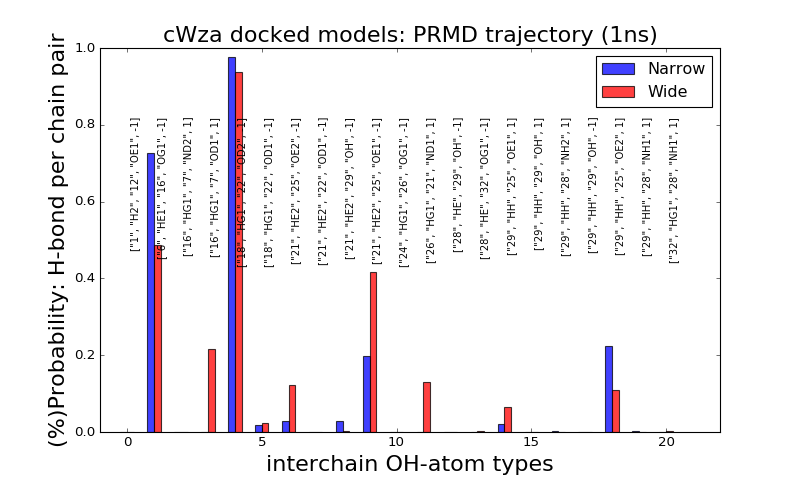

In [1315]:
fig_hbonds_prmd = plt.figure(figsize=(10,6))

plt.bar(numpy.arange(len(stats_narrow))-0.25,numpy.array(stats_narrow),
        width=0.25,facecolor='blue',label='Narrow',alpha=0.75)

plt.bar(numpy.arange(len(stats_wide)),numpy.array(stats_wide),width=0.25,
        facecolor='red',label='Wide',alpha=0.75)

plt.title('cWza docked models: PRMD trajectory (1ns)',fontsize=20)
plt.xlabel("interchain OH-atom types",fontsize=20)
plt.ylabel("(%)Probability: H-bond per chain pair",fontsize=20)

#plt.xticks(numpy.arange(len(nstates_narrow)),
#            ['s'+str(k) for k in numpy.arange(len(nstates_narrow))],rotation=90,fontsize=15)
#plt.yticks(numpy.arange(0,1.1,0.1),numpy.arange(0,110,10),fontsize=15)

plt.xlim(-1,len(S_hbonds_reduced_ordered)+1)
#plt.ylim(0,1)

plt.legend()

for i in range(len(S_hbonds_reduced_ordered)):
    plt.text(i+0.1,0.8,S_hbonds_reduced_ordered[i],rotation=90,fontsize=9)

# plt.plot((12.75,12.75),(0,100),linestyle='--',color='black',alpha=0.75)

plt.show()

## KIH analysis

### Het KIH-atom base

In [1321]:
model_kihs_narrow = session_narrow.query(Interhelix_Interactions).all()
data_narrow = [m.kihs for m in model_kihs_narrow]

S_kihs_narrow = set()
n_models_narrow = len(data_narrow)
for k1 in range(n_models_narrow):
    model_data = data_narrow[k1]
    n_frames = len(model_data)
    S_kihs_model = set(itertools.chain.from_iterable(data_narrow[k1]))
    S_kihs_narrow = S_kihs_narrow.union(S_kihs_model)
    
S_kihs_reduced_narrow = []
for kih_raw in list(S_kihs_narrow):
    kih_data = json.loads(kih_raw)
    kih_direction = [interaction_direction(kih_data[-1])]
    kih_atoms = kih_data[:-1]
    kih_reduced = json.dumps(kih_atoms+kih_direction)
    S_kihs_reduced_narrow.append(kih_reduced)
    
S_kihs_reduced_narrow = list(set(S_kihs_reduced_narrow))

In [1324]:
model_kihs_wide = session_wide.query(Interhelix_Interactions).all()
data_wide = [m.kihs for m in model_kihs_wide]

S_kihs_wide = set()
n_models_wide = len(data_wide)
for k1 in range(n_models_wide):
    if 'NoFile' not in data_wide[k1]:
        model_data = data_wide[k1]
        n_frames = len(model_data)
        S_kihs_model = set(itertools.chain.from_iterable(data_wide[k1]))
        S_kihs_wide = S_kihs_wide.union(S_kihs_model)
    
S_kihs_reduced_wide = []
for kih_raw in list(S_kihs_wide):
    kih_data = json.loads(kih_raw)
    kih_direction = [interaction_direction(kih_data[-1])]
    kih_atoms = kih_data[:-1]
    kih_reduced = json.dumps(kih_atoms+kih_direction)
    S_kihs_reduced_wide.append(kih_reduced)
    
S_kihs_reduced_wide = list(set(S_kihs_reduced_wide))

In [1326]:
S_kihs_reduced = set(S_kihs_reduced_wide).union(set(S_kihs_reduced_narrow))

In [1330]:
S_kihs_reduced_ordered = []
for resn in range(1,33):
    for hb in S_kihs_reduced:
        x = json.loads(hb)
        if int(x[0]) == resn:
            S_kihs_reduced_ordered.append(json.dumps(x))

Get stats for kihs narrow models

In [1332]:
n_chains = 8
n_models_narrow = len(data_narrow)
prob_kihs_narrow = []
for k1 in range(n_models_narrow):
    model_data = data_narrow[k1]
    n_frames = len(model_data)
    prob_per_traj = []
    for k2 in range(n_frames):
        kihs_frame = model_data[k2]
        prob_per_frame = []
        for S_kih in S_kihs_reduced_ordered:
            counter_kihs = 0
            for kih in kihs_frame:
                kih_data_raw = json.loads(kih)
                kih_direction = [interaction_direction(kih_data_raw[-1])]
                kih_atoms = kih_data_raw[:-1]
                kih_reduced = json.dumps(kih_atoms+kih_direction)
                if kih_reduced == S_kih:
                    counter_kihs += 1
            prob_per_frame.append(counter_kihs/float(n_chains))
        prob_per_traj.append(prob_per_frame)
    prob_time_mean =  list(numpy.mean(numpy.array(prob_per_traj).T,axis=1))
    prob_kihs_narrow.append(prob_time_mean)

In [1333]:
stats_kihs_narrow = list(numpy.mean(numpy.array(prob_kihs_narrow).T,axis=1))

In [1335]:
n_chains = 8
n_models_wide = len(data_wide)
prob_kihs_wide = []
for k1 in range(n_models_wide):
    if 'NoFile' not in data_wide[k1]:
        model_data = data_wide[k1]
        n_frames = len(model_data)
        prob_per_traj = []
        for k2 in range(n_frames):
            kihs_frame = model_data[k2]
            prob_per_frame = []
            for S_kih in S_kihs_reduced_ordered:
                counter_kihs = 0
                for kih in kihs_frame:
                    kih_data_raw = json.loads(kih)
                    kih_direction = [interaction_direction(kih_data_raw[-1])]
                    kih_atoms = kih_data_raw[:-1]
                    kih_reduced = json.dumps(kih_atoms+kih_direction)
                    if kih_reduced == S_kih:
                        counter_kihs += 1
                prob_per_frame.append(counter_kihs/float(n_chains))
            prob_per_traj.append(prob_per_frame)
        prob_time_mean =  list(numpy.mean(numpy.array(prob_per_traj).T,axis=1))
        prob_kihs_wide.append(prob_time_mean)

In [1336]:
stats_kihs_wide = list(numpy.mean(numpy.array(prob_kihs_wide).T,axis=1))

Plot the results

<IPython.core.display.Javascript object>


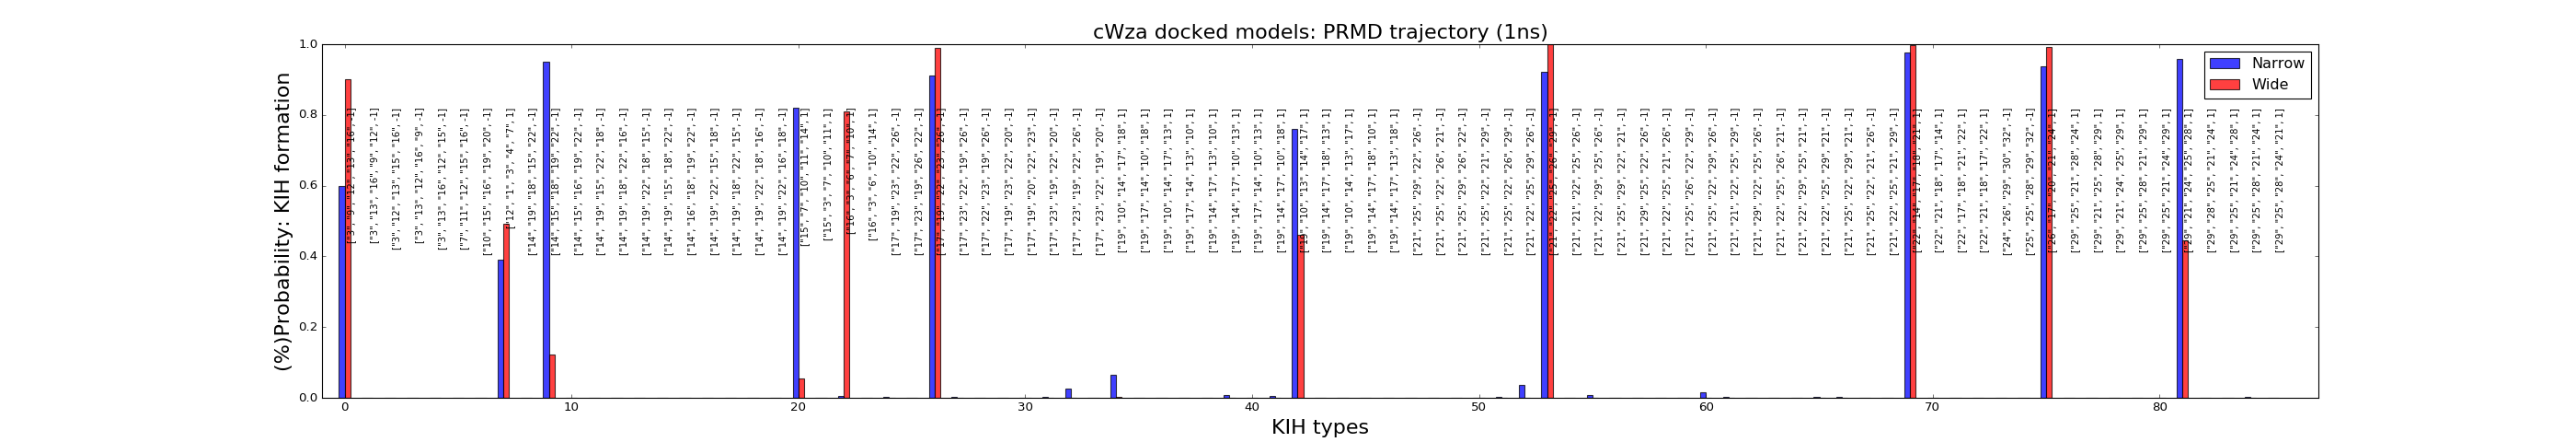

In [1340]:
fig_kihs_prmd = plt.figure(figsize=(35,6))

plt.bar(numpy.arange(len(stats_kihs_narrow))-0.25,numpy.array(stats_kihs_narrow),
        width=0.25,facecolor='blue',label='Narrow',alpha=0.75)

plt.bar(numpy.arange(len(stats_kihs_wide)),numpy.array(stats_kihs_wide),width=0.25,
        facecolor='red',label='Wide',alpha=0.75)

plt.title('cWza docked models: PRMD trajectory (1ns)',fontsize=20)
plt.xlabel("KIH types",fontsize=20)
plt.ylabel("(%)Probability: KIH formation",fontsize=20)

#plt.xticks(numpy.arange(len(nstates_narrow)),
#            ['s'+str(k) for k in numpy.arange(len(nstates_narrow))],rotation=90,fontsize=15)
#plt.yticks(numpy.arange(0,1.1,0.1),numpy.arange(0,110,10),fontsize=15)

plt.xlim(-1,len(S_kihs_reduced_ordered)+1)
#plt.ylim(0,1)

plt.legend()

for i in range(len(S_kihs_reduced_ordered)):
    plt.text(i+0.1,0.8,S_kihs_reduced_ordered[i],rotation=90,fontsize=9)

# plt.plot((12.75,12.75),(0,100),linestyle='--',color='black',alpha=0.75)

plt.show()

# MD trajectories

In [1343]:
import sys, re
import numpy as np
import subprocess
import isambard_dev as isambard
from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sqlalchemy.orm import sessionmaker

In [1344]:
dbfile = ['../md_relax/narrow_models_md.db', '../md_relax/wide_models_md.db']

In [1345]:
dbname = {}
engine = {}
session = {}
for i in range(len(dbfile)):
    dbname[i] = dbfile[i]
    engine[i] = create_engine('sqlite:///'+dbfile[i])
    Base.metadata.create_all(bind=engine[i])
    session[i] = Session(bind=engine[i])

In [1393]:
import read_db_interactions

In [1349]:
data = {}
for i in range(len(dbfile)):
    data[i] = read_db_interactions.get_data('bb_distances', session[i])

<IPython.core.display.Javascript object>


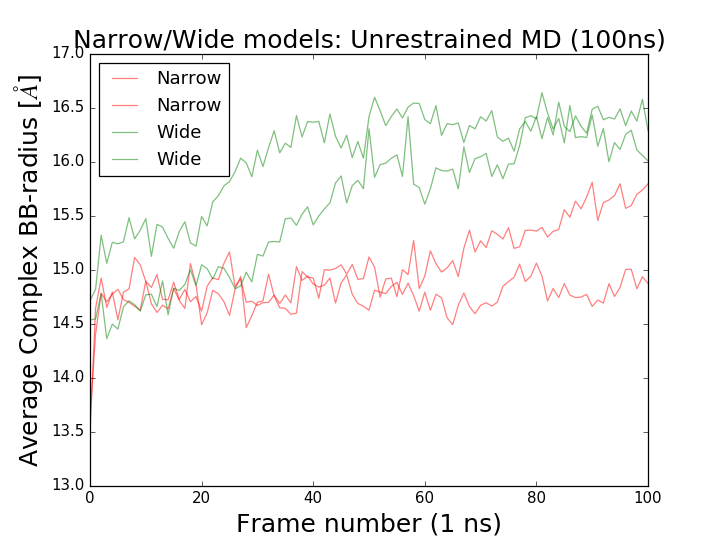

NoFile


In [1378]:
fig_md_bb = plt.figure(dpi=90)

n_models = len(data[0])
for k1 in range(n_models):
    model_data = data[0][k1]
    n_frames = len(model_data)
    try:
        mean_X = numpy.mean([json.loads(model_data[k2]) for k2 in range(n_frames)],axis=1)
        plt.plot(mean_X, color='red', alpha=0.5, label='Narrow')
    except:
        print('NoFile')

        
n_models = len(data[1])
for k1 in range(n_models):
    model_data = data[1][k1]
    n_frames = len(model_data)
    try:
        mean_X = numpy.mean([json.loads(model_data[k2]) for k2 in range(n_frames)],axis=1)
        plt.plot(mean_X, color='green', alpha=0.5, label='Wide')
    except:
        print('NoFile')        
        
plt.title("Narrow/Wide models: Unrestrained MD (100ns)", fontsize=20)
plt.xlabel("Frame number (1 ns)", fontsize=20)
plt.ylabel("Average Complex BB-radius [$\AA$]", fontsize=20)

plt.legend(loc='upper left')
plt.show()

In [1379]:
data_hole = {}
for i in range(len(dbfile)):
    data_hole[i] = read_db_interactions.get_data('HOLE_data', session[i])

<IPython.core.display.Javascript object>


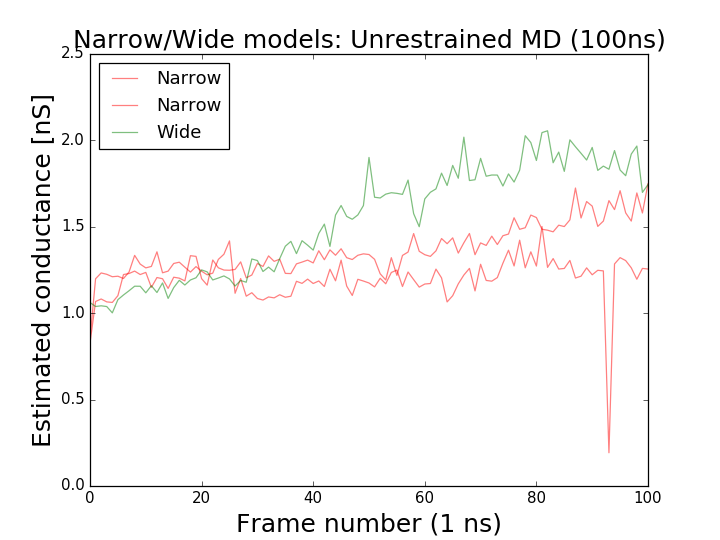

NoFile
NoFile


In [1383]:
fig_md_hole = plt.figure(dpi=90)

n_models = len(data_hole[0])
for k1 in range(n_models):
    model_data = data_hole[0][k1]
    n_frames = len(model_data)
    try:
        mean_X = [json.loads(model_data[k2])[3] for k2 in range(n_frames)]
        plt.plot(mean_X, color='red', alpha=0.5, label='Narrow')
    except:
        print('NoFile')

        
n_models = len(data_hole[1])
for k1 in range(n_models):
    model_data = data_hole[1][k1]
    n_frames = len(model_data)
    try:
        mean_X = [json.loads(model_data[k2])[3] for k2 in range(n_frames)]
        plt.plot(mean_X, color='green', alpha=0.5, label='Wide')
    except:
        print('NoFile')        

plt.title("Narrow/Wide models: Unrestrained MD (100ns)", fontsize=20)
plt.xlabel("Frame number (1 ns)", fontsize=20)
plt.ylabel("Estimated conductance [nS]", fontsize=20)

plt.legend(loc='upper left')
plt.show()

## MD, H-bonds

In [1403]:
import importlib
import read_db_interactions
importlib.reload(read_db_interactions)

<module 'read_db_interactions' from '/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwza_NoWPN/3-analysis/clustering/read_db_interactions.py'>

In [1404]:
data = {}
S_hbonds = {}
S_hbonds_reduced = {}
for i in range(len(dbfile)):
    data[i] = read_db_interactions.get_data('hbonds', session[i])
    S_hbonds[i] = read_db_interactions.get_S_x(data[i])
    S_hbonds_reduced[i] = read_db_interactions.get_S_x_reduced(S_hbonds[i])

In [1408]:
S_hbonds_reduced_all = set()
for i in range(len(dbfile)):
    S_hbonds_reduced_all = S_hbonds_reduced_all.union(S_hbonds_reduced[i])

In [1410]:
S_hbonds_reduced_all_ordered = []
for resn in range(1,33):
    for hb in S_hbonds_reduced_all:
        x = json.loads(hb)
        if int(x[0]) == resn:
            S_hbonds_reduced_all_ordered.append(json.dumps(x))

In [1413]:
stats_hbonds = {}
for i in range(len(dbfile)):
    stats_hbonds[i] = read_db_interactions.get_group_average(data[i], S_hbonds_reduced_all_ordered, n_chains)

<IPython.core.display.Javascript object>


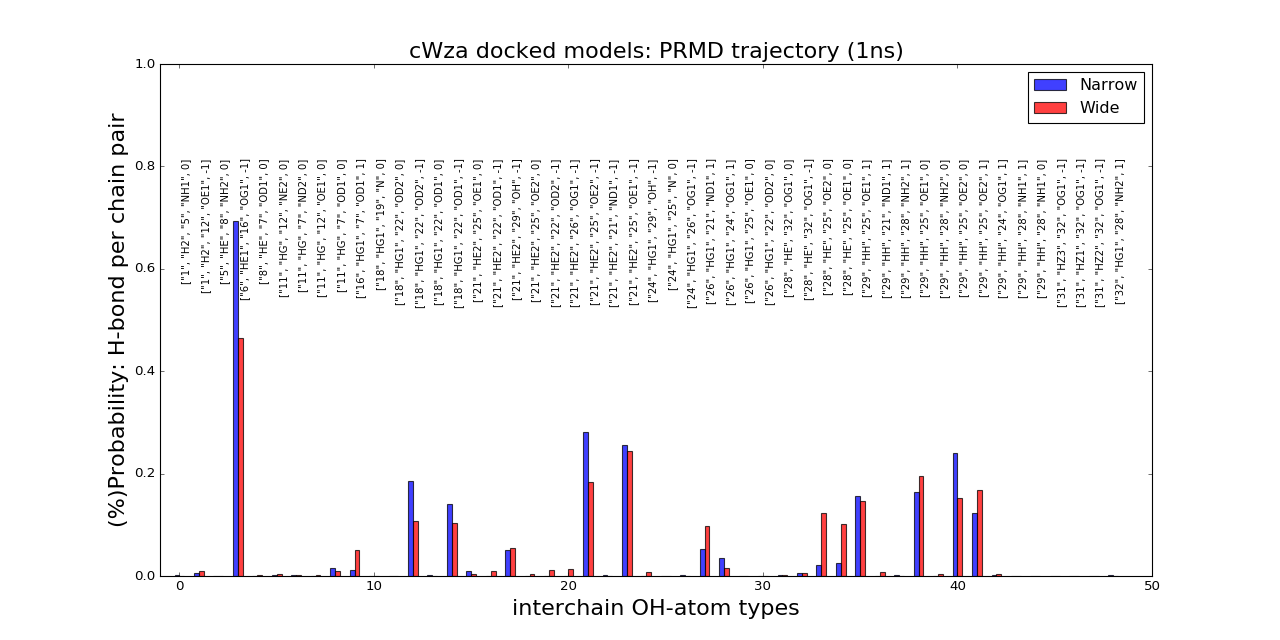

In [1428]:
fig_hbonds_md = plt.figure(figsize=(16,8))

plt.bar(numpy.arange(len(stats_hbonds[0]))-0.25,numpy.array(stats_hbonds[0]),
        width=0.25,facecolor='blue',label='Narrow',alpha=0.75)

plt.bar(numpy.arange(len(stats_hbonds[1])),numpy.array(stats_hbonds[1]),width=0.25,
        facecolor='red',label='Wide',alpha=0.75)

plt.title('cWza docked models: PRMD trajectory (1ns)',fontsize=20)
plt.xlabel("interchain OH-atom types",fontsize=20)
plt.ylabel("(%)Probability: H-bond per chain pair",fontsize=20)

#plt.xticks(numpy.arange(len(nstates_narrow)),
#            ['s'+str(k) for k in numpy.arange(len(nstates_narrow))],rotation=90,fontsize=15)
#plt.yticks(numpy.arange(0,1.1,0.1),numpy.arange(0,110,10),fontsize=15)

plt.xlim(-1,len(S_hbonds_reduced_all_ordered)+1)
#plt.ylim(0,1)

plt.legend()

for i in range(len(S_hbonds_reduced_all_ordered)):
    plt.text(i+0.1,0.8,S_hbonds_reduced_all_ordered[i],rotation=90,fontsize=9)

# plt.plot((12.75,12.75),(0,100),linestyle='--',color='black',alpha=0.75)
plt.ylim(0,1)
plt.show()

<IPython.core.display.Javascript object>


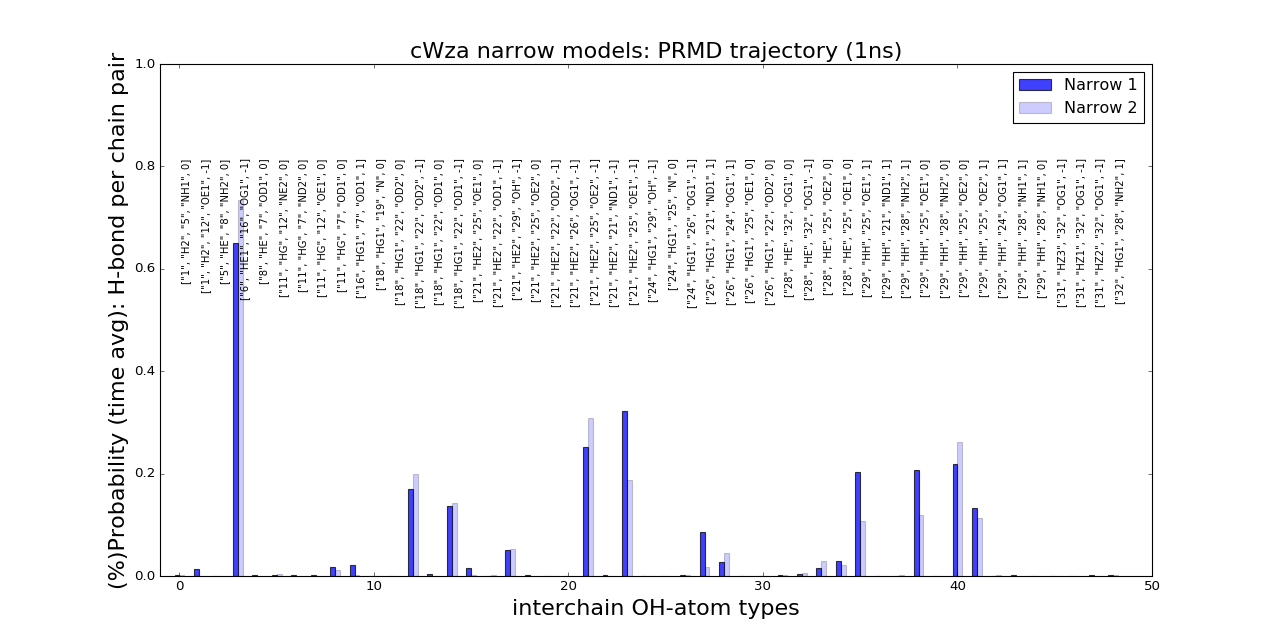

In [1439]:
fig_hbonds_md_models_narrow = plt.figure(figsize=(16,8))

x = read_db_interactions.get_time_average(
        read_db_interactions.get_data('hbonds', session[0])[0], S_hbonds_reduced_all_ordered, 8)

plt.bar(numpy.arange(len(x))-0.25,numpy.array(x),
        width=0.25,facecolor='blue',label='Narrow 1',alpha=0.75)
y = read_db_interactions.get_time_average(
        read_db_interactions.get_data('hbonds', session[0])[1], S_hbonds_reduced_all_ordered, 8)

plt.bar(numpy.arange(len(y)),numpy.array(y),width=0.25,
        facecolor='blue',label='Narrow 2',alpha=0.2)

plt.title('cWza narrow models: PRMD trajectory (1ns)',fontsize=20)
plt.xlabel("interchain OH-atom types",fontsize=20)
plt.ylabel("(%)Probability (time avg): H-bond per chain pair",fontsize=20)

#plt.xticks(numpy.arange(len(nstates_narrow)),
#            ['s'+str(k) for k in numpy.arange(len(nstates_narrow))],rotation=90,fontsize=15)
#plt.yticks(numpy.arange(0,1.1,0.1),numpy.arange(0,110,10),fontsize=15)

plt.xlim(-1,len(S_hbonds_reduced_all_ordered)+1)
#plt.ylim(0,1)

plt.legend()

for i in range(len(S_hbonds_reduced_all_ordered)):
    plt.text(i+0.1,0.8,S_hbonds_reduced_all_ordered[i],rotation=90,fontsize=9)

# plt.plot((12.75,12.75),(0,100),linestyle='--',color='black',alpha=0.75)
plt.ylim(0,1)
plt.show()


<IPython.core.display.Javascript object>


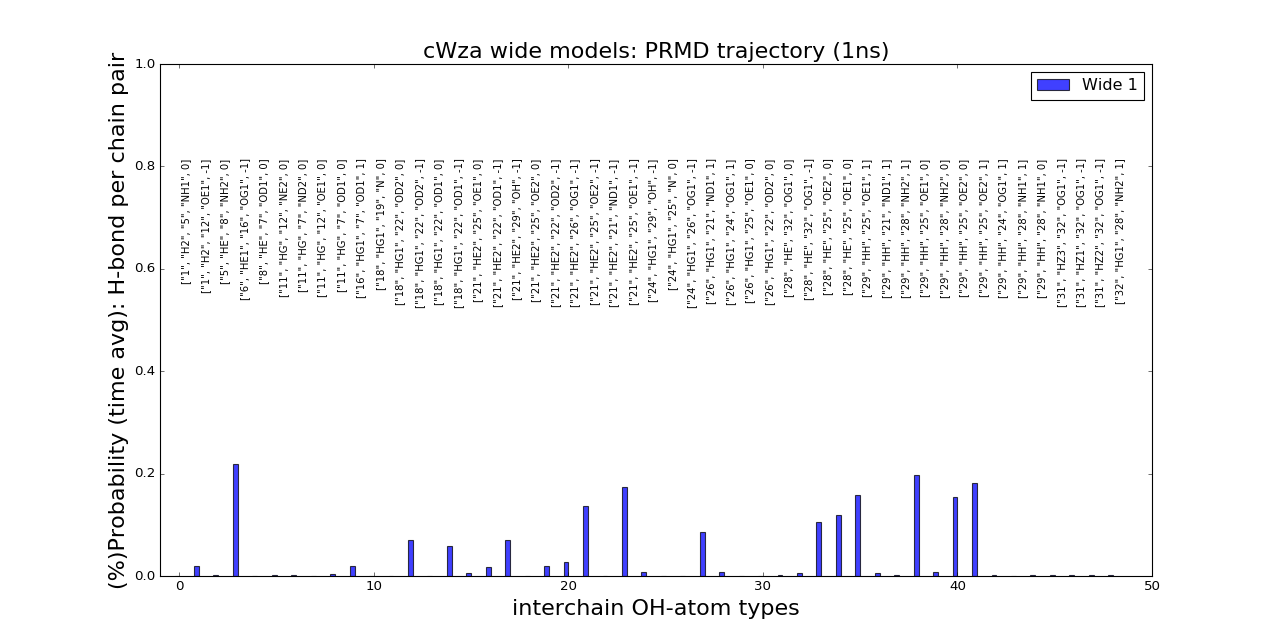

In [1444]:
fig_hbonds_md_models_wide = plt.figure(figsize=(16,8))

x = read_db_interactions.get_time_average(
        read_db_interactions.get_data('hbonds', session[1])[0], S_hbonds_reduced_all_ordered, 8)

plt.bar(numpy.arange(len(x))-0.25,numpy.array(x),
        width=0.25,facecolor='blue',label='Wide 1',alpha=0.75)
# y = read_db_interactions.get_time_average(
#         read_db_interactions.get_data('hbonds', session[1])[1], S_hbonds_reduced_all_ordered, 8)

# plt.bar(numpy.arange(len(y)),numpy.array(y),width=0.25,
#         facecolor='blue',label='Narrow 2',alpha=0.2)

plt.title('cWza wide models: PRMD trajectory (1ns)',fontsize=20)
plt.xlabel("interchain OH-atom types",fontsize=20)
plt.ylabel("(%)Probability (time avg): H-bond per chain pair",fontsize=20)

#plt.xticks(numpy.arange(len(nstates_narrow)),
#            ['s'+str(k) for k in numpy.arange(len(nstates_narrow))],rotation=90,fontsize=15)
#plt.yticks(numpy.arange(0,1.1,0.1),numpy.arange(0,110,10),fontsize=15)

plt.xlim(-1,len(S_hbonds_reduced_all_ordered)+1)
#plt.ylim(0,1)

plt.legend()

for i in range(len(S_hbonds_reduced_all_ordered)):
    plt.text(i+0.1,0.8,S_hbonds_reduced_all_ordered[i],rotation=90,fontsize=9)

# plt.plot((12.75,12.75),(0,100),linestyle='--',color='black',alpha=0.75)
plt.ylim(0,1)
plt.show()


## MD, KIHs

In [1420]:
data = {}
S_kihs = {}
S_kihs_reduced = {}
for i in range(len(dbfile)):
    data[i] = read_db_interactions.get_data('kihs', session[i])
    S_kihs[i] = read_db_interactions.get_S_x(data[i])
    S_kihs_reduced[i] = read_db_interactions.get_S_x_reduced(S_kihs[i])

In [1421]:
S_kihs_reduced_all = set()
for i in range(len(dbfile)):
	S_kihs_reduced_all = S_kihs_reduced_all.union(S_kihs_reduced[i])

In [1422]:
S_kihs_reduced_all_ordered = []
for resn in range(1,33):
    for hb in S_kihs_reduced_all:
        x = json.loads(hb)
        if int(x[0]) == resn:
            S_kihs_reduced_all_ordered.append(json.dumps(x))

In [1423]:
stats_kihs = {}
for i in range(len(dbfile)):
	stats_kihs[i] = read_db_interactions.get_group_average(data[i], S_kihs_reduced_all_ordered, n_chains)

<IPython.core.display.Javascript object>


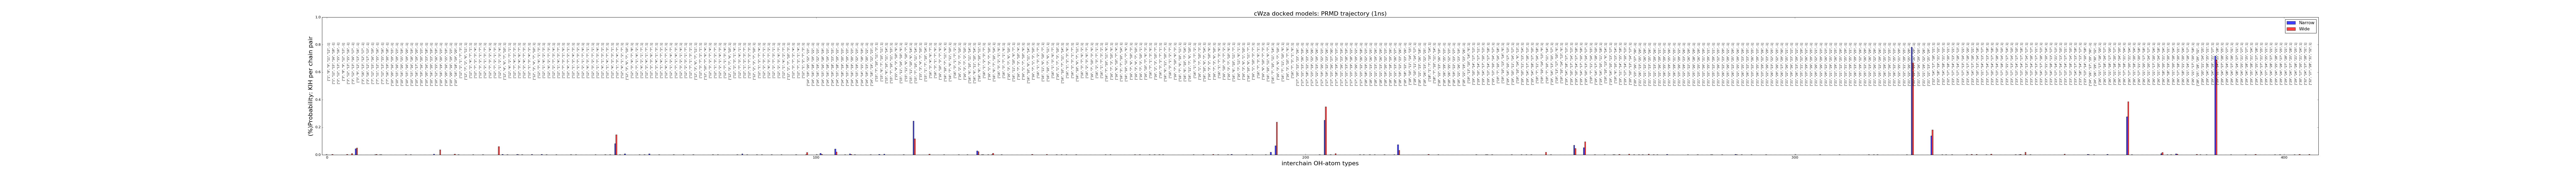

In [1427]:
fig_kihs_md = plt.figure(figsize=(120,8))

plt.bar(numpy.arange(len(stats_kihs[0]))-0.25,numpy.array(stats_kihs[0]),
        width=0.25,facecolor='blue',label='Narrow',alpha=0.75)

plt.bar(numpy.arange(len(stats_kihs[1])),numpy.array(stats_kihs[1]),width=0.25,
        facecolor='red',label='Wide',alpha=0.75)

plt.title('cWza docked models: PRMD trajectory (1ns)',fontsize=20)
plt.xlabel("interchain OH-atom types",fontsize=20)
plt.ylabel("(%)Probability: KIH per chain pair",fontsize=20)

#plt.xticks(numpy.arange(len(nstates_narrow)),
#            ['s'+str(k) for k in numpy.arange(len(nstates_narrow))],rotation=90,fontsize=15)
#plt.yticks(numpy.arange(0,1.1,0.1),numpy.arange(0,110,10),fontsize=15)

plt.xlim(-1,len(S_kihs_reduced_all_ordered)+1)
#plt.ylim(0,1)

plt.legend()

for i in range(len(S_kihs_reduced_all_ordered)):
    plt.text(i+0.1,0.8,S_kihs_reduced_all_ordered[i],rotation=90,fontsize=9)

# plt.plot((12.75,12.75),(0,100),linestyle='--',color='black',alpha=0.75)
plt.ylim(0,1)
plt.show()